## В данном ноутбуке я оценю предсказания моделей. Основной ноутбук - `IMOEX_pipeline`

### Импорт библиотек

In [314]:
# Базовые библиотеки и утилиты
import numpy as np
import pandas as pd
import datetime
import os
import time
import time as time_module
import warnings
from copy import deepcopy
from bisect import bisect_left
from itertools import product
from typing import Union, Optional

# Настройки pandas
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)

# Отображение в Jupyter
from IPython.display import display
%matplotlib inline

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from utilsforecast.plotting import plot_series

# Работа с календарём
import holidays

# Прогресс-бары
from tqdm import tqdm

# SciPy
import scipy as sp
from scipy import stats
from scipy.stats import ttest_1samp, shapiro, ks_2samp, zscore
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

# Dieboldmariano test

from dieboldmariano import dm_test

# Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.datasets import longley
from statsmodels.formula.api import ols
from statsmodels.graphics import tsaplots
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from statsmodels.tsa.stattools import acf, adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.arima.model import ARIMA

# StatsForecast
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, _TS

# Scikit-learn: модели, препроцессинг, метрики
from sklearn.cluster import DBSCAN
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, mean_absolute_error, mean_squared_error, precision_score,
    r2_score, recall_score, roc_auc_score, roc_curve
)
from sklearn.model_selection import (
    GridSearchCV, ParameterGrid, RandomizedSearchCV,
    TimeSeriesSplit, train_test_split
)
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier

# Boosting модели
from catboost import CatBoostRegressor
import catboost as cb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb

# Гиперпараметрический поиск
from hyperopt import fmin, tpe, Trials, STATUS_OK, hp

# Кодировщики категориальных признаков
import category_encoders as ce

# Дополнительные утилиты
from sktime.utils.plotting import plot_correlations

# SHAP
import shap

In [315]:
# имя и фамилию в эту переменную
image_name_prefix = 'Владимир_Смирнов'

# сюда будут сохраняться изображения
path_to_save_images = 'C:\\Users\\smirn\\OneDrive\\Рабочий стол\\FQW_GSOM_PICTURES'

# этот код сохраняет картинку
# plt.savefig(
#     os.path.join(path_to_save_images, f'{image_name_prefix}_image_5.png')
# )

### Ряд используемых функций

#### KPSS и ADF тесты

In [318]:
def adf_test(timeseries, alpha=0.05):
    """
    Augmented Dickey-Fuller Test with выводом интерпретации результата.
    """
    print("ADF Test (Augmented Dickey-Fuller)")
    print("H0: Временной ряд нестационарен (есть единичный корень)")
    print("H1: Временной ряд стационарен\n")
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used'])

    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value

    print(dfoutput)
    
    print("\nИнтерпретация:")
    if dftest[1] < alpha:
        print(f"p-value = {dftest[1]:.4f} < {alpha} => Отклоняем H0: ряд считается стационарным.")
    else:
        print(f"p-value = {dftest[1]:.4f} >= {alpha} => Не отклоняем H0: ряд считается нестационарным.")
    

def kpss_test(timeseries, alpha=0.05, regression='c'):
    """
    KPSS Test с интерпретацией результата.
    regression='c' - проверка на стационарность относительно уровня
    regression='ct' - проверка на стационарность относительно тренда
    """
    print(f"KPSS Test (regression='{regression}')")
    print("H0: Временной ряд тренд-стационарен")
    print("H1: Временной ряд тренд-нестационарен\n")
    
    kpsstest = kpss(timeseries, regression=regression, nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic', 'p-value', 'Lags Used'])

    for key, value in kpsstest[3].items():
        kpss_output[f'Critical Value ({key})'] = value

    print(kpss_output)

    print("\nИнтерпретация:")
    if kpsstest[1] < alpha:
        print(f"p-value = {kpsstest[1]:.4f} < {alpha} => Отклоняем H0: ряд считается тренд-нестационарным.")
    else:
        print(f"p-value = {kpsstest[1]:.4f} ≥ {alpha} => Не отклоняем H0: ряд считается тренд-стационарным.")

#### Функция для репорта по метрикам

In [320]:
def metrics_report(y_true, y_pred, seasonality=1, model_name='Модель'):
    """
    Отчёт по метрикам качества прогноза модели.

    Выводит:
    - Таблицу с основными метриками (локализовано)
    - Визуализацию в виде таблицы без цветовой иерархии

    :param y_true: Истинные значения
    :param y_pred: Предсказания модели
    :param seasonality: Сезонность (для MASE)
    :param model_name: Название модели (для заголовка)
    :return: pd.DataFrame с метриками
    """

    # Приводим данные к Series без индексов
    y_true = pd.Series(y_true).reset_index(drop=True)
    y_pred = pd.Series(y_pred).reset_index(drop=True)

    # Метрики
    def mase(y_true, y_pred, seasonality=1):
        naive = y_true.shift(seasonality)
        mask = ~naive.isna()
        naive_mae = np.mean(np.abs(y_true[mask] - naive[mask]))
        model_mae = np.mean(np.abs(y_true[mask] - y_pred[mask]))
        return model_mae / naive_mae if naive_mae != 0 else np.nan

    def smape(y_true, y_pred):
        denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
        mask = denominator != 0
        return np.mean(np.abs(y_true[mask] - y_pred[mask]) / denominator[mask]) * 100

    def mdape(y_true, y_pred):
        mask = y_true != 0
        return np.median(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

    def mape(y_true, y_pred):
        mask = y_true != 0
        return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

    # Формируем таблицу метрик
    metrics = [
        ['MAE', mean_absolute_error(y_true, y_pred)],
        ['MSE', mean_squared_error(y_true, y_pred)],
        ['RMSE', np.sqrt(mean_squared_error(y_true, y_pred))],
        ['MAPE (%)', mape(y_true, y_pred)],
        ['MDAPE (%)', mdape(y_true, y_pred)],
        ['SMAPE (%)', smape(y_true, y_pred)],
        ['R2', r2_score(y_true, y_pred)],
        ['MASE', mase(y_true, y_pred, seasonality=seasonality)]
    ]

    df = pd.DataFrame(metrics, columns=['Метрика', 'Значение'])
    df['Значение'] = df['Значение'].round(4)

    # Визуализация таблицы
    fig, ax = plt.subplots(figsize=(5, len(df) * 0.5 + 1))
    ax.axis('off')

    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc='center',
        loc='center'
    )

    # Настройка шрифта
    table.auto_set_font_size(False)
    table.set_fontsize(10)

    # Стиль
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#f0f0f0')
        elif col == 1:
            cell.set_text_props(weight='bold', color='black')

    plt.tight_layout()
    plt.show()

    return df

#### График

In [322]:
def plotly_single_feature(
    df,
    column,
    index_col='ds',
    title=None,
    yaxis_title='Значение',
    line_name=None,
    color='#636EFA',
    show_mean=True,
    show_median=True,
    save=False,
    save_path='feature_plot.html'
):
    """
    Универсальный график временного ряда с возможностью отобразить среднее и медиану.

    Параметры:
    - df: DataFrame с данными
    - column: имя числового столбца для отображения
    - index_col: колонка с временным индексом (по умолчанию 'ds')
    - title: заголовок графика
    - yaxis_title: подпись оси Y
    - line_name: имя основного ряда (по умолчанию = column)
    - color: цвет линии (по умолчанию Plotly синий)
    - show_mean: показать линию среднего
    - show_median: показать линию медианы
    - save: сохранить график в HTML
    - save_path: путь к файлу (если save=True)
    """
    df = df.copy()

    if index_col in df.columns:
        df = df.set_index(index_col)

    line_name = line_name or column
    title = title or f'График: {column}'

    mean_val = df[column].mean()
    median_val = df[column].median()

    traces = []

    # Основная линия
    traces.append(go.Scatter(
        x=df.index,
        y=df[column],
        mode='lines',
        name=line_name,
        line=dict(color=color, width=2)
    ))

    # Медиана
    if show_median:
        traces.append(go.Scatter(
            x=[df.index.min(), df.index.max()],
            y=[median_val, median_val],
            mode='lines',
            name='Медиана',
            line=dict(color='orange', width=2, dash='dash')
        ))

    # Среднее
    if show_mean:
        traces.append(go.Scatter(
            x=[df.index.min(), df.index.max()],
            y=[mean_val, mean_val],
            mode='lines',
            name='Среднее',
            line=dict(color='blue', width=2, dash='dot')
        ))

    layout = go.Layout(
        title=title,
        xaxis=dict(title='Дата'),
        yaxis=dict(title=yaxis_title),
        template='plotly_white',
        hovermode='x unified',
        legend=dict(
            title='Легенда',
            orientation='v',
            x=1.02,
            y=1,
            xanchor='left',
            yanchor='top',
            bgcolor='rgba(255,255,255,0.8)',
            bordercolor='lightgray',
            borderwidth=1
        )
    )

    fig = go.Figure(data=traces, layout=layout)
    iplot(fig)

    if save:
        dir_to_save = os.path.dirname(save_path)
        if dir_to_save:
            os.makedirs(dir_to_save, exist_ok=True)
        plot(fig, filename=save_path, auto_open=False)
        print(f'Сохранено в файл: {os.path.abspath(save_path)}')

#### График IMOEX

In [324]:
def plotly_single_feature_IMOEX(df, column='y', title='График индекса IMOEX', save=False, save_path='imoex_plot.html'):
    df = df.copy()

    if 'ds' in df.columns:
        df = df.set_index('ds')

    median_val = df[column].median()
    mean_val = df[column].mean()

    trace_line = go.Scatter(
        x=df.index,
        y=df[column],
        mode='lines',
        name='IMOEX',
        line=dict(color='#636EFA', width=2)
    )

    trace_median = go.Scatter(
        x=[df.index.min(), df.index.max()],
        y=[median_val, median_val],
        mode='lines',
        name='Медиана (IMOEX)',
        line=dict(color='orange', width=2, dash='dash')
    )

    trace_mean = go.Scatter(
        x=[df.index.min(), df.index.max()],
        y=[mean_val, mean_val],
        mode='lines',
        name='Среднее (IMOEX)',
        line=dict(color='blue', width=2, dash='dot')
    )

    layout = go.Layout(
        title=title,
        xaxis=dict(title='Дата'),
        yaxis=dict(title='Значение индекса'),
        template='plotly_white',
        hovermode='x unified',
        legend=dict(
            title='Легенда',
            orientation='v',
            x=1.02,
            y=1,
            xanchor='left',
            yanchor='top',
            bgcolor='rgba(255,255,255,0.8)',
            bordercolor='lightgray',
            borderwidth=1
        )
    )

    fig = go.Figure(data=[trace_line, trace_median, trace_mean], layout=layout)
    iplot(fig)

    if save:
        dir_to_save = os.path.dirname(save_path)
        if dir_to_save:
            os.makedirs(dir_to_save, exist_ok=True)
        plot(fig, filename=save_path, auto_open=False)
        print(f'Сохранено в файл: {os.path.abspath(save_path)}')

#### Оценка SARIMAX

In [326]:
def check_fit(resids):
    resids = np.asarray(resids)
    
    # Проверка: среднее = 0
    mean_t, mean_pval = ttest_1samp(resids, 0)

    # ADF тест на стационарность
    stat_t, stat_pval = adfuller(resids, maxlag=6)[:2]

    # Shapiro–Wilk тест на нормальность
    norm_stat, norm_pval = shapiro(resids)

    # Ljung–Box тест на автокорреляцию
    lb_ok = (acorr_ljungbox(resids, model_df=0, return_df=True)['lb_pvalue'] > 0.05).all()

    # Breusch–Pagan тест на гетероскедастичность (по индексу времени)
    time_index = np.arange(len(resids))
    exog = sm.add_constant(time_index)
    _, _, f_stat, f_pval = het_breuschpagan(resids, exog)

    # Финальный результат
    records = {
        "mean_resids": np.mean(resids),
        "mean_t": mean_t,
        "mean_pval": mean_pval,
        "stationary_t": stat_t,
        "stationary_pval": stat_pval,
        "norm_stat": norm_stat,
        "norm_pval": norm_pval,
        "autocor_pass": lb_ok,
        "heteroscedasticity_f": f_stat,
        "heteroscedasticity_pval": f_pval,
        "check_result": (mean_pval > 0.05) & (stat_pval < 0.05) & (norm_pval > 0.05) & (f_pval > 0.05) & lb_ok
    }

    return records

##_________________________________________________________##

def plot_diagnostics(data, dt_col, resid_col, lags=20, suptitle_suffix=""):
    fig, ax = plt.subplots(3, 2, figsize=(16, 14))
    
    # Опциональная подпись
    extra = f" {suptitle_suffix}" if suptitle_suffix else ""
    
    # 1. Динамика ошибок
    sns.lineplot(data=data, x=dt_col, y=resid_col, ax=ax[0][0])
    ax[0][0].axhline(0, c="k", linestyle="--")
    ax[0][0].set_title("Динамика ошибок прогноза" + extra, fontweight='bold')
    ax[0][0].set_xlabel(None)
    ax[0][0].set_ylabel("Остатки")
    ax[0][0].xaxis.set_major_locator(plt.MaxNLocator(6))
    
    # 2. Гистограмма остатков
    ax[0][1].hist(data[resid_col], bins=500, edgecolor='k', alpha=1.0)
    ax[0][1].set_xlim(-200, 200)
    ax[0][1].set_title("Гистограмма ошибок прогноза" + extra, fontweight='bold')
    ax[0][1].set_xlabel("Остатки")
    ax[0][1].set_ylabel("Частота")

    # 3. ACF с p-value из Ljung-Box
    plot_acf(data[resid_col], lags=lags, ax=ax[1][0])
    ax[1][0].set_title("ACF ошибок прогноза" + extra, fontweight='bold')
    
    lb_test = acorr_ljungbox(data[resid_col], lags=[lags], return_df=True)
    lb_pvalue = lb_test['lb_pvalue'].values[0]
    ax[1][0].text(0.95, 0.95, f"Ljung–Box p = {lb_pvalue:.3f}",
                  horizontalalignment='right',
                  verticalalignment='top',
                  transform=ax[1][0].transAxes,
                  fontsize=10,
                  bbox=dict(facecolor='white', alpha=0.8))

    print(f"\nLjung–Box test (lag={lags}) p-value: {lb_pvalue:.4f}")

    # 4. PACF
    plot_pacf(data[resid_col], lags=lags, ax=ax[1][1])
    ax[1][1].set_title("PACF ошибок прогноза" + extra, fontweight='bold')

    # 5. Q–Q график
    qqplot(data[resid_col], line='s', ax=ax[2][0])
    ax[2][0].set_title("Q–Q график остатков" + extra, fontweight='bold')

    # 6. Пустой subplot
    ax[2][1].axis('off')

    plt.tight_layout()
    plt.show()

### Начало анализа

In [328]:
df = pd.read_excel("data_df.xlsx")

In [329]:
df.head()

date  imoex_price  imoex_open  imoex_high  imoex_low  \
0 2022-04-01     2759.640    2714.620    2817.720   2714.620   
1 2022-04-04     2787.690    2775.060    2835.460   2682.340   
2 2022-04-05     2662.790    2796.560    2808.270   2576.340   
3 2022-04-06     2611.430    2641.790    2696.970   2594.950   
4 2022-04-07     2635.390    2618.260    2653.850   2618.260   

   imoex_change_percent  cb_rate  dxy_price  dxy_open  dxy_high  dxy_low  \
0                 0.021    0.200     98.630    98.330    98.740   98.310   
1                 0.010    0.200     99.000    98.570    99.080   98.520   
2                -0.045    0.200     99.470    99.000    99.520   98.840   
3                -0.019    0.200     99.600    99.470    99.770   99.310   
4                 0.009    0.200     99.750    99.650    99.830   99.400   

   dxy_change_percent  gold_price  west_price  brent_price  eur_rub_price  \
0               0.003    5159.820      99.320      106.130         94.677   
1               0.004    5185.800     103.290      108.150         91.920   
2               0.005    5185.420     101.980      106.600         91.611   
3               0.001    5172.870      96.390      100.810         89.500   
4               0.002    5162.480      96.050       99.830         86.106   

   eur_rub_open  eur_rub_high  eur_rub_low  eur_rub_change_percent  \
0        90.530        98.533       89.647                   0.046   
1        93.063        99.129       91.027                  -0.029   
2        91.916        94.464       90.740                  -0.003   
3        91.611        92.552       88.396                  -0.023   
4        89.500        90.556       84.118                  -0.038   

   usd_rub_price  usd_rub_open  usd_rub_high  usd_rub_low  \
0         83.250        81.000        89.894       81.000   
1         81.495        80.000        89.750       79.550   
2         81.750        83.495        86.297       82.019   
3         80.000        84.000        85.743       80.733   
4         76.750        84.000        84.266       76.907   

   usd_rub_change_percent  moexog_open  moexog_high  moexog_low  moexog_close  \
0                   0.051     7196.890     7426.130    7155.300      7182.950   
1                  -0.021     7263.440     7353.650    7029.550      7192.490   
2                   0.003     7241.720     7241.720    6672.320      6865.910   
3                  -0.021     6777.360     6990.170    6733.400      6766.870   
4                  -0.041     6800.070     6850.620    6714.140      6774.050   

     moexog_value  moexeu_open  moexeu_high  moexeu_low  moexeu_close  \
0 21907823883.000     1438.600     1484.480    1427.540      1480.360   
1 17433810186.200     1496.230     1511.990    1448.930      1477.140   
2 16554806352.350     1480.970     1483.920    1385.080      1426.090   
3  9247590319.150     1411.830     1454.040    1398.880      1427.670   
4  9805789401.000     1430.960     1447.070    1426.160      1436.500   

    moexeu_value  moextl_open  moextl_high  moextl_low  moextl_close  \
0 2254936276.850     1643.540     1695.960    1604.710      1613.620   
1 1557943790.600     1610.840     1652.810    1557.910      1589.390   
2 1622786413.700     1589.940     1589.940    1493.990      1509.070   
3 1119814577.550     1499.680     1512.590    1475.310      1485.620   
4  699916023.850     1493.450     1525.890    1486.450      1493.930   

   moextl_value  moexmm_open  moexmm_high  moexmm_low  moexmm_close  \
0 511577043.500     9155.610     9294.450    9078.520      9171.270   
1 495081058.000     9291.710     9373.660    9018.650      9278.810   
2 405740249.300     9282.170     9304.650    8837.860      9095.940   
3 272932063.000     9051.290     9181.220    8945.090      9023.810   
4 192555104.600     9063.700     9084.550    8947.840      9024.140   

     moexmm_value  moexfn_open  moexfn_high  moexfn_low  moexfn_close  \
0 11158796505.920     6730.850     7258.120    6730.850 

#### Лишнее

In [331]:
# Удалю
df = df.drop(['imoex_open','imoex_high','imoex_low', 'imoex_change_percent'], axis=1)

# Список суффиксов, которые нужно исключить
suffixes_to_exclude = ['_open', '_high', '_low', '_percent']

# Фильтрация колонок: исключаем те, что заканчиваются на указанные суффиксы
filtered_columns = [col for col in df.columns if not any(col.endswith(suffix) for suffix in suffixes_to_exclude)]

# Новый датафрейм только с нужными колонками
df_filtered = df[filtered_columns]

df = df_filtered
# Удаление всех колонок с суффиксом '_value'
df = df.drop(columns=[col for col in df.columns if col.endswith('_value')])
df.columns

Index(['date', 'imoex_price', 'cb_rate', 'dxy_price', 'gold_price',
       'west_price', 'brent_price', 'eur_rub_price', 'usd_rub_price',
       'moexog_close', 'moexeu_close', 'moextl_close', 'moexmm_close',
       'moexfn_close', 'moexcn_close', 'moexch_close', 'moexit_close',
       'moexre_close', 'moextn_close', 'vix_price', 'djia_price', 'rvi_price',
       'sp500_price', 'nasdaq_price'],
      dtype='object')

In [332]:
df.head()

date  imoex_price  cb_rate  dxy_price  gold_price  west_price  \
0 2022-04-01     2759.640    0.200     98.630    5159.820      99.320   
1 2022-04-04     2787.690    0.200     99.000    5185.800     103.290   
2 2022-04-05     2662.790    0.200     99.470    5185.420     101.980   
3 2022-04-06     2611.430    0.200     99.600    5172.870      96.390   
4 2022-04-07     2635.390    0.200     99.750    5162.480      96.050   

   brent_price  eur_rub_price  usd_rub_price  moexog_close  moexeu_close  \
0      106.130         94.677         83.250      7182.950      1480.360   
1      108.150         91.920         81.495      7192.490      1477.140   
2      106.600         91.611         81.750      6865.910      1426.090   
3      100.810         89.500         80.000      6766.870      1427.670   
4       99.830         86.106         76.750      6774.050      1436.500   

   moextl_close  moexmm_close  moexfn_close  moexcn_close  moexch_close  \
0      1613.620      9171.270      7160.390      6698.790     35582.710   
1      1589.390      9278.810      7487.570      6622.470     34738.470   
2      1509.070      9095.940      7062.270      6241.010     33156.480   
3      1485.620      9023.810      6788.570      6177.800     35470.780   
4      1493.930      9024.140      6902.900      6143.590     34764.850   

   moexit_close  moexre_close  moextn_close  vix_price  djia_price  rvi_price  \
0      2271.470      7681.430      1003.180     19.630      18.270     97.030   
1      2223.420      7441.640      1033.290     18.570      17.380     95.910   
2      2095.040      6845.510       984.290     21.030      19.620     95.520   
3      2015.430      6634.590       991.440     22.100      20.100     98.000   
4      2051.020      6954.560      1007.510     21.550      20.040     91.000   

   sp500_price  nasdaq_price  
0     4545.860     14261.500  
1     4582.640     14532.550  
2     4525.120     14204.170  
3     4481.150     13888.820  
4     4500.210     13897.300

#### Переименуем таргет

In [334]:
df['y'] = df['imoex_price']
df['ds'] = df['date']

df = df.drop('imoex_price', axis=1)
df = df.drop('date', axis=1)

df.columns

Index(['cb_rate', 'dxy_price', 'gold_price', 'west_price', 'brent_price',
       'eur_rub_price', 'usd_rub_price', 'moexog_close', 'moexeu_close',
       'moextl_close', 'moexmm_close', 'moexfn_close', 'moexcn_close',
       'moexch_close', 'moexit_close', 'moexre_close', 'moextn_close',
       'vix_price', 'djia_price', 'rvi_price', 'sp500_price', 'nasdaq_price',
       'y', 'ds'],
      dtype='object')

### Работа с пропусками

In [336]:
df.isna().sum()

cb_rate           0
dxy_price         6
gold_price       11
west_price       35
brent_price      24
eur_rub_price     3
usd_rub_price     3
moexog_close      0
moexeu_close      0
moextl_close      0
moexmm_close      0
moexfn_close      0
moexcn_close      0
moexch_close      0
moexit_close      0
moexre_close      0
moextn_close      0
vix_price         4
djia_price       31
rvi_price         7
sp500_price      31
nasdaq_price     31
y                 0
ds                0
dtype: int64

#### Полиномиальная интерполяция 2-го порядка для заполнения пропусков

In [338]:
# Колонки с пропусками, которые нужно интерполировать
columns_to_interpolate = [
    'dxy_price', 'gold_price', 'west_price', 'brent_price', 
    'eur_rub_price', 'usd_rub_price', 'vix_price', 'djia_price', 
    'rvi_price', 'sp500_price', 'nasdaq_price'
]

# Интерполяция
for col in columns_to_interpolate:
    df[col] = df[col].interpolate(method='polynomial', order=2, limit_direction='both')

In [339]:
df.isna().sum()

cb_rate          0
dxy_price        0
gold_price       0
west_price       0
brent_price      0
eur_rub_price    0
usd_rub_price    0
moexog_close     0
moexeu_close     0
moextl_close     0
moexmm_close     0
moexfn_close     0
moexcn_close     0
moexch_close     0
moexit_close     0
moexre_close     0
moextn_close     0
vix_price        0
djia_price       0
rvi_price        0
sp500_price      0
nasdaq_price     0
y                0
ds               0
dtype: int64

### Работа с датами

#### Праздники
https://www.cbr.ru/eng/other/holidays/#y2025

Добавляем вручную, так как неудовлетворен готовым решением в `holidays`

In [342]:
manual_holidays = {
    # 2022
    "2022-01-01": "New_Year_Holidays",
    "2022-01-02": "New_Year_Holidays",
    "2022-01-03": "New_Year_Holidays",
    "2022-01-04": "New_Year_Holidays",
    "2022-01-05": "New_Year_Holidays",
    "2022-01-06": "New_Year_Holidays",
    "2022-01-08": "New_Year_Holidays",
    "2022-01-07": "Christmas_Day",
    "2022-02-23": "Defender_of_the_Fatherland_Day",
    "2022-03-08": "International_Womens_Day",
    "2022-05-01": "Spring_and_Labour_Holiday",
    "2022-05-02": "Holiday",
    "2022-05-09": "Victory_Day",
    "2022-06-12": "Day_of_Russia",
    "2022-06-13": "Holiday",
    "2022-11-04": "National_Unity_Day",
    "2022-03-07": "Additional_Holiday",
    "2022-05-03": "Additional_Holiday",
    "2022-05-10": "Additional_Holiday",

    # 2023
    "2023-01-01": "New_Year_Holidays",
    "2023-01-02": "New_Year_Holidays",
    "2023-01-03": "New_Year_Holidays",
    "2023-01-04": "New_Year_Holidays",
    "2023-01-05": "New_Year_Holidays",
    "2023-01-06": "New_Year_Holidays",
    "2023-01-08": "New_Year_Holidays",
    "2023-01-07": "Christmas_Day",
    "2023-02-23": "Defender_of_the_Fatherland_Day",
    "2023-03-08": "International_Womens_Day",
    "2023-05-01": "Spring_and_Labour_Holiday",
    "2023-05-09": "Victory_Day",
    "2023-06-12": "Day_of_Russia",
    "2023-11-04": "National_Unity_Day",
    "2023-02-24": "Additional_Holiday",
    "2023-05-08": "Additional_Holiday",
    "2023-11-06": "Additional_Holiday",

    # 2024
    "2024-01-01": "New_Year_Holidays",
    "2024-01-02": "New_Year_Holidays",
    "2024-01-03": "New_Year_Holidays",
    "2024-01-04": "New_Year_Holidays",
    "2024-01-05": "New_Year_Holidays",
    "2024-01-06": "New_Year_Holidays",
    "2024-01-08": "New_Year_Holidays",
    "2024-01-07": "Christmas_Day",
    "2024-02-23": "Defender_of_the_Fatherland_Day",
    "2024-03-08": "International_Womens_Day",
    "2024-05-01": "Spring_and_Labour_Holiday",
    "2024-05-09": "Victory_Day",
    "2024-06-12": "Day_of_Russia",
    "2024-11-04": "National_Unity_Day",
    "2024-04-29": "Additional_Holiday",
    "2024-04-30": "Additional_Holiday",
    "2024-05-10": "Additional_Holiday",
    "2024-12-30": "Additional_Holiday",
    "2024-12-31": "Additional_Holiday",

    # 2025
    "2025-01-01": "New_Year_Holidays",
    "2025-01-02": "New_Year_Holidays",
    "2025-01-03": "New_Year_Holidays",
    "2025-01-04": "New_Year_Holidays",
    "2025-01-05": "New_Year_Holidays",
    "2025-01-06": "New_Year_Holidays",
    "2025-01-08": "New_Year_Holidays",
    "2025-01-07": "Christmas_Day",
    "2025-02-23": "Defender_of_the_Fatherland_Day",
    "2025-03-08": "International_Womens_Day",
    "2025-05-01": "Spring_and_Labour_Holiday",
    "2025-05-09": "Victory_Day",
    "2025-06-12": "Day_of_Russia",
    "2025-11-04": "National_Unity_Day",
    "2025-05-02": "Additional_Holiday",
    "2025-05-08": "Additional_Holiday",
    "2025-06-13": "Additional_Holiday",
    "2025-11-03": "Additional_Holiday",
    "2025-12-31": "Additional_Holiday"
}

In [343]:
def create_time_features(df, date_col='ds'):

    # Преобразование в datetime
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df = df[df[date_col].notna()]

    # Основные компоненты даты
    df['month'] = df[date_col].dt.month
    df['day'] = df[date_col].dt.day
    df['week'] = df[date_col].dt.isocalendar().week.astype(int)
    df['weekday'] = df[date_col].dt.dayofweek
    df['dayofyear'] = df[date_col].dt.dayofyear

    # Сезон и квартал
    df['season'] = df['month'].map({12: 'Winter', 1: 'Winter', 2: 'Winter',
                                    3: 'Spring', 4: 'Spring', 5: 'Spring',
                                    6: 'Summer', 7: 'Summer', 8: 'Summer',
                                    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'})
    df['quarter'] = ((df['month'] - 1) // 3 + 1).astype(int)

    # Ручные праздники
    df['holiday_name'] = df[date_col].dt.strftime('%Y-%m-%d').map(manual_holidays).fillna("No_Holiday")
    df['is_holiday'] = (df['holiday_name'] != 'No_Holiday').astype(int)
    df['is_holiday_int'] = df['is_holiday']

    # Булевы признаки начала/конца периода
    df['is_month_start'] = df[date_col].dt.is_month_start
    df['is_month_end'] = df[date_col].dt.is_month_end
    df['is_quarter_start'] = df[date_col].dt.is_quarter_start
    df['is_quarter_end'] = df[date_col].dt.is_quarter_end

    # Циклические признаки
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)
    df['dayofyear_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
    df['dayofyear_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365)

    # Положение в неделе и месяце
    df['is_friday'] = (df['weekday'] == 4).astype(int)
    df['is_monday'] = (df['weekday'] == 0).astype(int)
    df['weekday_group'] = df['weekday'].map({0: 'Start', 1: 'Start', 2: 'Mid', 3: 'Mid',
                                             4: 'End', 5: 'Weekend', 6: 'Weekend'})
    df['week_of_month'] = df[date_col].apply(lambda d: (d.day - 1) // 7 + 1)

    # Относительное положение
    df['days_since_start'] = (df[date_col] - df[date_col].min()).dt.days

    # Расстояния до ближайших праздников
    holiday_dates = sorted([pd.to_datetime(d) for d in manual_holidays.keys()])

    def days_until_next_holiday(date):
        pos = bisect_left(holiday_dates, date)
        return (holiday_dates[pos] - date).days if pos < len(holiday_dates) else np.nan

    def days_since_previous_holiday(date):
        pos = bisect_left(holiday_dates, date)
        return (date - holiday_dates[pos - 1]).days if pos > 0 else np.nan

    df['days_until_holiday'] = df[date_col].apply(lambda x: days_until_next_holiday(x.normalize()))
    df['days_since_holiday'] = df[date_col].apply(lambda x: days_since_previous_holiday(x.normalize()))

    # Флаг длинных выходных
    df['is_long_weekend'] = df['is_holiday_int'].rolling(window=3, center=True, min_periods=1).sum() >= 2
    df['is_long_weekend'] = df['is_long_weekend'].astype(int)

    # Новые флаги: до / после длинных выходных
    df['is_day_before_long_weekend'] = df['is_long_weekend'].shift(-1).fillna(0).astype(int)
    df['is_day_after_long_weekend'] = df['is_long_weekend'].shift(1).fillna(0).astype(int)

    # Флаги до/после праздников (1–3–7–14 дней)
    for offset in [1, 2, 3, 7, 14]:
        df[f'before_holiday_{offset}d'] = df[date_col].shift(-offset).dt.strftime('%Y-%m-%d').map(manual_holidays).notna().astype(int)
        df[f'after_holiday_{offset}d'] = df[date_col].shift(offset).dt.strftime('%Y-%m-%d').map(manual_holidays).notna().astype(int)

    return df

In [344]:
df = create_time_features(df, date_col='ds')

# Преобразование всех булевых столбцов в int
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

df.head()

cb_rate  dxy_price  gold_price  west_price  brent_price  eur_rub_price  \
0    0.200     98.630    5159.820      99.320      106.130         94.677   
1    0.200     99.000    5185.800     103.290      108.150         91.920   
2    0.200     99.470    5185.420     101.980      106.600         91.611   
3    0.200     99.600    5172.870      96.390      100.810         89.500   
4    0.200     99.750    5162.480      96.050       99.830         86.106   

   usd_rub_price  moexog_close  moexeu_close  moextl_close  moexmm_close  \
0         83.250      7182.950      1480.360      1613.620      9171.270   
1         81.495      7192.490      1477.140      1589.390      9278.810   
2         81.750      6865.910      1426.090      1509.070      9095.940   
3         80.000      6766.870      1427.670      1485.620      9023.810   
4         76.750      6774.050      1436.500      1493.930      9024.140   

   moexfn_close  moexcn_close  moexch_close  moexit_close  moexre_close  \
0      7160.390      6698.790     35582.710      2271.470      7681.430   
1      7487.570      6622.470     34738.470      2223.420      7441.640   
2      7062.270      6241.010     33156.480      2095.040      6845.510   
3      6788.570      6177.800     35470.780      2015.430      6634.590   
4      6902.900      6143.590     34764.850      2051.020      6954.560   

   moextn_close  vix_price  djia_price  rvi_price  sp500_price  nasdaq_price  \
0      1003.180     19.630      18.270     97.030     4545.860     14261.500   
1      1033.290     18.570      17.380     95.910     4582.640     14532.550   
2       984.290     21.030      19.620     95.520     4525.120     14204.170   
3       991.440     22.100      20.100     98.000     4481.150     13888.820   
4      1007.510     21.550      20.040     91.000     4500.210     13897.300   

         y         ds  month  day  week  weekday  dayofyear  season  quarter  \
0 2759.640 2022-04-01      4    1    13        4         91  Spring        2   
1 2787.690 2022-04-04      4    4    14        0         94  Spring        2   
2 2662.790 2022-04-05      4    5    14        1         95  Spring        2   
3 2611.430 2022-04-06      4    6    14        2         96  Spring        2   
4 2635.390 2022-04-07      4    7    14        3         97  Spring        2   

  holiday_name  is_holiday  is_holiday_int  is_month_start  is_month_end  \
0   No_Holiday           0               0               1             0   
1   No_Holiday           0               0               0             0   
2   No_Holiday           0               0               0             0   
3   No_Holiday           0               0               0             0   
4   No_Holiday           0               0               0             0   

   is_quarter_start  is_quarter_end  month_sin  month_cos  weekday_sin  \
0                 1               0      0.866     -0.500       -0.434   
1                 0               0      0.866     -0.500        0.000   
2                 0               0      0.866     -0.500        0.782   
3                 0               0      0.866     -0.500        0.975   
4                 0               0      0.866     -0.500        0.434   

   weekday_cos  dayofyear_sin  dayofyear_cos  is_friday  is_monday  \
0       -0.901          1.000          0.004          1          0   
1        1.000          0.999         -0.047          0          1   
2        0.623          0.998         -0.065          0          0   
3       -0.223          0.997         -0.082          0          0   
4       -0.901          0.995         -0.099          0          0   

  weekday_group  week_of_month  days_since_start  days_until_holiday  \
0           End              1                 0                  30   
1         Start              1                 3                  27   
2         Start              1                 4                  26   
3           Mid              1                 5           

In [345]:
df['week'].unique()

array([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
       30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
       47, 48, 49, 50, 51, 52,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12])

### Описание для добавленных признаков из дат

| Признак                      | Тип       | Описание                                                                              |
| ---------------------------- | --------- | ------------------------------------------------------------------------------------- |
| `month`                      | int       | Месяц года (1–12)                                                                     |
| `day`                        | int       | День месяца (1–31)                                                                    |
| `week`                       | int       | Номер недели в году по ISO (1–53)                                                     |
| `weekday`                    | int       | День недели (0 – понедельник, 6 – воскресенье)                                        |
| `dayofyear`                  | int       | День года (1–365/366)                                                                 |
| `season`                     | category  | Сезон года: Winter, Spring, Summer, Autumn                                            |
| `quarter`                    | int       | Квартал года (1–4)                                                                    |
| `holiday_name`               | category  | Название праздника, если дата является праздничной, иначе `No_Holiday`                |
| `is_holiday`                 | int       | Флаг: 1, если дата - праздничный день, иначе 0                                        |
| `is_holiday_int`             | int       | Дублирующий бинарный флаг `is_holiday` для rolling-операций                           |
| `is_long_weekend`            | int       | Флаг: 1, если дата входит в длинные выходные (≥2 праздника в 3-дневном окне), иначе 0 |
| `is_day_before_long_weekend` | int       | Флаг: 1, если следующий день - начало длинных выходных                                |
| `is_day_after_long_weekend`  | int       | Флаг: 1, если предыдущий день был в длинных выходных                                  |
| `before_holiday_1d`          | int       | Флаг: 1, есл- через 1 день - праздник                                                 |
| `before_holiday_2d`          | int       | Флаг: 1, е-ли через 2 дня - праздник                                                  |
| `before_holiday_3d`          | int       | Флаг: 1, -сли через 3 дня - праздник                                                  |
| `before_holiday_7d`          | int       | Флаг: 1, -сли через 7 дней - праздник                                                 |
| `before_holiday_14d`         | int       | Флаг: 1, -сли через 14 дней - праздник                                                |
| `after_holiday_1d`           | int       | Флаг: 1, если 1 день назад был праздник                                               |
| `after_holiday_2d`           | int       | Флаг: 1, если 2 дня назад был праздник                                                |
| `after_holiday_3d`           | int       | Флаг: 1, если 3 дня назад был праздник                                                |
| `after_holiday_7d`           | int       | Флаг: 1, если 7 дней назад был праздник                                               |
| `after_holiday_14d`          | int       | Флаг: 1, если 14 дней назад был праздник                                              |
| `is_month_start`             - bool      | Флаг: дата - первый день месяца                                                       |
| `is_month_end`              -| bool      | Флаг: дата - последний день месяца                                                    |
| `is_quarter_start`         - | bool      | Флаг: дата - начало квартала                                                          |
| `is_quarter_end`          -  | bool      | Флаг: дата - конец квартала                                                           |
| `month_sin`                  | float     | Циклическое синус-преобразование месяца                                               |
| `month_cos`                  | float     | Циклическое косинус-преобразование месяца                                             |
| `weekday_sin`                | float     | Циклическое синус-преобразование дня недели                                           |
| `weekday_cos`                | float     | Циклическое косинус-преобразование дня недели                                         |
| `dayofyear_sin`              | float     | Циклическое синус-преобразование дня года                                             |
| `dayofyear_cos`              | float     | Циклическое косинус-преобразование дня года                                           |
| `is_friday`                - | int       | Флаг: 1, если дата - пятница                                                          |
| `is_monday`               -  | int       | Флаг: 1, если дата - понедельник                                                      |
| `weekday_group`              | category  | Категория дня недели: Start (пн–вт), Mid (ср–чт), End (пт), Weekend (сб–вс)           |
| `week_of_month`              | int       | Номер недели внутри месяца (1–5)                                                      |
| `days_since_start`           | int       | Количество дней с начала доступной выборки                                            |
| `days_until_holiday`         | int/float | Количество дней до ближайшего праздника (NaN - если впереди нет праздников)           |
| `days_since_holiday`         | int/float | Количество дней с последнего праздника (NaN - сли праздников не было ранее)          |


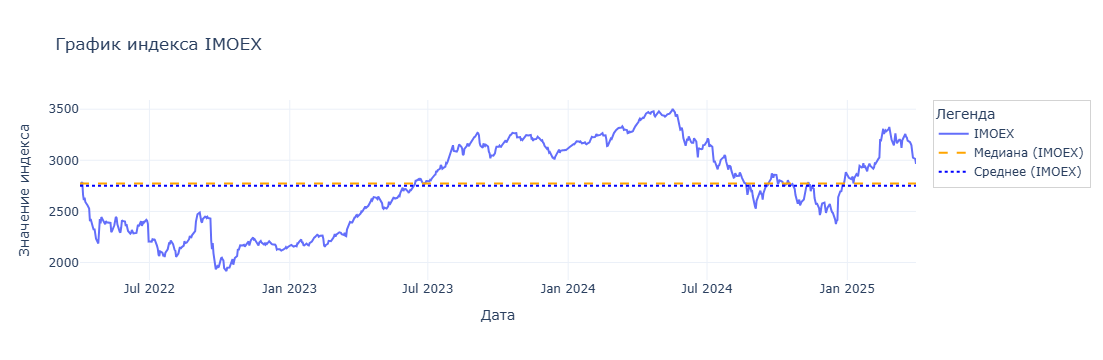

In [348]:
plotly_single_feature_IMOEX(df, column='y', title='График индекса IMOEX', save=False)

# Feature Engeneering для численных признаков

## Проверки на стационарность

In [351]:
# Настройки для ACF/PACF графиков
acf_pacf_style = {
    'lines.linewidth': 4,
    'lines.solid_capstyle': 'butt',
    'axes.labelsize': 'large',
    'axes.axisbelow': True,
    'axes.grid': True,
    'axes.linewidth': 3.0,
    'axes.titlesize': 'x-large',
    'grid.linestyle': '-',
    'grid.linewidth': 1.0,
    'xtick.major.size': 0,
    'xtick.minor.size': 0,
    'ytick.major.size': 0,
    'ytick.minor.size': 0,
    'figure.subplot.left': 0.08,
    'figure.subplot.right': 0.95,
    'figure.subplot.bottom': 0.07,
    'figure.figsize': (15, 12),  # переопределяется при вызове
    'figure.autolayout': True,
    'figure.dpi': 300,
    'font.size': 24.0
}

# Функция для построения ACF и PACF
def plot_acf_pacf(series, lags=40, figsize=(15, 12), title_prefix=""):
    """
    Рисует ACF и PACF графики с локальными параметрами оформления.
    """
    with plt.rc_context(acf_pacf_style):
        fig, ax = plt.subplots(2, 1, figsize=figsize)
        
        tsaplots.plot_acf(series.dropna(), ax=ax[0], lags=lags)
        ax[0].set_title(f"{title_prefix} ACF")
        ax[0].set_ylim(-1.05, 1.05)

        tsaplots.plot_pacf(series.dropna(), ax=ax[1], lags=lags)
        ax[1].set_title(f"{title_prefix} PACF")
        ax[1].set_ylim(-1.05, 1.05)

        plt.show()

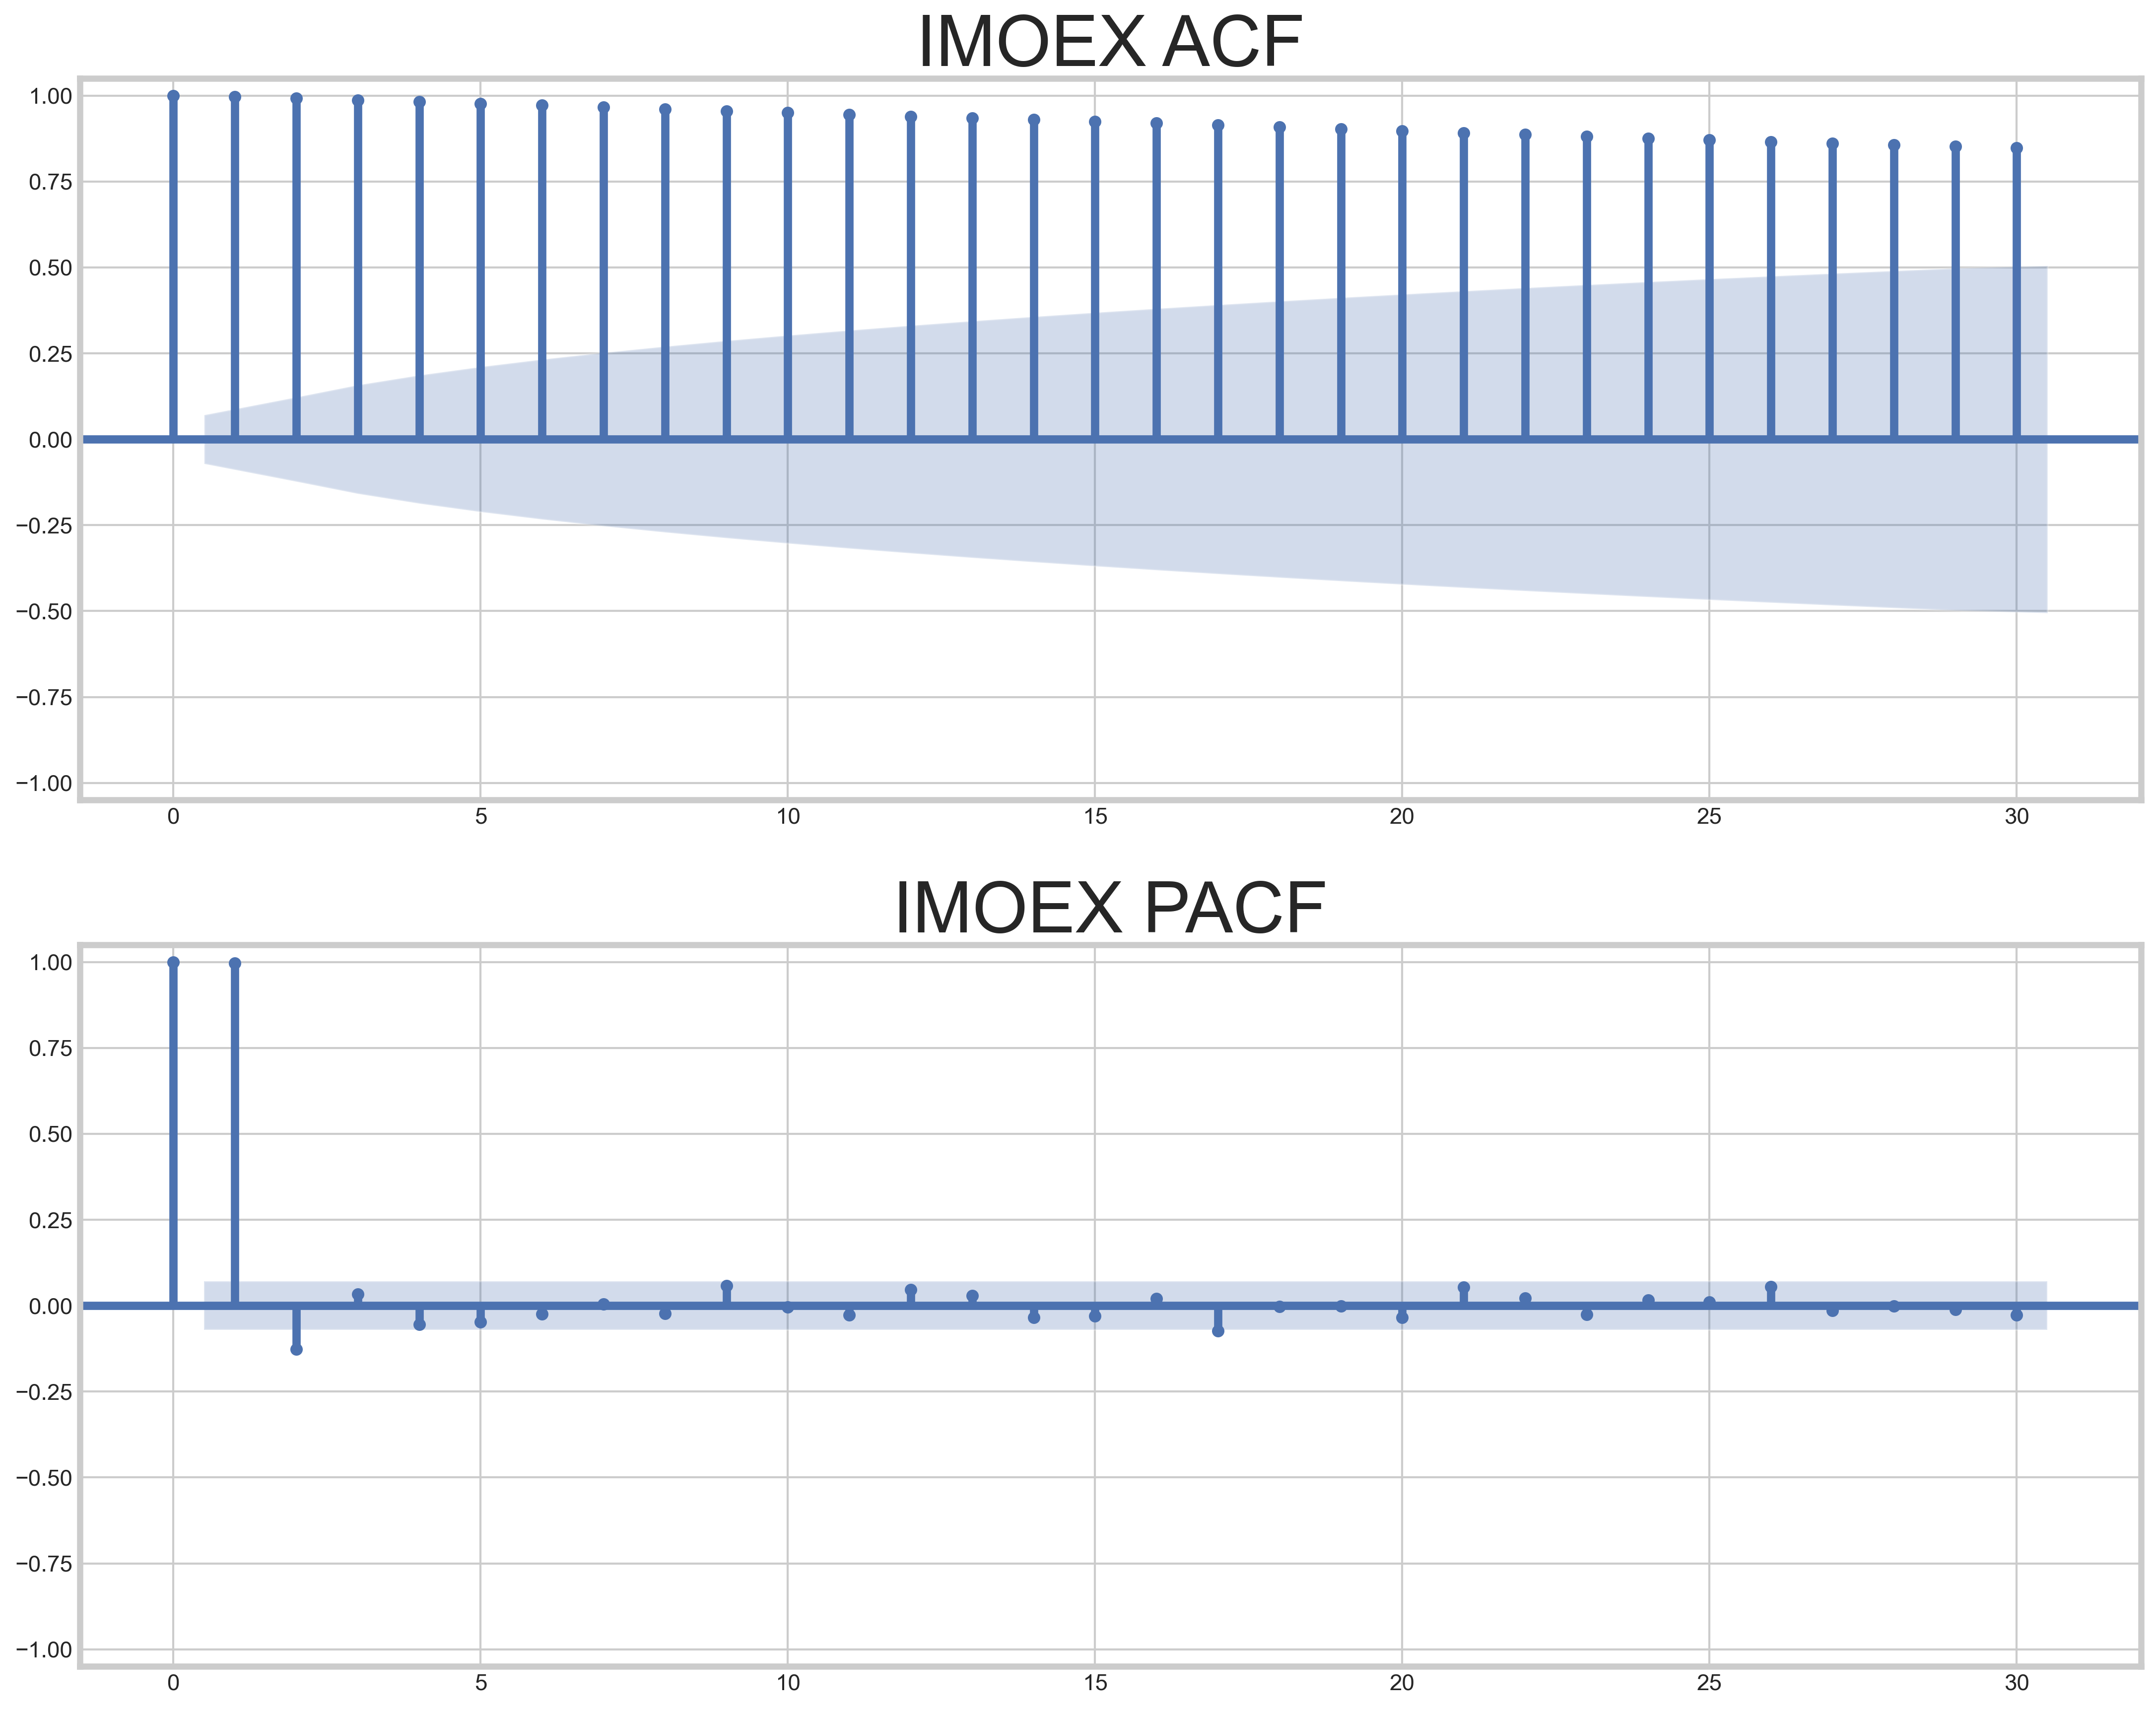

In [352]:
# Построить ACF/PACF
plot_acf_pacf(df['y'], lags=30, title_prefix="IMOEX")

#### Ряд нестационарен

In [354]:
adf_test(df.y) # Дики-Фуллера, тестирует наличие единичного корня
print()
print('-------------------------------------------------------------------------')
print()
kpss_test(df.y, regression='c') # проверяет тренд - тренд-стационарность, то есть, наличие или отсутствие тренда

ADF Test (Augmented Dickey-Fuller)
H0: Временной ряд нестационарен (есть единичный корень)
H1: Временной ряд стационарен

Test Statistic                 -1.271
p-value                         0.643
# Lags Used                     1.000
Number of Observations Used   760.000
Critical Value (1%)            -3.439
Critical Value (5%)            -2.865
Critical Value (10%)           -2.569
dtype: float64

Интерпретация:
p-value = 0.6425 >= 0.05 => Не отклоняем H0: ряд считается нестационарным.

-------------------------------------------------------------------------

KPSS Test (regression='c')
H0: Временной ряд тренд-стационарен
H1: Временной ряд тренд-нестационарен

Test Statistic           2.448
p-value                  0.010
Lags Used               17.000
Critical Value (10%)     0.347
Critical Value (5%)      0.463
Critical Value (2.5%)    0.574
Critical Value (1%)      0.739
dtype: float64

Интерпретация:
p-value = 0.0100 < 0.05 => Отклоняем H0: ряд считается тренд-нестационарным.


C:\Users\smirn\AppData\Local\Temp\ipykernel_10476\2598901476.py:34: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




#### Вывод: ряд нестационарен и тренд-нестационарен

#### Дифференцируем

In [357]:
# Вычисление первого дифференцирования
df['y_diff'] = df['y'].diff()

# Удаление строк с NaN после дифференцирования
df = df.dropna(subset=['y_diff'])

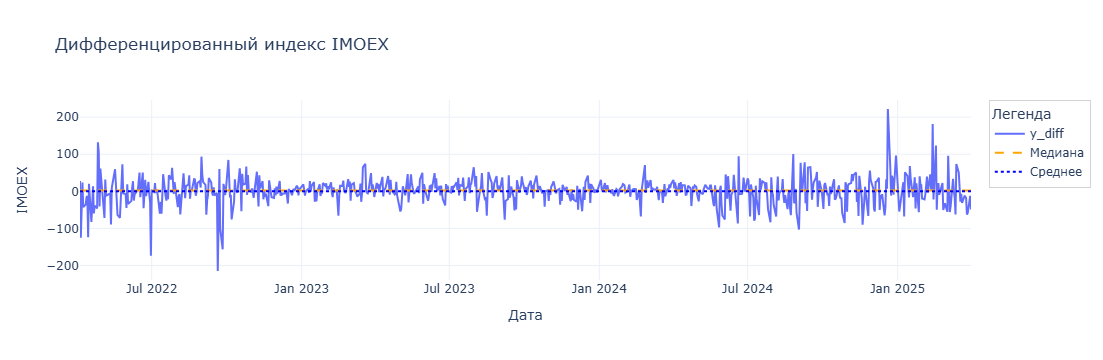

In [358]:
plotly_single_feature(df, column='y_diff', title='Дифференцированный индекс IMOEX', yaxis_title='IMOEX')

In [359]:
adf_test(df.y_diff) # Дики-Фуллера, тестирует наличие единичного корня
print()
print('-------------------------------------------------------------------------')
print()
kpss_test(df.y_diff, regression='c') # проверяет тренд - тренд-стационарность, то есть, наличие или отсутствие тренда

ADF Test (Augmented Dickey-Fuller)
H0: Временной ряд нестационарен (есть единичный корень)
H1: Временной ряд стационарен

Test Statistic                -24.398
p-value                         0.000
# Lags Used                     0.000
Number of Observations Used   760.000
Critical Value (1%)            -3.439
Critical Value (5%)            -2.865
Critical Value (10%)           -2.569
dtype: float64

Интерпретация:
p-value = 0.0000 < 0.05 => Отклоняем H0: ряд считается стационарным.

-------------------------------------------------------------------------

KPSS Test (regression='c')
H0: Временной ряд тренд-стационарен
H1: Временной ряд тренд-нестационарен

Test Statistic          0.131
p-value                 0.100
Lags Used               6.000
Critical Value (10%)    0.347
Critical Value (5%)     0.463
Critical Value (2.5%)   0.574
Critical Value (1%)     0.739
dtype: float64

Интерпретация:
p-value = 0.1000 ≥ 0.05 => Не отклоняем H0: ряд считается тренд-стационарным.


C:\Users\smirn\AppData\Local\Temp\ipykernel_10476\2598901476.py:34: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




#### Кажется, все получилось!
Есть совсем незначительные пробития без особо выраженной сезонности

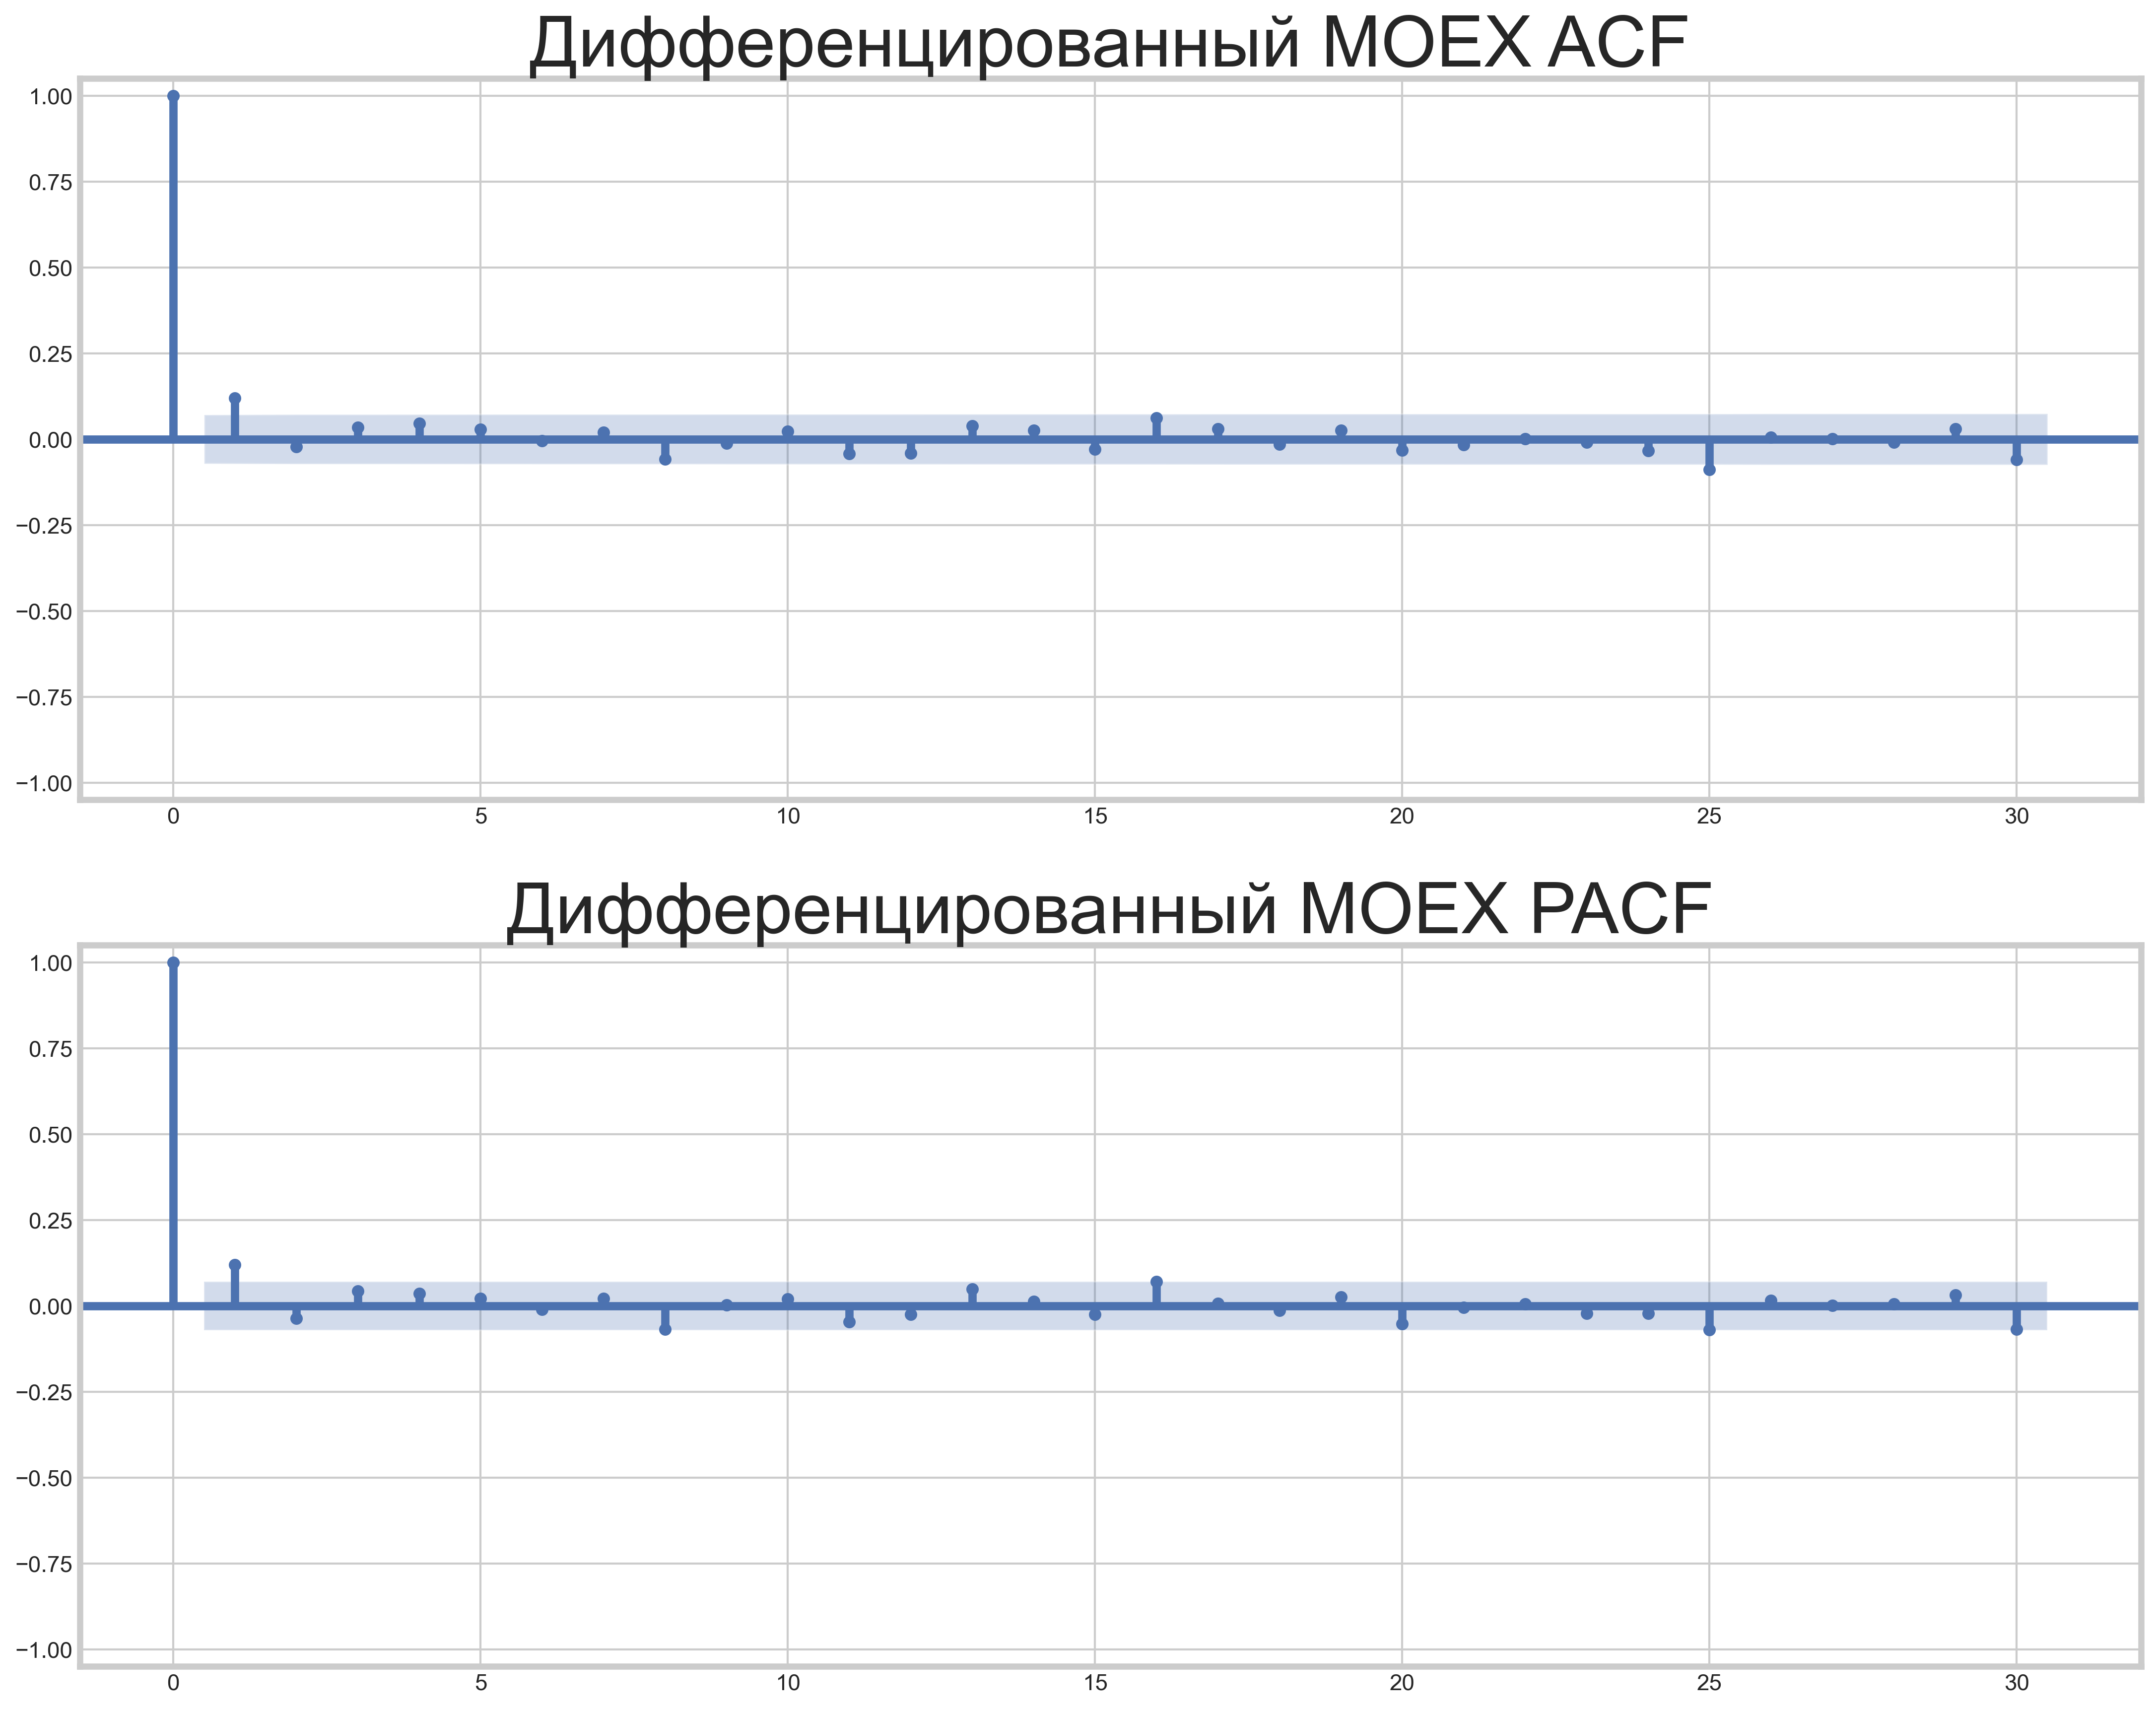

In [361]:
# Построить ACF/PACF
plot_acf_pacf(df['y_diff'], lags=30, title_prefix="Дифференцированный MOEX")

### Параметры модели ARIMAX/SARIMAX (на основе ACF/PACF и анализа сезонности)

| Параметр | Значение | Обоснование |
|----------|----------|-------------|
| p        | 1        | Первый лаг PACF значим => признак AR(1) |
| d        | 1        | Используется 1-е дифференцирование для стационарности |
| q        | 1        | Первый лаг ACF значим => признак MA(1) |
| P        | 0 или 1  | Возможна слабая сезонная автокорреляция по PACF |
| D        | 0 или 1  | Зависит от сезонности ряда, можно протестировать |
| Q        | 0 или 1  | Возможна сезонная MA-компонента по ACF |
| s        | 8        | Предполагаемый сезонный цикл длиной 8 шагов |

**Итог:**  
Рассматриваемая модель: SARIMAX(1, 1, 1) * (0/1, 0/1, 0/1, 5)

**Что попробуем дальше:**
- Начать с модели SARIMAX(1, 1, 1)*(1, 0, 1, 5) или ARIMAX(1, 1, 1)

### Полиномы, логарифмы

In [364]:
df.columns

Index(['cb_rate', 'dxy_price', 'gold_price', 'west_price', 'brent_price',
       'eur_rub_price', 'usd_rub_price', 'moexog_close', 'moexeu_close',
       'moextl_close', 'moexmm_close', 'moexfn_close', 'moexcn_close',
       'moexch_close', 'moexit_close', 'moexre_close', 'moextn_close',
       'vix_price', 'djia_price', 'rvi_price', 'sp500_price', 'nasdaq_price',
       'y', 'ds', 'month', 'day', 'week', 'weekday', 'dayofyear', 'season',
       'quarter', 'holiday_name', 'is_holiday', 'is_holiday_int',
       'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end',
       'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos', 'dayofyear_sin',
       'dayofyear_cos', 'is_friday', 'is_monday', 'weekday_group',
       'week_of_month', 'days_since_start', 'days_until_holiday',
       'days_since_holiday', 'is_long_weekend', 'is_day_before_long_weekend',
       'is_day_after_long_weekend', 'before_holiday_1d', 'after_holiday_1d',
       'before_holiday_2d', 'after_holiday_2

In [365]:
def add_nonlinear_variations(df, columns):
    """
    Добавляет логарифмы, квадраты и кубы для указанных признаков.

    Параметры:
    - df: DataFrame
    - columns: список названий столбцов, к которым применяются преобразования

    Преобразования:
    - log: log1p(abs(x)) - безопасно для отрицательных и нулей
    - squared: x^2
    - cubed: x^3

    Возвращает:
    - DataFrame с новыми признаками
    """
    df = df.copy()

    for col in columns:
        df[f'{col}_log'] = np.log1p(np.abs(df[col]))
        df[f'{col}_squared'] = df[col] ** 2
        df[f'{col}_cubed'] = df[col] ** 3

    return df

In [366]:
# Явно указываем нужные признаки
nonlinear_cols = [
    'dxy_price', 'gold_price', 'west_price', 'brent_price',
    'eur_rub_price', 'usd_rub_price', 'moexog_close', 'moexeu_close',
    'moextl_close', 'moexmm_close', 'moexfn_close', 'moexcn_close',
    'moexch_close', 'moexit_close', 'moexre_close', 'moextn_close',
    'vix_price', 'djia_price', 'rvi_price', 'sp500_price', 'nasdaq_price'
]

# Применяем нелинейные преобразования
df = add_nonlinear_variations(df, nonlinear_cols)

### TRAIN / TEST SPLIT. Фактически, делаем OOT выборку, так как test отделен во времени от train

In [368]:
df = df.reset_index(drop=True)

In [369]:
def split_train_test(df, train_ratio, target_col='y_diff', original_target_col='y', sort_by=None):
    """
    Делит датафрейм на обучающую и тестовую выборки.
    Сохраняет оригинальную метку отдельно и делит её на train/test.
    Исключает обе метки из признаков.

    Параметры:
    - df: исходный DataFrame
    - train_ratio: доля данных для обучения (например, 0.8)
    - target_col: имя целевой переменной для обучения (по умолчанию 'y_diff')
    - original_target_col: имя оригинальной метки (по умолчанию 'y')
    - sort_by: имя временной колонки для сортировки (например, 'ds'), если требуется

    Возвращает:
    - y_original_train, y_original_test: оригинальные значения целевой переменной
    - X_train, y_train, X_test, y_test: обучающие и тестовые признаки и метки
    """
    if sort_by:
        df = df.sort_values(by=sort_by).reset_index(drop=True)

    split_t = int(len(df) * train_ratio)

    y = df[target_col]
    y_original = df[original_target_col]

    y_train = y[:split_t]
    y_test = y[split_t:]

    y_original_train = y_original[:split_t]
    y_original_test = y_original[split_t:]

    drop_cols = set([target_col, original_target_col])
    X = df.drop(columns=drop_cols)
    X_train = X[:split_t]
    X_test = X[split_t:]

    return y_original_train, y_original_test, X_train, y_train, X_test, y_test

In [370]:
y_original_train, y_original_test, X_train, y_train, X_test, y_test = split_train_test(
    df,
    train_ratio=0.8,
    target_col='y_diff',
    original_target_col='y',
    sort_by='ds'
)

In [371]:
y_original_train

0     2787.690
1     2662.790
2     2611.430
3     2635.390
4     2592.720
        ...   
603   2772.710
604   2772.400
605   2726.810
606   2662.580
607   2763.210
Name: y, Length: 608, dtype: float64

In [372]:
y_original_test

608   2733.580
609   2701.690
610   2708.380
611   2649.960
612   2547.020
        ...   
756   3146.310
757   3083.990
758   3025.650
759   3013.360
760   2964.430
Name: y, Length: 153, dtype: float64

## Продолжим Feature Engineering

#### Target-Encoding

In [375]:
X_train

cb_rate  dxy_price  gold_price  west_price  brent_price  eur_rub_price  \
0      0.200     99.000    5185.800     103.290      108.150         91.920   
1      0.200     99.470    5185.420     101.980      106.600         91.611   
2      0.200     99.600    5172.870      96.390      100.810         89.500   
3      0.200     99.750    5162.480      96.050       99.830         86.106   
4      0.200     99.800    4732.040      98.350      101.260         87.296   
..       ...        ...         ...         ...          ...            ...   
603    0.180    101.440    7156.280      75.270       78.850        101.445   
604    0.180    101.040    7273.830      72.760       78.770        102.008   
605    0.180    101.510    7457.140      73.720       78.800        101.453   
606    0.180    100.720    7331.430      75.820       80.340        102.383   
607    0.180    100.850    7312.550      78.400       81.639        102.676   

     usd_rub_price  moexog_close  moexeu_close  moextl_close  moexmm_close  \
0           81.495      7192.490      1477.140      1589.390      9278.810   
1           81.750      6865.910      1426.090      1509.070      9095.940   
2           80.000      6766.870      1427.670      1485.620      9023.810   
3           76.750      6774.050      1436.500      1493.930      9024.140   
4           77.750      6652.840      1427.910      1505.030      8870.510   
..             ...           ...           ...           ...           ...   
603         91.145      7415.790      1728.200      1742.220      6775.240   
604         91.496      7435.190      1734.150      1714.070      6699.530   
605         91.300      7302.740      1690.310      1663.490      6507.620   
606         91.496      7157.650      1617.630      1623.070      6303.100   
607         91.996      7510.900      1669.920      1678.920      6512.770   

     moexfn_close  moexcn_close  moexch_close  moexit_close  moexre_close  \
0        7487.570      6622.470     34738.470      2223.420      7441.640   
1        7062.270      6241.010     33156.480      2095.040      6845.510   
2        6788.570      6177.800     35470.780      2015.430      6634.590   
3        6902.900      6143.590     34764.850      2051.020      6954.560   
4        6720.840      6161.120     33552.690      2052.560      6802.670   
..            ...           ...           ...           ...           ...   
603      9737.020      7643.310     29418.720      3185.770      8250.220   
604      9713.780      7647.340     29051.490      3133.830      8340.030   
605      9589.420      7596.700     28779.500      3080.810      8047.470   
606      9338.650      7453.270     28085.150      3041.150      7861.130   
607      9610.610      7576.880     28579.180      3142.050      8015.440   

     moextn_close  vix_price  djia_price  rvi_price  sp500_price  \
0        1033.290     18.570      17.380     95.910     4582.640   
1         984.290     21.030      19.620     95.520     4525.120   
2         991.440     22.100      20.100     98.000     4481.150   
3        1007.510     21.550      20.040     91.000     4500.210   
4         986.900     21.160      19.530     94.340     4488.280   
..            ...        ...         ...        ...          ...   
603      1634.520     15.880      13.520     31.360     5597.120   
604      1616.500     16.270      14.000     32.700     5620.850   
605      1571.000     17.550      15.370     34.170     5570.640   
606      1510.760     15.860      14.000     38.500     5634.610   
607      1585.770     16.150      14.490     33.940     5616.840   

     nasdaq_price         ds  month  day  week  weekday  dayofyear  season  \
0       14532.550 2022-04-04      4    4    14        0         94  Spring   
1       14204.170 2022-04-05      4    5    14        1         95  Spring   
2       13888.820 2022-04-06      4    6    14        2         96  Spring   
3       13897.300 2022-04-07      4    7    14        3         9

In [376]:
(X_train.dtypes == 'object').sum()

3

In [377]:
# Категориальные признаки
cat_features = [
    'holiday_name',
    'season',
    'weekday_group'
]

# Кодировщик
cb_enc = ce.CatBoostEncoder(cols=cat_features)
cb_enc = cb_enc.fit(X_train[cat_features], y_train)

# Кодируем и присоединяем закодированные фичи
X_train = X_train.join(cb_enc.transform(X_train[cat_features]).add_suffix('_cb'))
X_test = X_test.join(cb_enc.transform(X_test[cat_features]).add_suffix('_cb'))

# Удаляем оригинальные категориальные признаки
X_train = X_train.drop(columns=cat_features)
X_test = X_test.drop(columns=cat_features)

In [378]:
X_train

cb_rate  dxy_price  gold_price  west_price  brent_price  eur_rub_price  \
0      0.200     99.000    5185.800     103.290      108.150         91.920   
1      0.200     99.470    5185.420     101.980      106.600         91.611   
2      0.200     99.600    5172.870      96.390      100.810         89.500   
3      0.200     99.750    5162.480      96.050       99.830         86.106   
4      0.200     99.800    4732.040      98.350      101.260         87.296   
..       ...        ...         ...         ...          ...            ...   
603    0.180    101.440    7156.280      75.270       78.850        101.445   
604    0.180    101.040    7273.830      72.760       78.770        102.008   
605    0.180    101.510    7457.140      73.720       78.800        101.453   
606    0.180    100.720    7331.430      75.820       80.340        102.383   
607    0.180    100.850    7312.550      78.400       81.639        102.676   

     usd_rub_price  moexog_close  moexeu_close  moextl_close  moexmm_close  \
0           81.495      7192.490      1477.140      1589.390      9278.810   
1           81.750      6865.910      1426.090      1509.070      9095.940   
2           80.000      6766.870      1427.670      1485.620      9023.810   
3           76.750      6774.050      1436.500      1493.930      9024.140   
4           77.750      6652.840      1427.910      1505.030      8870.510   
..             ...           ...           ...           ...           ...   
603         91.145      7415.790      1728.200      1742.220      6775.240   
604         91.496      7435.190      1734.150      1714.070      6699.530   
605         91.300      7302.740      1690.310      1663.490      6507.620   
606         91.496      7157.650      1617.630      1623.070      6303.100   
607         91.996      7510.900      1669.920      1678.920      6512.770   

     moexfn_close  moexcn_close  moexch_close  moexit_close  moexre_close  \
0        7487.570      6622.470     34738.470      2223.420      7441.640   
1        7062.270      6241.010     33156.480      2095.040      6845.510   
2        6788.570      6177.800     35470.780      2015.430      6634.590   
3        6902.900      6143.590     34764.850      2051.020      6954.560   
4        6720.840      6161.120     33552.690      2052.560      6802.670   
..            ...           ...           ...           ...           ...   
603      9737.020      7643.310     29418.720      3185.770      8250.220   
604      9713.780      7647.340     29051.490      3133.830      8340.030   
605      9589.420      7596.700     28779.500      3080.810      8047.470   
606      9338.650      7453.270     28085.150      3041.150      7861.130   
607      9610.610      7576.880     28579.180      3142.050      8015.440   

     moextn_close  vix_price  djia_price  rvi_price  sp500_price  \
0        1033.290     18.570      17.380     95.910     4582.640   
1         984.290     21.030      19.620     95.520     4525.120   
2         991.440     22.100      20.100     98.000     4481.150   
3        1007.510     21.550      20.040     91.000     4500.210   
4         986.900     21.160      19.530     94.340     4488.280   
..            ...        ...         ...        ...          ...   
603      1634.520     15.880      13.520     31.360     5597.120   
604      1616.500     16.270      14.000     32.700     5620.850   
605      1571.000     17.550      15.370     34.170     5570.640   
606      1510.760     15.860      14.000     38.500     5634.610   
607      1585.770     16.150      14.490     33.940     5616.840   

     nasdaq_price         ds  month  day  week  weekday  dayofyear  quarter  \
0       14532.550 2022-04-04      4    4    14        0         94        2   
1       14204.170 2022-04-05      4    5    14        1         95        2   
2       13888.820 2022-04-06      4    6    14        2         96        2   
3       13897.300 2022-04-07      4    7    14        3      

#### Данный набор признаков показал себя лучше всего

In [380]:
model_features_arima = [
    'nasdaq_price',
    'eur_rub_price',
    'brent_price',
    'gold_price',
    'day',
    'weekday_sin',
    'weekday',
    'usd_rub_price',
    'moexch_close_squared',
    'moexre_close',
    'moexeu_close_log',
    'days_since_start',
    'dxy_price',
    'weekday_cos',
    'djia_price_squared',
    'days_until_holiday',
    'weekday_group_cb',
    'moextl_close',
    'moexmm_close',
    'dayofyear_cos',
    'vix_price',
    'dayofyear',
    'days_since_holiday',
    'season_cb',
    'rvi_price'
]

# ARIMA

In [382]:
# def calc_optimum_sarima_rmse(y_train, X_train, y_test, X_test,
#                                          max_p, max_P, max_q, max_Q,
#                                          d, D,
#                                          min_s=1, max_s=12):

#     if isinstance(y_train, np.ndarray):
#         y_train = pd.Series(y_train)
#     if isinstance(y_test, np.ndarray):
#         y_test = pd.Series(y_test)

#     ps = range(0, max_p + 1)
#     qs = range(0, max_q + 1)
#     Ps = range(0, max_P + 1)
#     Qs = range(0, max_Q + 1)
#     Ss = [s for s in range(min_s, max_s + 1) if s >= 1]

#     parameters = list(product(ps, qs, Ps, Qs, Ss))

#     best_rmse = float('inf')
#     best_model = None
#     best_param = None
#     results = []

#     print(f"Total combinations to check: {len(parameters)}")

#     for param in tqdm(parameters, desc="Grid search SARIMA"):
#         try:
#             p, q, P, Q, s = param
#             with warnings.catch_warnings():
#                 warnings.simplefilter("ignore")
#                 model = SARIMAX(
#                     y_train,
#                     exog=X_train,
#                     order=(p, d, q),
#                     seasonal_order=(P, D, Q, s),
#                     enforce_stationarity=False,
#                     enforce_invertibility=False
#                 ).fit(disp=False)

#             forecast = model.forecast(steps=len(y_test), exog=X_test)
#             rmse = np.sqrt(mean_squared_error(y_test, forecast))

#             results.append({'params': param, 'rmse': rmse})

#             if rmse < best_rmse:
#                 best_rmse = rmse
#                 best_model = model
#                 best_param = param

#         except Exception as e:
#             print(f"Failed for parameters {param}: {e}")
#             continue

#     print("\nBest model specification:")
#     print(f"order=({best_param[0]}, {d}, {best_param[1]}), seasonal_order=({best_param[2]}, {D}, {best_param[3]}, {best_param[4]})")
#     print(f"Best RMSE: {best_rmse:.4f}")

#     return results, best_model, best_param

# results, final_arima_model, best_param = calc_optimum_sarima_rmse(
#     y_train=np.log(y_original_train),
#     X_train=X_train[model_features_arima],
#     y_test=np.log(y_original_test),
#     X_test=X_test[model_features_arima],
#     max_p=2, 
#     max_P=4, 
#     max_q=1, 
#     max_Q=2,
#     d=1,
#     D=1,
#     min_s=6, 
#     max_s=6
# )

In [383]:
final_arima_model = SARIMAX(
    endog=np.log(y_original_train),
    exog=X_train[model_features_arima],
    order=(1, 1, 0),
    seasonal_order=(3, 1, 2, 6),
    enforce_stationarity=False,
    enforce_invertibility=False
    # cov_type='opg'
    # mle_regression=False
).fit(cov_type='robust')

final_arima_model.summary()

D:\Anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  608
Model:             SARIMAX(1, 1, 0)x(3, 1, [1, 2], 6)   Log Likelihood                2069.496
Date:                                Sun, 25 May 2025   AIC                          -4074.992
Time:                                        21:21:01   BIC                          -3935.265
Sample:                                             0   HQIC                         -4020.525
                                                - 608                                         
Covariance Type:                               robust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
nasdaq_price          1.071e-06   1.88e-06      0.569      0.569   -2.62e-06    4.76e-06
eur_rub_price            0.0008   2.26e-05     35.152      0.000       0.001       0.001
brent_price          -4.479e-05      0.000     -0.335      0.738      -0.000       0.000
gold_price            9.853e-07    3.7e-06      0.266      0.790   -6.27e-06    8.24e-06
day                  -2.565e-05   3.53e-05     -0.726      0.468   -9.49e-05    4.36e-05
weekday_sin          -9.721e-05   1.68e-05     -5.779      0.000      -0.000   -6.42e-05
weekday                 -0.0007   6.68e-05    -10.198      0.000      -0.001      -0.001
usd_rub_price           -0.0009   1.49e-05    -63.481      0.000      -0.001      -0.001
moexch_close_squared  9.677e-12   9.18e-12      1.054      0.292   -8.32e-12    2.77e-11
moexre_close          7.397e-06   2.78e-06      2.662      0.008    1.95e-06    1.28e-05
moexeu_close_log         0.2096   4.86e-08   4.31e+06      0.000       0.210       0.210
days_since_start        -0.0048    2.8e-05   -171.541      0.000      -0.005      -0.005
dxy_price               -0.0001   4.34e-06    -24.140      0.000      -0.000   -9.63e-05
weekday_cos              0.0030   3.15e-05     94.949      0.000       0.003       0.003
djia_price_squared    1.091e-05   7.79e-06      1.401      0.161   -4.35e-06    2.62e-05
days_until_holiday    2.469e-05   1.88e-05      1.310      0.190   -1.22e-05    6.16e-05
weekday_group_cb        -0.0003   6.94e-05     -4.784      0.000      -0.000      -0.000
moextl_close          4.044e-05   1.37e-05      2.955      0.003    1.36e-05    6.73e-05
moexmm_close           7.95e-05    4.4e-06     18.071      0.000    7.09e-05    8.81e-05
dayofyear_cos           -0.0101   3.11e-08  -3.25e+05      0.000      -0.010      -0.010
vix_price               -0.0003   6.14e-06    -52.355      0.000      -0.000      -0.000
dayofyear            -2.733e-05   5.24e-06     -5.216      0.000   -3.76e-05   -1.71e-05
days_since_holiday   -4.808e-05   1.32e-05     -3.652      0.000   -7.39e-05   -2.23e-05
season_cb               -0.0013   1.79e-07  -7499.469      0.000      -0.001      -0.001
rvi_price               -0.0004      0.000     -2.884      0.004      -0.001      -0.000
ar.L1                    0.1076   1.41e-08   7.65e+06      0.000       0.108       0.108
ar.S.L6                 -0.4143   2.72e-08  -1.52e+07      0.000      -0.414      -0.414
ar.S.L12                 0.0538   5.09e-08   1.06e+06      0.000       0.054       0.054
ar.S.L18                 0.0294   2.53e-08   1.16e+06      0.000       0.029       0.029
ma.S.L6                 -0.4614   6.86e-09  -6.73e+07      0.000      -0.461      -0.461
ma.S.L12                -0.4189   2.55e-08  -1.64e+07      0.000      -0.419      -0.419
sigma2                7.988e-05   5.01e-06     15.936      0.000    7.0


Ljung–Box test (lag=50) p-value: 0.0032


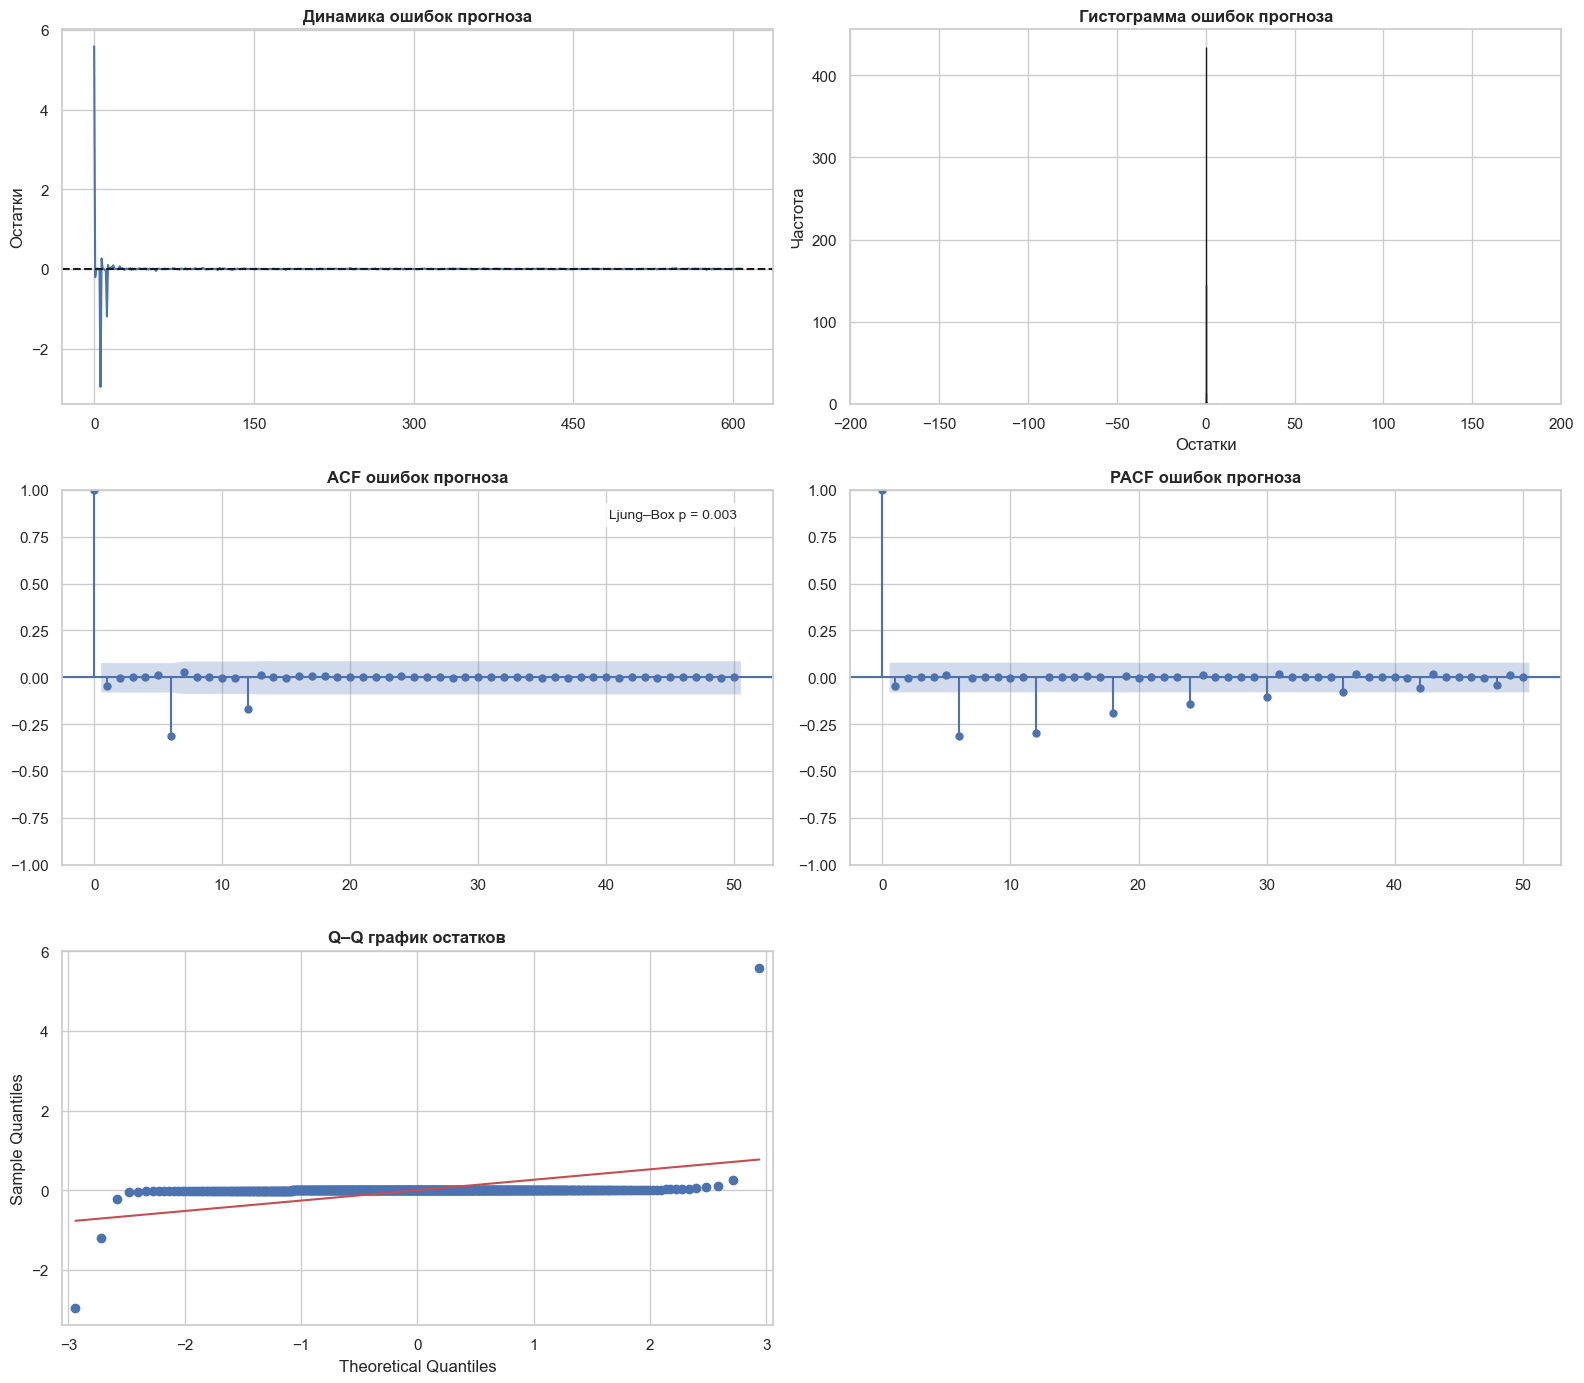

In [384]:
final_arima_model_residuals = pd.Series(final_arima_model.resid, name='resid')
df_diagnostics = pd.DataFrame({
    'date': y_train.index,
    'resid': final_arima_model_residuals.values
})

plot_diagnostics(df_diagnostics, dt_col='date', resid_col='resid', lags=50)

In [385]:
results = check_fit(final_arima_model_residuals.values)
pd.DataFrame([results]).T

0
mean_resids               0.003
mean_t                    0.261
mean_pval                 0.794
stationary_t            -31.058
stationary_pval           0.000
norm_stat                 0.055
norm_pval                 0.000
autocor_pass              False
heteroscedasticity_f      4.884
heteroscedasticity_pval   0.027
check_result              False

#### Визуализируем предсказание

In [387]:
# Предсказание на тестовом наборе
n_test = len(X_test)
arima_forecast = np.exp((final_arima_model.forecast(steps=n_test, 
                                            exog=X_test[model_features_arima].values
                                           )))

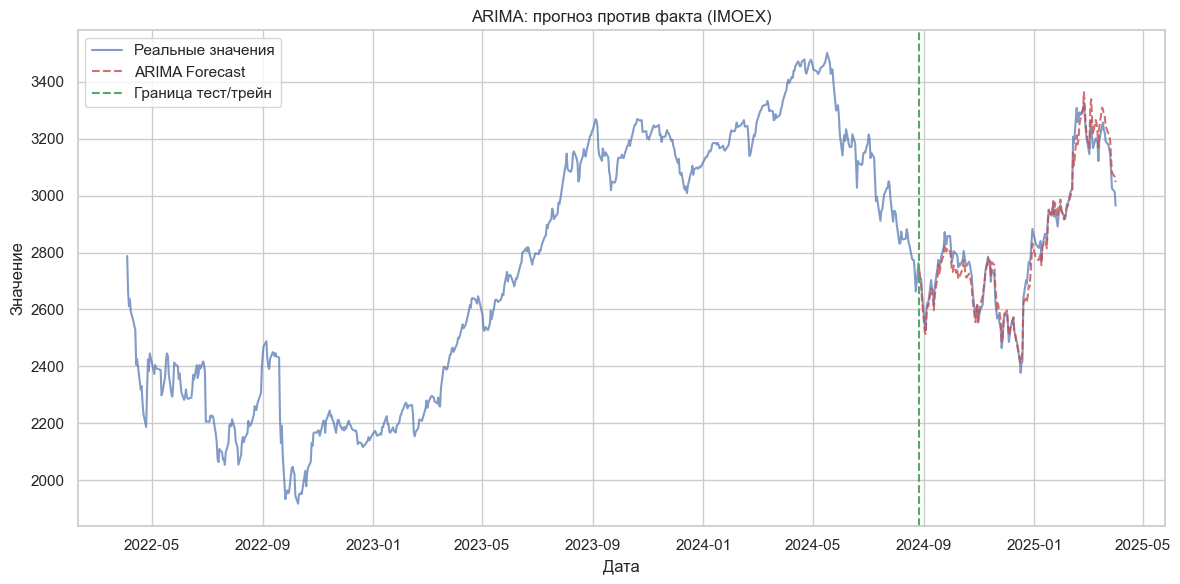

In [388]:
def plot_forecast_with_dates(y_train, y_test, forecast, df, title="Прогноз vs Истина", label="Прогноз"):
    """
    Строит график прогноза vs факта с временной осью по df['ds'].

    Параметры:
    - y_train, y_test: реальные значения (pd.Series или np.ndarray)
    - forecast: прогноз модели на тестовом интервале
    - df: DataFrame, содержащий колонку 'ds' (даты)
    - title: заголовок графика
    - label: подпись прогноза в легенде
    """

    # Даты для оси X
    dates_train = df['ds'].iloc[:len(y_train)]
    dates_test = df['ds'].iloc[len(y_train):len(y_train) + len(y_test)]

    # Объединяем в единый временной ряд
    all_dates = np.concatenate([dates_train, dates_test])
    all_actual = np.concatenate([y_train, y_test])
    all_predictions = np.concatenate([np.full(len(y_train), np.nan), forecast])

    # Построение графика
    plt.figure(figsize=(12, 6))
    plt.plot(all_dates, all_actual, 'b-', alpha=0.7, label='Реальные значения')
    plt.plot(all_dates, all_predictions, 'r--', alpha=0.8, label=label)

    # Вертикальная линия между train и test
    plt.axvline(x=dates_test.iloc[0], color='g', linestyle='--', label='Граница тест/трейн')

    plt.title(title)
    plt.xlabel('Дата')
    plt.ylabel('Значение')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_forecast_with_dates(
    y_train=y_original_train.values,
    y_test=y_original_test.values,
    forecast=arima_forecast,
    df=df,
    title="ARIMA: прогноз против факта (IMOEX)",
    label="ARIMA Forecast"
)


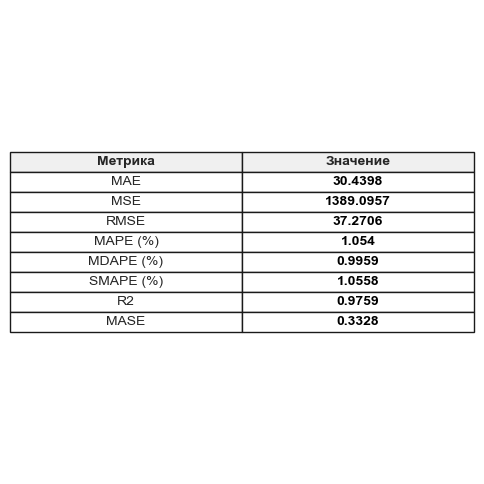

Метрика  Значение
0        MAE    30.440
1        MSE  1389.096
2       RMSE    37.271
3   MAPE (%)     1.054
4  MDAPE (%)     0.996
5  SMAPE (%)     1.056
6         R2     0.976
7       MASE     0.333

In [389]:
metrics_report(y_true=y_original_test, y_pred=arima_forecast, seasonality=6)

# Градиентный бустинг над решающими деревьями

### Feature Engeneering для бустинга

In [392]:
df_gbdt = df

In [393]:
df_gbdt

cb_rate  dxy_price  gold_price  west_price  brent_price  eur_rub_price  \
0      0.200     99.000    5185.800     103.290      108.150         91.920   
1      0.200     99.470    5185.420     101.980      106.600         91.611   
2      0.200     99.600    5172.870      96.390      100.810         89.500   
3      0.200     99.750    5162.480      96.050       99.830         86.106   
4      0.200     99.800    4732.040      98.350      101.260         87.296   
..       ...        ...         ...         ...          ...            ...   
756    0.210    104.550    8141.580      70.050       74.600         90.393   
757    0.210    104.330    8190.120      70.300       74.720         91.264   
758    0.210    104.040    8121.750      69.740       74.690         91.970   
759    0.210    104.210    8223.390      71.870       77.230         89.776   
760    0.210    104.260    8443.120      71.610       77.780         91.196   

     usd_rub_price  moexog_close  moexeu_close  moextl_close  moexmm_close  \
0           81.495      7192.490      1477.140      1589.390      9278.810   
1           81.750      6865.910      1426.090      1509.070      9095.940   
2           80.000      6766.870      1427.670      1485.620      9023.810   
3           76.750      6774.050      1436.500      1493.930      9024.140   
4           77.750      6652.840      1427.910      1505.030      8870.510   
..             ...           ...           ...           ...           ...   
756         84.070      8596.160      1676.320      1670.170      7328.800   
757         84.496      8447.820      1653.480      1649.750      7140.950   
758         84.945      8292.860      1627.740      1592.650      7041.590   
759         82.996      8202.180      1620.280      1587.620      6984.480   
760         84.496      8076.150      1610.700      1581.630      6898.430   

     moexfn_close  moexcn_close  moexch_close  moexit_close  moexre_close  \
0        7487.570      6622.470     34738.470      2223.420      7441.640   
1        7062.270      6241.010     33156.480      2095.040      6845.510   
2        6788.570      6177.800     35470.780      2015.430      6634.590   
3        6902.900      6143.590     34764.850      2051.020      6954.560   
4        6720.840      6161.120     33552.690      2052.560      6802.670   
..            ...           ...           ...           ...           ...   
756     11381.860      8159.850     32643.240      2481.790      6724.000   
757     11084.360      8045.670     31877.370      2421.080      6472.800   
758     10821.810      7983.330     31619.260      2388.520      6346.310   
759     10795.370      7966.320     31376.030      2420.890      6414.660   
760     10730.070      8012.750     31543.290      2402.850      6348.440   

     moextn_close  vix_price  djia_price  rvi_price  sp500_price  \
0        1033.290     18.570      17.380     95.910     4582.640   
1         984.290     21.030      19.620     95.520     4525.120   
2         991.440     22.100      20.100     98.000     4481.150   
3        1007.510     21.550      20.040     91.000     4500.210   
4         986.900     21.160      19.530     94.340     4488.280   
..            ...        ...         ...        ...          ...   
756      1967.960     18.330      16.420     41.750     5712.200   
757      1878.210     18.690      16.740     41.760     5693.310   
758      1835.330     21.650      18.830     45.590     5580.940   
759      1801.600     22.280      19.110     48.170     5611.850   
760      1785.380     21.770      18.680     45.470     5633.070   

     nasdaq_price        y         ds  month  day  week  weekday  dayofyear  \
0       14532.550 2787.690 2022-04-04      4    4    14        0         94   
1       14204.170 2662.790 2022-04-05      4    5    14        1         95   
2       13888.820 2611.430 2022-04-06      4    6    14        2         96   
3       13897.300 2635.390 2022-04-07      4    7    14      

In [394]:
def create_lag_features(
    df,
    columns,
    lags,
    X_test_len,
    drop_na=True,
    in_place=True
):
    """
    Добавляет лаги к нескольким признакам, безопасно и без фрагментации DataFrame.
    """
    if not in_place:
        df = df.copy()

    new_features = {}

    for col in columns:
        safe_col = df[col].copy()
        safe_col.iloc[-X_test_len:] = np.nan  # защита от утечки

        for lag in lags:
            new_col = f'{col}_lag_{lag}'
            new_features[new_col] = safe_col.shift(lag)

    lag_df = pd.DataFrame(new_features, index=df.index)
    df = pd.concat([df, lag_df], axis=1)

    if drop_na:
        df.dropna(subset=lag_df.columns, inplace=True)
        df.reset_index(drop=True, inplace=True)

    return df

In [395]:
numeric_columns = ['y']

lags = [1, 7, 14, 28]

df_gbdt = create_lag_features(
    df=df_gbdt,
    columns=numeric_columns,
    lags=lags,
    X_test_len=153,
    drop_na=False,
    in_place=False
)

In [396]:
df_gbdt

cb_rate  dxy_price  gold_price  west_price  brent_price  eur_rub_price  \
0      0.200     99.000    5185.800     103.290      108.150         91.920   
1      0.200     99.470    5185.420     101.980      106.600         91.611   
2      0.200     99.600    5172.870      96.390      100.810         89.500   
3      0.200     99.750    5162.480      96.050       99.830         86.106   
4      0.200     99.800    4732.040      98.350      101.260         87.296   
..       ...        ...         ...         ...          ...            ...   
756    0.210    104.550    8141.580      70.050       74.600         90.393   
757    0.210    104.330    8190.120      70.300       74.720         91.264   
758    0.210    104.040    8121.750      69.740       74.690         91.970   
759    0.210    104.210    8223.390      71.870       77.230         89.776   
760    0.210    104.260    8443.120      71.610       77.780         91.196   

     usd_rub_price  moexog_close  moexeu_close  moextl_close  moexmm_close  \
0           81.495      7192.490      1477.140      1589.390      9278.810   
1           81.750      6865.910      1426.090      1509.070      9095.940   
2           80.000      6766.870      1427.670      1485.620      9023.810   
3           76.750      6774.050      1436.500      1493.930      9024.140   
4           77.750      6652.840      1427.910      1505.030      8870.510   
..             ...           ...           ...           ...           ...   
756         84.070      8596.160      1676.320      1670.170      7328.800   
757         84.496      8447.820      1653.480      1649.750      7140.950   
758         84.945      8292.860      1627.740      1592.650      7041.590   
759         82.996      8202.180      1620.280      1587.620      6984.480   
760         84.496      8076.150      1610.700      1581.630      6898.430   

     moexfn_close  moexcn_close  moexch_close  moexit_close  moexre_close  \
0        7487.570      6622.470     34738.470      2223.420      7441.640   
1        7062.270      6241.010     33156.480      2095.040      6845.510   
2        6788.570      6177.800     35470.780      2015.430      6634.590   
3        6902.900      6143.590     34764.850      2051.020      6954.560   
4        6720.840      6161.120     33552.690      2052.560      6802.670   
..            ...           ...           ...           ...           ...   
756     11381.860      8159.850     32643.240      2481.790      6724.000   
757     11084.360      8045.670     31877.370      2421.080      6472.800   
758     10821.810      7983.330     31619.260      2388.520      6346.310   
759     10795.370      7966.320     31376.030      2420.890      6414.660   
760     10730.070      8012.750     31543.290      2402.850      6348.440   

     moextn_close  vix_price  djia_price  rvi_price  sp500_price  \
0        1033.290     18.570      17.380     95.910     4582.640   
1         984.290     21.030      19.620     95.520     4525.120   
2         991.440     22.100      20.100     98.000     4481.150   
3        1007.510     21.550      20.040     91.000     4500.210   
4         986.900     21.160      19.530     94.340     4488.280   
..            ...        ...         ...        ...          ...   
756      1967.960     18.330      16.420     41.750     5712.200   
757      1878.210     18.690      16.740     41.760     5693.310   
758      1835.330     21.650      18.830     45.590     5580.940   
759      1801.600     22.280      19.110     48.170     5611.850   
760      1785.380     21.770      18.680     45.470     5633.070   

     nasdaq_price        y         ds  month  day  week  weekday  dayofyear  \
0       14532.550 2787.690 2022-04-04      4    4    14        0         94   
1       14204.170 2662.790 2022-04-05      4    5    14        1         95   
2       13888.820 2611.430 2022-04-06      4    6    14        2         96   
3       13897.300 2635.390 2022-04-07      4    7    14      

#### От скольлящих окон отказался
### Сплит

In [398]:
y_original_train_gbdt, y_original_test_gbdt, X_train_gbdt, y_train_gbdt, X_test_gbdt, y_test_gbdt = split_train_test(
    df=df_gbdt,
    train_ratio=0.8,
    target_col='y_diff',
    original_target_col='y',
    sort_by='ds'
)

In [399]:
X_train_gbdt

cb_rate  dxy_price  gold_price  west_price  brent_price  eur_rub_price  \
0      0.200     99.000    5185.800     103.290      108.150         91.920   
1      0.200     99.470    5185.420     101.980      106.600         91.611   
2      0.200     99.600    5172.870      96.390      100.810         89.500   
3      0.200     99.750    5162.480      96.050       99.830         86.106   
4      0.200     99.800    4732.040      98.350      101.260         87.296   
..       ...        ...         ...         ...          ...            ...   
603    0.180    101.440    7156.280      75.270       78.850        101.445   
604    0.180    101.040    7273.830      72.760       78.770        102.008   
605    0.180    101.510    7457.140      73.720       78.800        101.453   
606    0.180    100.720    7331.430      75.820       80.340        102.383   
607    0.180    100.850    7312.550      78.400       81.639        102.676   

     usd_rub_price  moexog_close  moexeu_close  moextl_close  moexmm_close  \
0           81.495      7192.490      1477.140      1589.390      9278.810   
1           81.750      6865.910      1426.090      1509.070      9095.940   
2           80.000      6766.870      1427.670      1485.620      9023.810   
3           76.750      6774.050      1436.500      1493.930      9024.140   
4           77.750      6652.840      1427.910      1505.030      8870.510   
..             ...           ...           ...           ...           ...   
603         91.145      7415.790      1728.200      1742.220      6775.240   
604         91.496      7435.190      1734.150      1714.070      6699.530   
605         91.300      7302.740      1690.310      1663.490      6507.620   
606         91.496      7157.650      1617.630      1623.070      6303.100   
607         91.996      7510.900      1669.920      1678.920      6512.770   

     moexfn_close  moexcn_close  moexch_close  moexit_close  moexre_close  \
0        7487.570      6622.470     34738.470      2223.420      7441.640   
1        7062.270      6241.010     33156.480      2095.040      6845.510   
2        6788.570      6177.800     35470.780      2015.430      6634.590   
3        6902.900      6143.590     34764.850      2051.020      6954.560   
4        6720.840      6161.120     33552.690      2052.560      6802.670   
..            ...           ...           ...           ...           ...   
603      9737.020      7643.310     29418.720      3185.770      8250.220   
604      9713.780      7647.340     29051.490      3133.830      8340.030   
605      9589.420      7596.700     28779.500      3080.810      8047.470   
606      9338.650      7453.270     28085.150      3041.150      7861.130   
607      9610.610      7576.880     28579.180      3142.050      8015.440   

     moextn_close  vix_price  djia_price  rvi_price  sp500_price  \
0        1033.290     18.570      17.380     95.910     4582.640   
1         984.290     21.030      19.620     95.520     4525.120   
2         991.440     22.100      20.100     98.000     4481.150   
3        1007.510     21.550      20.040     91.000     4500.210   
4         986.900     21.160      19.530     94.340     4488.280   
..            ...        ...         ...        ...          ...   
603      1634.520     15.880      13.520     31.360     5597.120   
604      1616.500     16.270      14.000     32.700     5620.850   
605      1571.000     17.550      15.370     34.170     5570.640   
606      1510.760     15.860      14.000     38.500     5634.610   
607      1585.770     16.150      14.490     33.940     5616.840   

     nasdaq_price         ds  month  day  week  weekday  dayofyear  season  \
0       14532.550 2022-04-04      4    4    14        0         94  Spring   
1       14204.170 2022-04-05      4    5    14        1         95  Spring   
2       13888.820 2022-04-06      4    6    14        2         96  Spring   
3       13897.300 2022-04-07      4    7    14        3         9

### Encoding

In [401]:
# Категориальные признаки
cat_features = [
    'holiday_name',
    'season',
    'weekday_group'
]

# Кодировщик
cb_enc = ce.CatBoostEncoder(cols=cat_features)
cb_enc = cb_enc.fit(X_train_gbdt[cat_features], y_train_gbdt)

# Кодируем и присоединяем закодированные фичи
X_train_gbdt = X_train_gbdt.join(cb_enc.transform(X_train_gbdt[cat_features]).add_suffix('_cb'))
X_test_gbdt = X_test_gbdt.join(cb_enc.transform(X_test_gbdt[cat_features]).add_suffix('_cb'))

# Удаляем оригинальные категориальные признаки
X_train_gbdt = X_train_gbdt.drop(columns=cat_features)
X_test_gbdt = X_test_gbdt.drop(columns=cat_features)

In [402]:
columns_gbdt = list(X_train_gbdt.columns.difference(['ds']))
model_features_gbdt = columns_gbdt
X_train_gbdt[model_features_gbdt]

after_holiday_14d  after_holiday_1d  after_holiday_2d  after_holiday_3d  \
0                    0                 0                 0                 0   
1                    0                 0                 0                 0   
2                    0                 0                 0                 0   
3                    0                 0                 0                 0   
4                    0                 0                 0                 0   
..                 ...               ...               ...               ...   
603                  0                 0                 0                 0   
604                  0                 0                 0                 0   
605                  0                 0                 0                 0   
606                  0                 0                 0                 0   
607                  0                 0                 0                 0   

     after_holiday_7d  before_holiday_14d  before_holiday_1d  \
0                   0                   0                  0   
1                   0                   0                  0   
2                   0                   0                  0   
3                   0                   0                  0   
4                   0                   0                  0   
..                ...                 ...                ...   
603                 0                   0                  0   
604                 0                   0                  0   
605                 0                   0                  0   
606                 0                   0                  0   
607                 0                   0                  0   

     before_holiday_2d  before_holiday_3d  before_holiday_7d  brent_price  \
0                    0                  0                  0      108.150   
1                    0                  0                  0      106.600   
2                    0                  0                  0      100.810   
3                    0                  0                  0       99.830   
4                    0                  0                  0      101.260   
..                 ...                ...                ...          ...   
603                  0                  0                  0       78.850   
604                  0                  0                  0       78.770   
605                  0                  0                  0       78.800   
606                  0                  0                  0       80.340   
607                  0                  0                  0       81.639   

     brent_price_cubed  brent_price_log  brent_price_squared  cb_rate  day  \
0          1264968.093            4.693            11696.423    0.200    4   
1          1211355.496            4.678            11363.560    0.200    5   
2          1024497.361            4.623            10162.656    0.200    6   
3           994908.665            4.613             9966.029    0.200    7   
4          1038278.280            4.628            10253.588    0.200    8   
..                 ...              ...                  ...      ...  ...   
603         490235.879            4.380             6217.322    0.180   20   
604         488745.235            4.379             6204.713    0.180   21   
605         489303.872            4.380             6209.440    0.180   22   
606         518555.783            4.399             6454.516    0.180   23   
607         544125.443            4.414             6664.988    0.180   26   

     dayofyear  dayofyear_cos  dayofyear_sin  days_since_holiday  \
0           94         -0.047          0.999                  27   
1           95         -0.065          0.998                  28   
2           96         -0.082          0.997                  29   
3           97         -0.099          0.995                  30   
4           98         -0.116          0.993                  31   
..   

In [403]:
def calculate_shap_feature_importance(
    X_train: pd.DataFrame,
    y_train: Union[pd.Series, np.ndarray],
    X_shap: Optional[pd.DataFrame] = None,
    y_shap: Optional[Union[pd.Series, np.ndarray]] = None,
    model_params: Optional[dict] = None,
    max_display: int = 30,
    plot: bool = True,
    sample_size: int = 1000,
    target_name: Optional[str] = None,
    plot_type: str = "bar",
    cat_features: Optional[list] = None,
    sampling_strategy: str = "last",  # or "random"
    shap_mode: str = "interventional"  # or "tree_path_dependent"
) -> tuple[pd.DataFrame, np.ndarray]:
    """
    Fits a CatBoostRegressor on X_train/y_train and computes SHAP values on X_shap.
    Supports interventional mode for more accurate SHAP values on correlated time series data.
    """

    assert shap_mode in ["tree_path_dependent", "interventional"], \
        "shap_mode must be 'tree_path_dependent' or 'interventional'"

    assert isinstance(X_train, pd.DataFrame), "X_train must be a pandas DataFrame"
    assert isinstance(y_train, (pd.Series, np.ndarray)), "y_train must be Series or ndarray"
    assert X_train.shape[0] == len(y_train), "X_train and y_train must have the same number of samples"

    if model_params is None:
        model_params = {
            'iterations': 1000,
            'learning_rate': 0.1,
            'depth': 5, 
            'random_seed': 42,
            'verbose': False,
            'task_type': 'CPU'
        }

    if X_shap is None:
        X_shap = X_train.copy()
        y_shap = y_train

    if X_shap.shape[0] > sample_size:
        warnings.warn(
            f"X_shap contains {X_shap.shape[0]} rows. Sampling {sample_size} rows for SHAP.",
            UserWarning
        )
        if sampling_strategy == "last":
            X_sample = X_shap.iloc[-sample_size:].copy()
            y_sample = y_shap[-sample_size:] if isinstance(y_shap, (pd.Series, np.ndarray)) else y_shap.iloc[-sample_size:]
        elif sampling_strategy == "random":
            X_sample = X_shap.sample(n=sample_size, random_state=42)
            y_sample = y_shap[X_sample.index]
        else:
            raise ValueError(f"Unknown sampling_strategy: {sampling_strategy}")
    else:
        X_sample = X_shap.copy()
        y_sample = y_shap

    model = CatBoostRegressor(**model_params)
    model.fit(X_train, y_train, cat_features=cat_features)

    if shap_mode == "interventional":
        explainer = shap.TreeExplainer(model, data=X_train, feature_perturbation="interventional")
    else:
        explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")

    shap_values = explainer.shap_values(X_sample)

    if isinstance(shap_values, list):
        if len(shap_values) > 1:
            warnings.warn("Multiple outputs detected. Using the first output.", UserWarning)
        shap_values = shap_values[0]

    assert shap_values.shape[1] == X_sample.shape[1], \
        "Mismatch between SHAP values and feature dimensions."

    # Plot
    if plot:
        title = f"SHAP summary plot{' for ' + target_name if target_name else ''}"
        print(title)
        shap.summary_plot(
            shap_values,
            X_sample,
            max_display=max_display,
            plot_type=plot_type if plot_type == "beeswarm" else "bar",
            show=False
        )
        plt.show()

    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    shap_df = pd.DataFrame({
        'feature': X_sample.columns,
        'mean_abs_shap': mean_abs_shap
    }).sort_values(by='mean_abs_shap', ascending=False).reset_index(drop=True)

    return shap_df, shap_values

SHAP summary plot for IMOEX


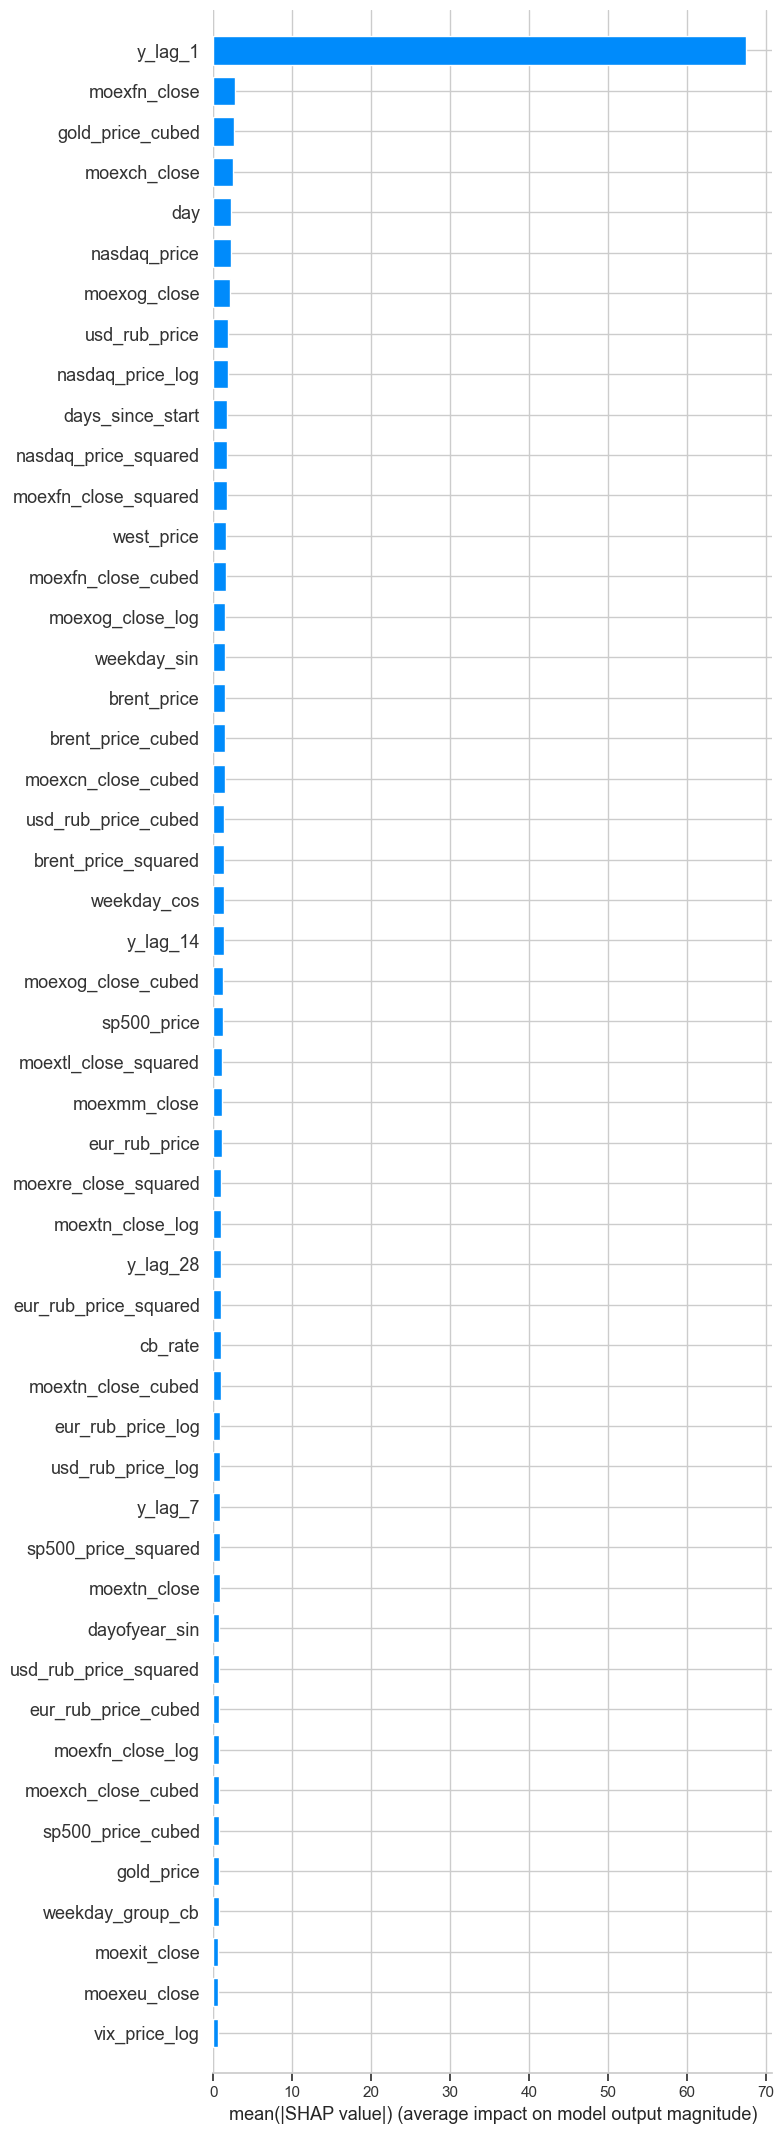

In [404]:
shap_df, shap_values = calculate_shap_feature_importance(
    X_train=X_train_gbdt[model_features_gbdt],
    y_train=y_train_gbdt,
    X_shap=X_test_gbdt[model_features_gbdt],
    y_shap=y_test_gbdt,
    max_display=50,
    target_name='IMOEX',
    sampling_strategy='last',
    shap_mode='interventional'
)

In [405]:
model_features_gbdt = list(shap_df[shap_df['mean_abs_shap'] > 0.1]['feature'])

In [406]:
model_features_gbdt

['y_lag_1',
 'moexfn_close',
 'gold_price_cubed',
 'moexch_close',
 'day',
 'nasdaq_price',
 'moexog_close',
 'usd_rub_price',
 'nasdaq_price_log',
 'days_since_start',
 'nasdaq_price_squared',
 'moexfn_close_squared',
 'west_price',
 'moexfn_close_cubed',
 'moexog_close_log',
 'weekday_sin',
 'brent_price',
 'brent_price_cubed',
 'moexcn_close_cubed',
 'usd_rub_price_cubed',
 'brent_price_squared',
 'weekday_cos',
 'y_lag_14',
 'moexog_close_cubed',
 'sp500_price',
 'moextl_close_squared',
 'moexmm_close',
 'eur_rub_price',
 'moexre_close_squared',
 'moextn_close_log',
 'y_lag_28',
 'eur_rub_price_squared',
 'cb_rate',
 'moextn_close_cubed',
 'eur_rub_price_log',
 'usd_rub_price_log',
 'y_lag_7',
 'sp500_price_squared',
 'moextn_close',
 'dayofyear_sin',
 'usd_rub_price_squared',
 'eur_rub_price_cubed',
 'moexfn_close_log',
 'moexch_close_cubed',
 'sp500_price_cubed',
 'gold_price',
 'weekday_group_cb',
 'moexit_close',
 'moexeu_close',
 'vix_price_log',
 'moexmm_close_squared',
 'moe

### Функции для градиентного бустинга

In [408]:
def visualize_time_series_cv(cv_results, n_splits, time_col=None):
    """
    Функция для визуализации результатов кросс-валидации временных рядов

    Параметры:
    cv_results - словарь с результатами кросс-валидации
    n_splits - количество разбиений
    time_col - название столбца с временной меткой (если None, используется индекс)
    """
    # Настраиваем стиль графиков
    sns.set(style="whitegrid")

    # 1. График MSE по разбиениям
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, n_splits+1), cv_results['fold_mse'], color='skyblue')
    plt.axhline(y=np.mean(cv_results['fold_mse']), color='r', linestyle='-',
               label=f'Среднее: {np.mean(cv_results["fold_mse"]):.4f}')
    plt.title('MSE по разбиениям временного ряда')
    plt.xlabel('Номер разбиения')
    plt.ylabel('MSE')
    plt.xticks(range(1, n_splits+1))
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2. Визуализация разбиений временного ряда
    if time_col is not None and 'fold_timestamps' in cv_results:
        plt.figure(figsize=(12, 8))

        # Получаем все временные метки
        all_timestamps = cv_results['train_timestamps']

        # Создаем цветовую палитру для разбиений
        colors = plt.cm.tab10(np.linspace(0, 1, n_splits))

        for i, (train_indices, test_indices) in enumerate(zip(cv_results['fold_train_indices'], cv_results['fold_test_indices'])):
            # Получаем временные метки для этого разбиения
            train_times = cv_results['fold_timestamps'][i]['train']
            test_times = cv_results['fold_timestamps'][i]['test']

            # Находим минимальную и максимальную временные метки
            min_time = min(train_times) if len(train_times) > 0 else min(test_times)
            max_time = max(test_times) if len(test_times) > 0 else max(train_times)

            # Рисуем горизонтальные линии для обучающей и тестовой выборок
            plt.plot([min_time, max_time], [i+0.2, i+0.2], 'o-', color=colors[i],
                    label=f'Разбиение {i+1}' if i == 0 else "", linewidth=0.4)

            # Отмечаем обучающую и тестовую выборки
            plt.scatter(train_times, [i+0.2]*len(train_times), marker='o', color=colors[i], alpha=0.5)
            plt.scatter(test_times, [i+0.2]*len(test_times), marker='x', color=colors[i], s=50)

        # Добавляем легенду
        plt.plot([], [], 'o', color='gray', label='Обучающая выборка')
        plt.plot([], [], 'x', color='gray', label='Тестовая выборка')

        plt.title('Схема разбиений временного ряда')
        plt.xlabel('Временная метка')
        plt.ylabel('Номер разбиения')
        plt.yticks(np.arange(0.2, n_splits+0.2, 1), [f'Разбиение {i+1}' for i in range(n_splits)])
        plt.legend()
        plt.grid(True)
        plt.show()

    # 3. Сравнение предсказаний и реальных значений на тренировочных данных
    plt.figure(figsize=(10, 6))

    # Если есть временные метки, используем их для оси X
    if time_col is not None and 'train_timestamps' in cv_results:
        plt.scatter(cv_results['train_timestamps'], cv_results['train_actual'], alpha=0.5, label='Реальные значения')
        plt.scatter(cv_results['train_timestamps'], cv_results['train_predictions'], alpha=0.5, label='Предсказания')
        plt.title('Предсказания vs Реальные значения (Тренировочные данные)')
        plt.xlabel('Временная метка')
    else:
        plt.scatter(range(len(cv_results['train_actual'])), cv_results['train_actual'], alpha=0.5, label='Реальные значения')
        plt.scatter(range(len(cv_results['train_predictions'])), cv_results['train_predictions'], alpha=0.5, label='Предсказания')
        plt.title('Предсказания vs Реальные значения (Тренировочные данные)')
        plt.xlabel('Индекс')

    plt.ylabel('Значение')
    plt.legend()
    plt.grid(True)
    plt.show()

        # 4. Сравнение предсказаний и реальных значений на тестовых данных
    plt.figure(figsize=(10, 6))

    # Если есть временные метки, используем их для оси X
    if time_col is not None and 'test_timestamps' in cv_results:
        plt.scatter(cv_results['test_timestamps'], cv_results['test_actual'], alpha=0.5, label='Реальные значения')
        plt.scatter(cv_results['test_timestamps'], cv_results['test_predictions'], alpha=0.5, label='Предсказания')
        plt.title('Предсказания vs Реальные значения (Тестовые данные)')
        plt.xlabel('Временная метка')
    else:
        plt.scatter(range(len(cv_results['test_actual'])), cv_results['test_actual'], alpha=0.5, label='Реальные значения')
        plt.scatter(range(len(cv_results['test_predictions'])), cv_results['test_predictions'], alpha=0.5, label='Предсказания')
        plt.title('Предсказания vs Реальные значения (Тестовые данные)')
        plt.xlabel('Индекс')

    plt.ylabel('Значение')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 5. Если есть OOT данные, визуализируем их
    if cv_results['oot_predictions'] is not None:
        plt.figure(figsize=(10, 6))

        # Если есть временные метки, используем их для оси X
        if time_col is not None and 'oot_timestamps' in cv_results:
            plt.scatter(cv_results['oot_timestamps'], cv_results['oot_actual'], alpha=0.5, label='Реальные значения')
            plt.scatter(cv_results['oot_timestamps'], cv_results['oot_predictions'], alpha=0.5, label='Предсказания')
            plt.title('Предсказания vs Реальные значения (OOT данные)')
            plt.xlabel('Временная метка')
        else:
            plt.scatter(range(len(cv_results['oot_actual'])), cv_results['oot_actual'], alpha=0.5, label='Реальные значения')
            plt.scatter(range(len(cv_results['oot_predictions'])), cv_results['oot_predictions'], alpha=0.5, label='Предсказания')
            plt.title('Предсказания vs Реальные значения (OOT данные)')
            plt.xlabel('Индекс')

        plt.ylabel('Значение')
        plt.legend()
        plt.grid(True)
        plt.show()

    # 6. Временной ряд предсказаний и реальных значений
    plt.figure(figsize=(12, 6))

    # Если есть временные метки, создаем временной ряд
    if time_col is not None:
        # Объединяем тренировочные и тестовые данные для визуализации
        all_timestamps = np.concatenate([cv_results['train_timestamps'], cv_results['test_timestamps']])
        all_actual = np.concatenate([cv_results['train_actual'], cv_results['test_actual']])
        all_predictions = np.concatenate([cv_results['train_predictions'], cv_results['test_predictions']])

        # Сортируем по времени
        sort_idx = np.argsort(all_timestamps)
        all_timestamps = all_timestamps[sort_idx]
        all_actual = all_actual[sort_idx]
        all_predictions = all_predictions[sort_idx]

        # Рисуем временной ряд
        plt.plot(all_timestamps, all_actual, 'b-', alpha=0.7, label='Реальные значения')
        plt.plot(all_timestamps, all_predictions, 'r-', alpha=0.7, label='Предсказания')

        # Добавляем вертикальную линию, разделяющую тренировочные и тестовые данные
        split_time = cv_results['test_timestamps'][0]
        plt.axvline(x=split_time, color='g', linestyle='--', label='Граница тест/трейн')

        plt.title('Временной ряд: реальные значения и предсказания')
        plt.xlabel('Временная метка')
    else:
        # Если нет временных меток, используем индексы
        train_size = len(cv_results['train_actual'])
        test_size = len(cv_results['test_actual'])

        plt.plot(range(train_size), cv_results['train_actual'], 'b-', alpha=0.7, label='Реальные значения (трейн)')
        plt.plot(range(train_size), cv_results['train_predictions'], 'r-', alpha=0.7, label='Предсказания (трейн)')

        plt.plot(range(train_size, train_size + test_size), cv_results['test_actual'], 'b-', alpha=0.7, label='Реальные значения (тест)')
        plt.plot(range(train_size, train_size + test_size), cv_results['test_predictions'], 'r-', alpha=0.7, label='Предсказания (тест)')

        # Добавляем вертикальную линию, разделяющую тренировочные и тестовые данные
        plt.axvline(x=train_size, color='g', linestyle='--', label='Граница тест/трейн')

        plt.title('Временной ряд: реальные значения и предсказания')
        plt.xlabel('Индекс')

    plt.ylabel('Значение')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 7. Сравнение MSE на разных наборах данных
    plt.figure(figsize=(10, 6))

    # Собираем метрики для всех наборов данных
    datasets = ['Кросс-валидация', 'Тест']
    mse_values = [cv_results['val_mse'], cv_results['test_mse']]

    if cv_results['oot_mse'] is not None:
        datasets.append('OOT')
        mse_values.append(cv_results['oot_mse'])

    plt.bar(datasets, mse_values, color='skyblue')
    plt.title('Сравнение MSE на разных наборах данных')
    plt.ylabel('MSE')
    plt.grid(True)

    # Добавляем значения MSE над столбцами
    for i, v in enumerate(mse_values):
        plt.text(i, v + 0.01, f'{v:.4f}', ha='center')

    plt.show()

In [409]:
def visualize_residuals(y_true, y_pred, dataset_name=""):
    """
    Функция для визуализации остатков регрессионной модели

    Параметры:
    y_true - истинные значения целевой переменной
    y_pred - предсказанные значения
    dataset_name - название набора данных для заголовков графиков
    """
    # Вычисляем остатки
    residuals = y_true - y_pred

    # Создаем фигуру с подграфиками
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Анализ остатков ({dataset_name})', fontsize=16)

    # 1. График остатков относительно предсказанных значений
    axes[0, 0].scatter(y_pred, residuals, alpha=0.5)
    axes[0, 0].axhline(y=0, color='r', linestyle='-')
    axes[0, 0].set_title('Остатки vs Предсказанные значения')
    axes[0, 0].set_xlabel('Предсказанные значения')
    axes[0, 0].set_ylabel('Остатки')
    axes[0, 0].grid(True)

    # 2. Гистограмма остатков
    axes[0, 1].hist(residuals, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 1].set_title('Гистограмма остатков')
    axes[0, 1].set_xlabel('Остатки')
    axes[0, 1].set_ylabel('Частота')
    axes[0, 1].grid(True)

    # 3. QQ-график для проверки нормальности остатков
    stats.probplot(residuals, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('QQ-график остатков')
    axes[1, 0].grid(True)

    # 4. Предсказанные vs Истинные значения
    axes[1, 1].scatter(y_true, y_pred, alpha=0.5)
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--')
    axes[1, 1].set_title('Предсказанные vs Истинные значения')
    axes[1, 1].set_xlabel('Истинные значения')
    axes[1, 1].set_ylabel('Предсказанные значения')
    axes[1, 1].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [410]:
def time_series_cross_validation(X_train, y_train, X_test, y_test, X_oot=None, y_oot=None,
                                time_col=None, n_splits=5, gap=0, test_size=None,
                                model=None, random_state=42):
    """
    Функция для проведения кросс-валидации временных рядов с отслеживанием MSE и визуализацией остатков

    Параметры:
    X_train - признаки обучающей выборки (pandas DataFrame)
    y_train - целевая переменная обучающей выборки (pandas Series или numpy array)
    X_test - признаки тестовой выборки (pandas DataFrame)
    y_test - целевая переменная тестовой выборки (pandas Series или numpy array)
    X_oot - признаки out-of-time выборки (pandas DataFrame), опционально
    y_oot - целевая переменная out-of-time выборки (pandas Series или numpy array), опционально
    time_col - название столбца с временной меткой (если None, используется индекс)
    n_splits - количество разбиений для кросс-валидации временных рядов
    gap - количество сэмплов между тренировочным и тестовым наборами
    test_size - размер тестового набора для каждого разбиения (если None, используется по умолчанию)
    model - модель машинного обучения (по умолчанию RandomForestRegressor)
    random_state - фиксированное значение для воспроизводимости результатов

    Возвращает:
    cv_results - словарь с результатами кросс-валидации
    final_model - обученная модель на всех тренировочных данных
    """

    # Проверка входных данных
    if not isinstance(X_train, pd.DataFrame):
        raise TypeError("X_train должен быть pandas DataFrame")

    if not isinstance(X_test, pd.DataFrame):
        raise TypeError("X_test должен быть pandas DataFrame")

    if X_oot is not None and not isinstance(X_oot, pd.DataFrame):
        raise TypeError("X_oot должен быть pandas DataFrame")

    # Проверка, что все наборы данных имеют одинаковые колонки
    train_cols = set(X_train.columns)
    test_cols = set(X_test.columns)

    # Если указан time_col, проверяем его наличие
    if time_col is not None:
        if time_col not in X_train.columns:
            raise ValueError(f"Столбец времени '{time_col}' отсутствует в X_train")
        if time_col not in X_test.columns:
            raise ValueError(f"Столбец времени '{time_col}' отсутствует в X_test")
        if X_oot is not None and time_col not in X_oot.columns:
            raise ValueError(f"Столбец времени '{time_col}' отсутствует в X_oot")

        # Удаляем столбец времени из проверки колонок
        train_cols.remove(time_col)
        test_cols.remove(time_col)

    if train_cols != test_cols:
        raise ValueError("Колонки в X_train и X_test должны совпадать (кроме столбца времени)")

    if X_oot is not None:
        oot_cols = set(X_oot.columns)
        if time_col is not None:
            oot_cols.remove(time_col)
        if train_cols != oot_cols:
            raise ValueError("Колонки в X_train и X_oot должны совпадать (кроме столбца времени)")

    # Если модель не задана, используем RandomForestRegressor по умолчанию
    if model is None:
        model = RandomForestRegressor(n_estimators=100, random_state=random_state)

    # Создаем копии данных для работы
    X_train_copy = X_train.copy()
    X_test_copy = X_test.copy()

    # Если указан time_col, сортируем данные по времени
    if time_col is not None:
        X_train_copy = X_train_copy.sort_values(by=time_col).reset_index(drop=True)
        y_train = y_train.iloc[X_train_copy.index] if isinstance(y_train, pd.Series) else y_train[X_train_copy.index]

        X_test_copy = X_test_copy.sort_values(by=time_col).reset_index(drop=True)
        y_test = y_test.iloc[X_test_copy.index] if isinstance(y_test, pd.Series) else y_test[X_test_copy.index]

        if X_oot is not None:
            X_oot = X_oot.sort_values(by=time_col).reset_index(drop=True)
            y_oot = y_oot.iloc[X_oot.index] if isinstance(y_oot, pd.Series) else y_oot[X_oot.index]

    # Инициализируем TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits, gap=gap, test_size=test_size)

    # Словарь для хранения результатов
    cv_results = {
        'train_predictions': np.zeros(len(y_train)),
        'train_actual': y_train,
        'test_predictions': None,
        'test_actual': y_test,
        'oot_predictions': None,
        'oot_actual': y_oot if y_oot is not None else None,
        'fold_mse': [],
        'fold_train_indices': [],
        'fold_test_indices': [],
        'fold_timestamps': [],
        'train_mse': 0,
        'test_mse': 0,
        'oot_mse': 0 if y_oot is not None else None
    }

    # Если указан time_col, сохраняем временные метки
    if time_col is not None:
        cv_results['train_timestamps'] = X_train_copy[time_col].values
        cv_results['test_timestamps'] = X_test_copy[time_col].values
        if X_oot is not None:
            cv_results['oot_timestamps'] = X_oot[time_col].values

    # Удаляем столбец времени из данных для обучения, если он указан
    if time_col is not None:
        X_train_model = X_train_copy.drop(time_col, axis=1)
        X_test_model = X_test_copy.drop(time_col, axis=1)
        if X_oot is not None:
            X_oot_model = X_oot.drop(time_col, axis=1)
    else:
        X_train_model = X_train_copy
        X_test_model = X_test_copy
        if X_oot is not None:
            X_oot_model = X_oot

    # Массивы для хранения предсказаний и истинных значений по фолдам
    fold_train_mse = []
    fold_val_mse = []

    print("Начинаем процесс кросс-валидации временных рядов...")

    # Проходим по всем разбиениям
    for fold, (train_idx, val_idx) in enumerate(tqdm(tscv.split(X_train_model), total=n_splits, desc="Разбиения")):
        # Сохраняем индексы для визуализации
        cv_results['fold_train_indices'].append(train_idx)
        cv_results['fold_test_indices'].append(val_idx)

        # Если указан time_col, сохраняем временные метки для этого фолда
        if time_col is not None:
            cv_results['fold_timestamps'].append({
                'train': X_train_copy.iloc[train_idx][time_col].values,
                'test': X_train_copy.iloc[val_idx][time_col].values
            })

        # Разделяем данные на обучающую и валидационную выборки
        X_fold_train, X_fold_val = X_train_model.iloc[train_idx], X_train_model.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx] if isinstance(y_train, pd.Series) else y_train[train_idx], \
                                  y_train.iloc[val_idx] if isinstance(y_train, pd.Series) else y_train[val_idx]

        # Обучаем модель
        model.fit(X_fold_train, y_fold_train)

        # Делаем предсказания на обучающей и валидационной выборках
        y_fold_train_pred = model.predict(X_fold_train)
        y_fold_val_pred = model.predict(X_fold_val)

        # Сохраняем предсказания для этого фолда
        cv_results['train_predictions'][val_idx] = y_fold_val_pred

        # Вычисляем MSE для этого фолда
        train_mse = mean_squared_error(y_fold_train, y_fold_train_pred)
        val_mse = mean_squared_error(y_fold_val, y_fold_val_pred)

        fold_train_mse.append(train_mse)
        fold_val_mse.append(val_mse)
        cv_results['fold_mse'].append(val_mse)

        print(f"Разбиение {fold+1}/{n_splits}:")
        print(f"  Размер обучающей выборки: {len(train_idx)}")
        print(f"  Размер валидационной выборки: {len(val_idx)}")
        print(f"  MSE на обучающей выборке: {train_mse:.4f}")
        print(f"  MSE на валидационной выборке: {val_mse:.4f}")

    # Вычисляем средние значения MSE
    cv_results['train_mse'] = np.mean(fold_train_mse)
    cv_results['val_mse'] = np.mean(fold_val_mse)

    print(f"\nСредняя MSE на обучающей выборке: {cv_results['train_mse']:.4f}")
    print(f"Средняя MSE на валидационной выборке: {cv_results['val_mse']:.4f}")

    # Обучаем финальную модель на всех тренировочных данных
    print("\nОбучаем финальную модель на всех тренировочных данных...")
    final_model = model.fit(X_train_model, y_train)

    # Делаем предсказания на тестовой выборке
    cv_results['test_predictions'] = final_model.predict(X_test_model)

    # Вычисляем MSE на тестовой выборке
    cv_results['test_mse'] = mean_squared_error(y_test, cv_results['test_predictions'])
    print(f"MSE на тестовой выборке: {cv_results['test_mse']:.4f}")

    # Если есть OOT данные, делаем предсказания на них
    if X_oot is not None and y_oot is not None:
        cv_results['oot_predictions'] = final_model.predict(X_oot_model)
        cv_results['oot_mse'] = mean_squared_error(y_oot, cv_results['oot_predictions'])
        print(f"MSE на OOT выборке: {cv_results['oot_mse']:.4f}")

    # Визуализация результатов
    visualize_time_series_cv(cv_results, n_splits, time_col)

    # Визуализация остатков
    visualize_residuals(y_test, cv_results['test_predictions'], "Тестовая выборка")

    # Если есть OOT данные, визуализируем остатки для них
    if X_oot is not None and y_oot is not None:
        visualize_residuals(y_oot, cv_results['oot_predictions'], "OOT выборка")

    return cv_results, final_model

### Функция для восстановления ряда

In [412]:
def reconstruct_from_diff_preds(diff_preds, y_original_last_train_value):
    """
    Восстанавливает прогноз уровня временного ряда из дифференцированного прогноза.
    
    Parameters:
    -----------
    diff_preds : array-like
        Прогнозные значения разностей (y_diff).
    y_original_last_train_value : float
        Последнее значение исходного (недифференцированного) ряда перед началом прогноза.
    
    Returns:
    --------
    np.ndarray
        Восстановленный прогноз исходного ряда.
    """
    diff_preds = np.array(diff_preds)
    return y_original_last_train_value + np.cumsum(diff_preds)

### Кросс-валидация с восстановлением - подготовка

In [414]:
def reconstruct_cv_results(cv_results, y_original_train, y_original_test):
    """
    Возвращает копию cv_results с восстановленными значениями исходного ряда.
    """
    def reconstruct(diff, last_val):
        return reconstruct_from_diff_preds(diff, last_val)

    cv_results_rec = cv_results.copy()

    # Последнее значение оригинального train-таргета
    last_val = y_original_train.iloc[-1]

    # Восстановление
    cv_results_rec['train_actual'] = reconstruct(cv_results['train_actual'], y_original_train.iloc[0])
    cv_results_rec['train_predictions'] = reconstruct(cv_results['train_predictions'], y_original_train.iloc[0])

    cv_results_rec['test_actual'] = reconstruct(cv_results['test_actual'], last_val)
    cv_results_rec['test_predictions'] = reconstruct(cv_results['test_predictions'], last_val)

    # Если есть OOT - восстанавливаем и его
    if cv_results.get('oot_actual') is not None and cv_results.get('oot_predictions') is not None:
        last_val_test = cv_results_rec['test_actual'][-1]
        cv_results_rec['oot_actual'] = reconstruct(cv_results['oot_actual'], last_val_test)
        cv_results_rec['oot_predictions'] = reconstruct(cv_results['oot_predictions'], last_val_test)

    return cv_results_rec

### График

In [416]:
def time_series_cross_validation(X_train, y_train, X_test, y_test, X_oot=None, y_oot=None,
                                time_col=None, n_splits=5, gap=0, test_size=None,
                                model=None, random_state=42):
    """
    Функция для проведения кросс-валидации временных рядов с отслеживанием MSE и визуализацией остатков

    Параметры:
    X_train - признаки обучающей выборки (pandas DataFrame)
    y_train - целевая переменная обучающей выборки (pandas Series или numpy array)
    X_test - признаки тестовой выборки (pandas DataFrame)
    y_test - целевая переменная тестовой выборки (pandas Series или numpy array)
    X_oot - признаки out-of-time выборки (pandas DataFrame), опционально
    y_oot - целевая переменная out-of-time выборки (pandas Series или numpy array), опционально
    time_col - название столбца с временной меткой (если None, используется индекс)
    n_splits - количество разбиений для кросс-валидации временных рядов
    gap - количество сэмплов между тренировочным и тестовым наборами
    test_size - размер тестового набора для каждого разбиения (если None, используется по умолчанию)
    model - модель машинного обучения (по умолчанию RandomForestRegressor)
    random_state - фиксированное значение для воспроизводимости результатов

    Возвращает:
    cv_results - словарь с результатами кросс-валидации
    final_model - обученная модель на всех тренировочных данных
    """

    # Проверка входных данных
    if not isinstance(X_train, pd.DataFrame):
        raise TypeError("X_train должен быть pandas DataFrame")

    if not isinstance(X_test, pd.DataFrame):
        raise TypeError("X_test должен быть pandas DataFrame")

    if X_oot is not None and not isinstance(X_oot, pd.DataFrame):
        raise TypeError("X_oot должен быть pandas DataFrame")

    # Проверка, что все наборы данных имеют одинаковые колонки
    train_cols = set(X_train.columns)
    test_cols = set(X_test.columns)

    # Если указан time_col, проверяем его наличие
    if time_col is not None:
        if time_col not in X_train.columns:
            raise ValueError(f"Столбец времени '{time_col}' отсутствует в X_train")
        if time_col not in X_test.columns:
            raise ValueError(f"Столбец времени '{time_col}' отсутствует в X_test")
        if X_oot is not None and time_col not in X_oot.columns:
            raise ValueError(f"Столбец времени '{time_col}' отсутствует в X_oot")

        # Удаляем столбец времени из проверки колонок
        train_cols.remove(time_col)
        test_cols.remove(time_col)

    if train_cols != test_cols:
        raise ValueError("Колонки в X_train и X_test должны совпадать (кроме столбца времени)")

    if X_oot is not None:
        oot_cols = set(X_oot.columns)
        if time_col is not None:
            oot_cols.remove(time_col)
        if train_cols != oot_cols:
            raise ValueError("Колонки в X_train и X_oot должны совпадать (кроме столбца времени)")

    # Если модель не задана, используем RandomForestRegressor по умолчанию
    if model is None:
        model = RandomForestRegressor(n_estimators=100, random_state=random_state)

    # Создаем копии данных для работы
    X_train_copy = X_train.copy()
    X_test_copy = X_test.copy()

    # Если указан time_col, сортируем данные по времени
    if time_col is not None:
        X_train_copy = X_train_copy.sort_values(by=time_col).reset_index(drop=True)
        y_train = y_train.iloc[X_train_copy.index] if isinstance(y_train, pd.Series) else y_train[X_train_copy.index]

        X_test_copy = X_test_copy.sort_values(by=time_col).reset_index(drop=True)
        y_test = y_test.iloc[X_test_copy.index] if isinstance(y_test, pd.Series) else y_test[X_test_copy.index]

        if X_oot is not None:
            X_oot = X_oot.sort_values(by=time_col).reset_index(drop=True)
            y_oot = y_oot.iloc[X_oot.index] if isinstance(y_oot, pd.Series) else y_oot[X_oot.index]

    # Инициализируем TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits, gap=gap, test_size=test_size)

    # Словарь для хранения результатов
    cv_results = {
        'train_predictions': np.zeros(len(y_train)),
        'train_actual': y_train,
        'test_predictions': None,
        'test_actual': y_test,
        'oot_predictions': None,
        'oot_actual': y_oot if y_oot is not None else None,
        'fold_mse': [],
        'fold_train_indices': [],
        'fold_test_indices': [],
        'fold_timestamps': [],
        'train_mse': 0,
        'test_mse': 0,
        'oot_mse': 0 if y_oot is not None else None
    }

    # Если указан time_col, сохраняем временные метки
    if time_col is not None:
        cv_results['train_timestamps'] = X_train_copy[time_col].values
        cv_results['test_timestamps'] = X_test_copy[time_col].values
        if X_oot is not None:
            cv_results['oot_timestamps'] = X_oot[time_col].values

    # Удаляем столбец времени из данных для обучения, если он указан
    if time_col is not None:
        X_train_model = X_train_copy.drop(time_col, axis=1)
        X_test_model = X_test_copy.drop(time_col, axis=1)
        if X_oot is not None:
            X_oot_model = X_oot.drop(time_col, axis=1)
    else:
        X_train_model = X_train_copy
        X_test_model = X_test_copy
        if X_oot is not None:
            X_oot_model = X_oot

    # Массивы для хранения предсказаний и истинных значений по фолдам
    fold_train_mse = []
    fold_val_mse = []

    print("Начинаем процесс кросс-валидации временных рядов...")

    # Проходим по всем разбиениям
    for fold, (train_idx, val_idx) in enumerate(tqdm(tscv.split(X_train_model), total=n_splits, desc="Разбиения")):
        # Сохраняем индексы для визуализации
        cv_results['fold_train_indices'].append(train_idx)
        cv_results['fold_test_indices'].append(val_idx)

        # Если указан time_col, сохраняем временные метки для этого фолда
        if time_col is not None:
            cv_results['fold_timestamps'].append({
                'train': X_train_copy.iloc[train_idx][time_col].values,
                'test': X_train_copy.iloc[val_idx][time_col].values
            })

        # Разделяем данные на обучающую и валидационную выборки
        X_fold_train, X_fold_val = X_train_model.iloc[train_idx], X_train_model.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx] if isinstance(y_train, pd.Series) else y_train[train_idx], \
                                  y_train.iloc[val_idx] if isinstance(y_train, pd.Series) else y_train[val_idx]

        # Обучаем модель
        model.fit(X_fold_train, y_fold_train)

        # Делаем предсказания на обучающей и валидационной выборках
        y_fold_train_pred = model.predict(X_fold_train)
        y_fold_val_pred = model.predict(X_fold_val)

        # Сохраняем предсказания для этого фолда
        cv_results['train_predictions'][val_idx] = y_fold_val_pred

        # Вычисляем MSE для этого фолда
        train_mse = mean_squared_error(y_fold_train, y_fold_train_pred)
        val_mse = mean_squared_error(y_fold_val, y_fold_val_pred)

        fold_train_mse.append(train_mse)
        fold_val_mse.append(val_mse)
        cv_results['fold_mse'].append(val_mse)

        print(f"Разбиение {fold+1}/{n_splits}:")
        print(f"  Размер обучающей выборки: {len(train_idx)}")
        print(f"  Размер валидационной выборки: {len(val_idx)}")
        print(f"  MSE на обучающей выборке: {train_mse:.4f}")
        print(f"  MSE на валидационной выборке: {val_mse:.4f}")

    # Вычисляем средние значения MSE
    cv_results['train_mse'] = np.mean(fold_train_mse)
    cv_results['val_mse'] = np.mean(fold_val_mse)

    print(f"\nСредняя MSE на обучающей выборке: {cv_results['train_mse']:.4f}")
    print(f"Средняя MSE на валидационной выборке: {cv_results['val_mse']:.4f}")

    # Обучаем финальную модель на всех тренировочных данных
    print("\nОбучаем финальную модель на всех тренировочных данных...")
    final_model = model.fit(X_train_model, y_train)

    # Делаем предсказания на тестовой выборке
    cv_results['test_predictions'] = final_model.predict(X_test_model)

    # Вычисляем MSE на тестовой выборке
    cv_results['test_mse'] = mean_squared_error(y_test, cv_results['test_predictions'])
    print(f"MSE на тестовой выборке: {cv_results['test_mse']:.4f}")

    # Если есть OOT данные, делаем предсказания на них
    if X_oot is not None and y_oot is not None:
        cv_results['oot_predictions'] = final_model.predict(X_oot_model)
        cv_results['oot_mse'] = mean_squared_error(y_oot, cv_results['oot_predictions'])
        print(f"MSE на OOT выборке: {cv_results['oot_mse']:.4f}")

    # Визуализация результатов
    visualize_time_series_cv(cv_results, n_splits, time_col)

    # Визуализация остатков
    visualize_residuals(y_test, cv_results['test_predictions'], "Тестовая выборка")

    # Если есть OOT данные, визуализируем остатки для них
    if X_oot is not None and y_oot is not None:
        visualize_residuals(y_oot, cv_results['oot_predictions'], "OOT выборка")

    return cv_results, final_model

In [417]:
def time_series_cross_validation(X_train, y_train, X_test, y_test,
                                 X_oot=None, y_oot=None,
                                 y_original_train=None, y_original_test=None, y_original_oot=None,
                                 time_col=None, n_splits=5, gap=0, test_size=None,
                                 model=None, random_state=42):
    """
    Кросс-валидация временных рядов с MSE, визуализацией остатков и восстановлением уровня ряда
    """

    if model is None:
        model = RandomForestRegressor(n_estimators=100, random_state=random_state)

    X_train_copy = X_train.copy()
    X_test_copy = X_test.copy()

    if time_col is not None:
        X_train_copy = X_train_copy.sort_values(by=time_col).reset_index(drop=True)
        y_train = y_train.iloc[X_train_copy.index] if isinstance(y_train, pd.Series) else y_train[X_train_copy.index]

        X_test_copy = X_test_copy.sort_values(by=time_col).reset_index(drop=True)
        y_test = y_test.iloc[X_test_copy.index] if isinstance(y_test, pd.Series) else y_test[X_test_copy.index]

        if X_oot is not None:
            X_oot = X_oot.sort_values(by=time_col).reset_index(drop=True)
            y_oot = y_oot.iloc[X_oot.index] if isinstance(y_oot, pd.Series) else y_oot[X_oot.index]

    tscv = TimeSeriesSplit(n_splits=n_splits, gap=gap, test_size=test_size)

    cv_results = {
        'train_predictions': np.zeros(len(y_train)),
        'train_actual': y_train,
        'test_predictions': None,
        'test_actual': y_test,
        'oot_predictions': None,
        'oot_actual': y_oot if y_oot is not None else None,
        'fold_mse': [],
        'fold_train_indices': [],
        'fold_test_indices': [],
        'fold_timestamps': [],
        'train_mse': 0,
        'test_mse': 0,
        'oot_mse': 0 if y_oot is not None else None
    }

    if time_col is not None:
        cv_results['train_timestamps'] = X_train_copy[time_col].values
        cv_results['test_timestamps'] = X_test_copy[time_col].values
        if X_oot is not None:
            cv_results['oot_timestamps'] = X_oot[time_col].values

    if time_col is not None:
        X_train_model = X_train_copy.drop(time_col, axis=1)
        X_test_model = X_test_copy.drop(time_col, axis=1)
        if X_oot is not None:
            X_oot_model = X_oot.drop(time_col, axis=1)
    else:
        X_train_model = X_train_copy
        X_test_model = X_test_copy
        if X_oot is not None:
            X_oot_model = X_oot

    fold_train_mse = []
    fold_val_mse = []

    print("Начинаем процесс кросс-валидации временных рядов...")

    for fold, (train_idx, val_idx) in enumerate(tqdm(tscv.split(X_train_model), total=n_splits, desc="Разбиения")):
        cv_results['fold_train_indices'].append(train_idx)
        cv_results['fold_test_indices'].append(val_idx)

        if time_col is not None:
            cv_results['fold_timestamps'].append({
                'train': X_train_copy.iloc[train_idx][time_col].values,
                'test': X_train_copy.iloc[val_idx][time_col].values
            })

        X_fold_train, X_fold_val = X_train_model.iloc[train_idx], X_train_model.iloc[val_idx]
        y_fold_train = y_train.iloc[train_idx] if isinstance(y_train, pd.Series) else y_train[train_idx]
        y_fold_val = y_train.iloc[val_idx] if isinstance(y_train, pd.Series) else y_train[val_idx]

        model.fit(X_fold_train, y_fold_train)

        y_fold_train_pred = model.predict(X_fold_train)
        y_fold_val_pred = model.predict(X_fold_val)

        cv_results['train_predictions'][val_idx] = y_fold_val_pred

        train_mse = mean_squared_error(y_fold_train, y_fold_train_pred)
        val_mse = mean_squared_error(y_fold_val, y_fold_val_pred)

        fold_train_mse.append(train_mse)
        fold_val_mse.append(val_mse)
        cv_results['fold_mse'].append(val_mse)

        print(f"Разбиение {fold+1}/{n_splits}:")
        print(f"  Обучающая выборка: {len(train_idx)}, Валидационная выборка: {len(val_idx)}")
        print(f"  MSE (train): {train_mse:.4f}, MSE (val): {val_mse:.4f}")

    cv_results['train_mse'] = np.mean(fold_train_mse)
    cv_results['val_mse'] = np.mean(fold_val_mse)

    print(f"\nСредняя MSE (train): {cv_results['train_mse']:.4f}")
    print(f"Средняя MSE (val): {cv_results['val_mse']:.4f}")

    print("\nФинальное обучение модели...")
    final_model = model.fit(X_train_model, y_train)

    cv_results['test_predictions'] = final_model.predict(X_test_model)
    cv_results['test_mse'] = mean_squared_error(y_test, cv_results['test_predictions'])
    print(f"MSE (test): {cv_results['test_mse']:.4f}")

    if X_oot is not None and y_oot is not None:
        cv_results['oot_predictions'] = final_model.predict(X_oot_model)
        cv_results['oot_mse'] = mean_squared_error(y_oot, cv_results['oot_predictions'])
        print(f"MSE (OOT): {cv_results['oot_mse']:.4f}")

    # === Восстановление и визуализация ===
    if y_original_train is not None and y_original_test is not None:
        from copy import deepcopy
        cv_results_rec = deepcopy(cv_results)

        cv_results_rec['train_actual'] = reconstruct_from_diff_preds(cv_results['train_actual'], y_original_train.iloc[0])
        cv_results_rec['train_predictions'] = reconstruct_from_diff_preds(cv_results['train_predictions'], y_original_train.iloc[0])

        last_val = y_original_train.iloc[-1]
        cv_results_rec['test_actual'] = reconstruct_from_diff_preds(cv_results['test_actual'], last_val)
        cv_results_rec['test_predictions'] = reconstruct_from_diff_preds(cv_results['test_predictions'], last_val)

        if y_original_oot is not None and cv_results['oot_predictions'] is not None:
            last_val_test = cv_results_rec['test_actual'][-1]
            cv_results_rec['oot_actual'] = reconstruct_from_diff_preds(cv_results['oot_actual'], last_val_test)
            cv_results_rec['oot_predictions'] = reconstruct_from_diff_preds(cv_results['oot_predictions'], last_val_test)

        visualize_time_series_cv(cv_results_rec, n_splits, time_col)
        visualize_residuals(cv_results_rec['test_actual'], cv_results_rec['test_predictions'], "Тест (восстановленный)")

        if y_original_oot is not None and cv_results_rec['oot_predictions'] is not None:
            visualize_residuals(cv_results_rec['oot_actual'], cv_results_rec['oot_predictions'], "OOT (восстановленный)")
    else:
        visualize_time_series_cv(cv_results, n_splits, time_col)
        visualize_residuals(y_test, cv_results['test_predictions'], "Тестовая выборка")
        if X_oot is not None and y_oot is not None:
            visualize_residuals(y_oot, cv_results['oot_predictions'], "OOT выборка")

    return cv_results, final_model

### Hyperopt

In [419]:
import time

In [420]:
def run_hyperopt_with_reconstruction(
    X_train, y_train_diff, y_original_train,
    X_test, y_test_diff, y_original_test,
    model_class,
    space,
    n_iter=30,
    random_state=42,
    n_splits_cv=5,
    time_col=None,
    early_stopping_rounds=50
):
    from hyperopt import fmin, tpe, Trials, STATUS_OK
    from sklearn.model_selection import TimeSeriesSplit
    from sklearn.metrics import mean_squared_error
    from tqdm import tqdm
    import pandas as pd
    import numpy as np
    import time
    from copy import deepcopy

    def reconstruct_from_diff_preds(diff_preds, y_original_last_value):
        return y_original_last_value + np.cumsum(diff_preds)

    def get_model_params(params, model_class):
        if model_class.__name__ == 'CatBoostRegressor':
            dct = {
                'iterations': int(params['iterations']),
                'depth': int(params['depth']) if 'depth' in params else 2,
                'learning_rate': params['learning_rate'],
                'l2_leaf_reg': int(params['l2_leaf_reg']),
                'random_strength': params['random_strength'],
                'bagging_temperature': params['bagging_temperature'],
                'random_seed': random_state,
                'verbose': 0,
                'bootstrap_type': params['bootstrap_type'] if 'bootstrap_type' in params else 'Bayesian',
            }
            # subsample только если задан Bernoulli
            if 'subsample' in params and dct['bootstrap_type'] == 'Bernoulli':
                dct['subsample'] = params['subsample']
            return dct
        else:
            raise ValueError("Только CatBoost поддержан в этой функции!")

    log_rows = []
    trials = Trials()
    pbar = tqdm(total=n_iter, desc="Hyperopt", position=0, leave=True)
    iteration = 0

    def objective(params):
        nonlocal iteration
        print(f"\n===> Запуск objective, итерация {iteration + 1} <===", flush=True)
        try:
            model_params = get_model_params(params, model_class)
            print(f"  [Objective] Параметры: {model_params}", flush=True)
            tscv = TimeSeriesSplit(n_splits=n_splits_cv)
            val_scores = []

            for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
                print(f"  [CV] fold {fold+1}: train={len(train_idx)}, val={len(val_idx)}", flush=True)
                t1 = time.time()
                model = model_class(**model_params)
                model.fit(
                    X_train.iloc[train_idx], y_train_diff.iloc[train_idx],
                    eval_set=(X_train.iloc[val_idx], y_train_diff.iloc[val_idx]),
                    early_stopping_rounds=early_stopping_rounds,
                    use_best_model=True
                )
                print(f"    fit OK за {time.time() - t1:.2f} сек", flush=True)
                preds_diff = model.predict(X_train.iloc[val_idx])
                last_val = y_original_train.iloc[train_idx[-1]]
                preds_rec = reconstruct_from_diff_preds(preds_diff, last_val)
                true_rec = reconstruct_from_diff_preds(y_train_diff.iloc[val_idx].values, last_val)
                rmse = np.sqrt(mean_squared_error(true_rec, preds_rec))
                val_scores.append(rmse)

            mean_cv_rmse = np.mean(val_scores)
            print(f"  [Objective] mean_cv_rmse: {mean_cv_rmse:.4f}", flush=True)

            # Финальная модель и оценка на тесте (тоже с early stopping)
            print("  [Objective] Финальное обучение на всём трейне...", flush=True)
            final_model = model_class(**model_params)
            # тут early stopping на тесте не используется, если нет валидации
            final_model.fit(
                X_train, y_train_diff,
                # eval_set можно задать, если есть X_test, y_test_diff
                # eval_set=(X_test, y_test_diff),
                # early_stopping_rounds=early_stopping_rounds,
                # use_best_model=True
            )
            y_pred_diff = final_model.predict(X_test)
            last_val_test = y_original_train.iloc[-1]
            y_pred_rec = reconstruct_from_diff_preds(y_pred_diff, last_val_test)
            y_test_rec = reconstruct_from_diff_preds(y_test_diff.values, last_val_test)
            test_rmse = np.sqrt(mean_squared_error(y_test_rec, y_pred_rec))

            row = {
                'iteration': iteration + 1,
                **model_params,
                'cv_rmse': mean_cv_rmse,
                'test_rmse': test_rmse
            }
            log_rows.append(row)

            print(f"[{iteration + 1}] Params: {model_params} | CV RMSE: {mean_cv_rmse:.4f} | Test RMSE: {test_rmse:.4f}", flush=True)
            iteration += 1
            pbar.update(1)
            return {'loss': mean_cv_rmse, 'status': STATUS_OK}
        except Exception as e:
            print(f"Итерация {iteration+1} завершилась с ошибкой: {e}", flush=True)
            import traceback
            traceback.print_exc()
            pbar.update(1)
            iteration += 1
            return {'loss': np.inf, 'status': STATUS_OK}

    start_time = time.time()
    try:
        best = fmin(
            fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=n_iter,
            trials=trials,
            rstate=np.random.default_rng(random_state),
            verbose=0
        )
    except Exception as e:
        print("Hyperopt завершился с ошибкой:")
        import traceback
        traceback.print_exc()
        pbar.close()
        return None
    pbar.close()

    if len(log_rows) == 0:
        print("Нет успешных итераций Hyperopt.")
        return None

    results_df = pd.DataFrame(log_rows)
    duration = time.time() - start_time

    # Добавим выбор по test_rmse
    best_cv_idx = np.argmin([t['result']['loss'] for t in trials.trials])
    best_test_idx = results_df['test_rmse'].idxmin()
    best_params_cv = log_rows[best_cv_idx]
    best_params_test = results_df.loc[best_test_idx].to_dict()

    # Итоговую модель (и графики) строим по лучшему test_rmse!
    best_model = model_class(**{k: v for k, v in best_params_test.items() if k not in ['iteration', 'cv_rmse', 'test_rmse']})
    best_model.fit(X_train, y_train_diff)

    print(f"\nЛучшие параметры по test_rmse: {best_params_test}")
    print(f"Hyperopt завершен за {duration:.2f} секунд")

    # ===== Итоговая кросс-валидация и графики для лучшей модели =====

    def build_final_cv_results(
        model, X_train, y_train_diff, y_original_train,
        X_test, y_test_diff, y_original_test,
        n_splits=5, time_col=None
    ):
        tscv = TimeSeriesSplit(n_splits=n_splits)
        train_predictions = np.zeros(len(y_train_diff))
        fold_mse = []
        fold_train_indices, fold_test_indices, fold_timestamps = [], [], []

        for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
            model_fold = deepcopy(model)
            model_fold.fit(
                X_train.iloc[train_idx], y_train_diff.iloc[train_idx],
                eval_set=(X_train.iloc[val_idx], y_train_diff.iloc[val_idx]),
                early_stopping_rounds=early_stopping_rounds,
                use_best_model=True
            )
            preds_diff = model_fold.predict(X_train.iloc[val_idx])
            last_val = y_original_train.iloc[train_idx[-1]]
            preds_rec = reconstruct_from_diff_preds(preds_diff, last_val)
            train_predictions[val_idx] = preds_rec
            true_rec = reconstruct_from_diff_preds(y_train_diff.iloc[val_idx].values, last_val)
            mse = np.mean((true_rec - preds_rec) ** 2)
            fold_mse.append(mse)
            fold_train_indices.append(train_idx)
            fold_test_indices.append(val_idx)
            fold_timestamps.append(None)

        # Test
        y_pred_diff = model.predict(X_test)
        last_val_test = y_original_train.iloc[-1]
        test_predictions = reconstruct_from_diff_preds(y_pred_diff, last_val_test)
        test_actual = reconstruct_from_diff_preds(y_test_diff.values, last_val_test)

        cv_results = {
            'train_predictions': train_predictions,
            'train_actual': reconstruct_from_diff_preds(y_train_diff.values, y_original_train.iloc[0]),
            'test_predictions': test_predictions,
            'test_actual': test_actual,
            'fold_mse': fold_mse,
            'fold_train_indices': fold_train_indices,
            'fold_test_indices': fold_test_indices,
            'fold_timestamps': fold_timestamps,
            'train_mse': np.mean(fold_mse),
            'test_mse': np.mean((test_actual - test_predictions) ** 2),
            'val_mse': np.mean(fold_mse),
            'train_timestamps': X_train.index if time_col is None else X_train[time_col].values,
            'test_timestamps': X_test.index if time_col is None else X_test[time_col].values,
            'oot_predictions': None,
            'oot_actual': None,
            'oot_mse': None
        }
        return cv_results

    cv_results = build_final_cv_results(
        best_model,
        X_train, y_train_diff, y_original_train,
        X_test, y_test_diff, y_original_test,
        n_splits=n_splits_cv, time_col=time_col
    )

    visualize_time_series_cv(cv_results, n_splits=n_splits_cv, time_col=time_col)
    visualize_residuals(cv_results['test_actual'], cv_results['test_predictions'], dataset_name="Тест (восстановленный)")

    return {
        'best_model': best_model,
        'best_params_cv': best_params_cv,
        'best_params_test': best_params_test,
        'log_df': results_df,
        'duration': duration,
        'cv_results': cv_results
    }


In [421]:
def run_hyperopt_with_reconstruction(
    X_train, y_train_diff, y_original_train,
    X_test, y_test_diff, y_original_test,
    model_class,
    space,
    n_iter=30,
    random_state=42,
    n_splits_cv=5,
    time_col=None
):
    def reconstruct_from_diff_preds(diff_preds, y_original_last_value):
        return y_original_last_value + np.cumsum(diff_preds)

    def get_model_params(params, model_class):
        """Автоматический выбор параметров для CatBoost или XGBoost."""
        if model_class.__name__ == 'CatBoostRegressor':
            return {
                'iterations': int(params['iterations']),
                'depth': int(params['depth']),
                'learning_rate': params['learning_rate'],
                'l2_leaf_reg': int(params['l2_leaf_reg']),
                'random_strength': params['random_strength'],
                'bagging_temperature': params['bagging_temperature'],
                'random_seed': random_state,
                'verbose': 0
            }
        elif model_class.__name__ == 'XGBRegressor':
            return {
                'n_estimators': int(params['n_estimators']),
                'max_depth': int(params['max_depth']),
                'learning_rate': params['learning_rate'],
                'subsample': params['subsample'],
                'colsample_bytree': params.get('colsample_bytree', 1.0),
                'min_child_weight': int(params.get('min_child_weight', 1)),
                'gamma': params.get('gamma', 0),
                'random_state': random_state,
            }
        else:
            raise ValueError("model_class должен быть CatBoostRegressor или XGBRegressor")

    log_rows = []
    trials = Trials()
    pbar = tqdm(total=n_iter, desc="Hyperopt", position=0, leave=True)
    iteration = 0

    def objective(params):
        nonlocal iteration
        print(f"\n===> Запуск objective, итерация {iteration + 1} <===", flush=True)
        try:
            model_params = get_model_params(params, model_class)
            print(f"  [Objective] Параметры: {model_params}", flush=True)
            model = model_class(**model_params)
            tscv = TimeSeriesSplit(n_splits=n_splits_cv)
            val_scores = []

            for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
                print(f"  [CV] fold {fold+1}: train={len(train_idx)}, val={len(val_idx)}", flush=True)
                t1 = time.time()
                model.fit(X_train.iloc[train_idx], y_train_diff.iloc[train_idx])
                print(f"    fit OK за {time.time() - t1:.2f} сек", flush=True)
                preds_diff = model.predict(X_train.iloc[val_idx])
                last_val = y_original_train.iloc[train_idx[-1]]
                preds_rec = reconstruct_from_diff_preds(preds_diff, last_val)
                true_rec = reconstruct_from_diff_preds(y_train_diff.iloc[val_idx].values, last_val)
                rmse = np.sqrt(mean_squared_error(true_rec, preds_rec))
                val_scores.append(rmse)

            mean_cv_rmse = np.mean(val_scores)
            print(f"  [Objective] mean_cv_rmse: {mean_cv_rmse:.4f}", flush=True)

            # Финальная модель и оценка на тесте
            print("  [Objective] Финальное обучение на всём трейне...", flush=True)
            model.fit(X_train, y_train_diff)
            y_pred_diff = model.predict(X_test)
            last_val_test = y_original_train.iloc[-1]
            y_pred_rec = reconstruct_from_diff_preds(y_pred_diff, last_val_test)
            y_test_rec = reconstruct_from_diff_preds(y_test_diff.values, last_val_test)
            test_rmse = np.sqrt(mean_squared_error(y_test_rec, y_pred_rec))

            row = {
                'iteration': iteration + 1,
                **model_params,
                'cv_rmse': mean_cv_rmse,
                'test_rmse': test_rmse
            }
            log_rows.append(row)

            print(f"[{iteration + 1}] Params: {model_params} | CV RMSE: {mean_cv_rmse:.4f} | Test RMSE: {test_rmse:.4f}", flush=True)
            iteration += 1
            pbar.update(1)
            return {'loss': mean_cv_rmse, 'status': STATUS_OK}
        except Exception as e:
            print(f"Итерация {iteration+1} завершилась с ошибкой: {e}", flush=True)
            import traceback
            traceback.print_exc()
            pbar.update(1)
            iteration += 1
            return {'loss': np.inf, 'status': STATUS_OK}

    start_time = time.time()
    try:
        best = fmin(
            fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=n_iter,
            trials=trials,
            rstate=np.random.default_rng(random_state),
            verbose=0
        )
    except Exception as e:
        print("Hyperopt завершился с ошибкой:")
        import traceback
        traceback.print_exc()
        pbar.close()
        return None
    pbar.close()

    if len(log_rows) == 0:
        print("Нет успешных итераций Hyperopt.")
        return None

    best_trial_idx = np.argmin([t['result']['loss'] for t in trials.trials])
    best_params = log_rows[best_trial_idx]
    best_model = model_class(**{k: v for k, v in best_params.items() if k not in {'iteration', 'cv_rmse', 'test_rmse'}})
    best_model.fit(X_train, y_train_diff)

    results_df = pd.DataFrame(log_rows)
    duration = time.time() - start_time

    print(f"\nЛучшие параметры: {best_params}")
    print(f"Hyperopt завершен за {duration:.2f} секунд")

    # Итоговая кросс-валидация и графики для лучшей модели =====

    def build_final_cv_results(
        model, X_train, y_train_diff, y_original_train,
        X_test, y_test_diff, y_original_test,
        n_splits=5, time_col=None
    ):
        tscv = TimeSeriesSplit(n_splits=n_splits)
        train_predictions = np.zeros(len(y_train_diff))
        fold_mse = []
        fold_train_indices, fold_test_indices, fold_timestamps = [], [], []

        for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
            model_fold = deepcopy(model)
            model_fold.fit(X_train.iloc[train_idx], y_train_diff.iloc[train_idx])
            preds_diff = model_fold.predict(X_train.iloc[val_idx])
            last_val = y_original_train.iloc[train_idx[-1]]
            preds_rec = reconstruct_from_diff_preds(preds_diff, last_val)
            train_predictions[val_idx] = preds_rec
            true_rec = reconstruct_from_diff_preds(y_train_diff.iloc[val_idx].values, last_val)
            mse = np.mean((true_rec - preds_rec) ** 2)
            fold_mse.append(mse)
            fold_train_indices.append(train_idx)
            fold_test_indices.append(val_idx)
            fold_timestamps.append(None)

        # Test
        y_pred_diff = model.predict(X_test)
        last_val_test = y_original_train.iloc[-1]
        test_predictions = reconstruct_from_diff_preds(y_pred_diff, last_val_test)
        test_actual = reconstruct_from_diff_preds(y_test_diff.values, last_val_test)

        cv_results = {
            'train_predictions': train_predictions,
            'train_actual': reconstruct_from_diff_preds(y_train_diff.values, y_original_train.iloc[0]),
            'test_predictions': test_predictions,
            'test_actual': test_actual,
            'fold_mse': fold_mse,
            'fold_train_indices': fold_train_indices,
            'fold_test_indices': fold_test_indices,
            'fold_timestamps': fold_timestamps,
            'train_mse': np.mean(fold_mse),
            'test_mse': np.mean((test_actual - test_predictions) ** 2),
            'val_mse': np.mean(fold_mse),
            'train_timestamps': X_train.index if time_col is None else X_train[time_col].values,
            'test_timestamps': X_test.index if time_col is None else X_test[time_col].values,
            'oot_predictions': None,
            'oot_actual': None,
            'oot_mse': None
        }
        return cv_results

    cv_results = build_final_cv_results(
        best_model,
        X_train, y_train_diff, y_original_train,
        X_test, y_test_diff, y_original_test,
        n_splits=n_splits_cv, time_col=time_col
    )

    # Основные графики (разбиения, итоговые предсказания и остатки)
    visualize_time_series_cv(cv_results, n_splits=n_splits_cv, time_col=time_col)
    visualize_residuals(cv_results['test_actual'], cv_results['test_predictions'], dataset_name="Тест (восстановленный)")

    return {
        'best_model': best_model,
        'best_params': best_params,
        'log_df': results_df,
        'duration': duration,
        'cv_results': cv_results
    }

In [422]:
def run_hyperopt_on_original(
    X_train, y_train, X_test, y_test,
    model_class,
    space,
    n_iter=30,
    random_state=42,
    n_splits_cv=5,
    time_col=None,
    early_stopping_rounds=10
):
    from hyperopt import fmin, tpe, Trials, STATUS_OK
    from sklearn.model_selection import TimeSeriesSplit
    from sklearn.metrics import mean_squared_error
    from tqdm import tqdm
    import pandas as pd
    import numpy as np
    import time
    from copy import deepcopy

    def get_model_params(params, model_class):
        if model_class.__name__ == 'CatBoostRegressor':
            dct = {
                'iterations': int(params['iterations']),
                'depth': int(params['depth']),
                'learning_rate': params['learning_rate'],
                'l2_leaf_reg': int(params['l2_leaf_reg']),
                'random_strength': params['random_strength'],
                'bagging_temperature': params['bagging_temperature'],
                'random_seed': random_state,
                'verbose': 0
            }
            if 'bootstrap_type' in params:
                dct['bootstrap_type'] = params['bootstrap_type']
            if 'subsample' in params and dct.get('bootstrap_type', 'Bayesian') == 'Bernoulli':
                dct['subsample'] = params['subsample']
            return dct
        elif model_class.__name__ == 'XGBRegressor':
            return {
                'n_estimators': int(params['n_estimators']),
                'max_depth': int(params['max_depth']),
                'learning_rate': params['learning_rate'],
                'subsample': params['subsample'],
                'colsample_bytree': params.get('colsample_bytree', 1.0),
                'min_child_weight': int(params.get('min_child_weight', 1)),
                'gamma': params.get('gamma', 0),
                'random_state': random_state,
            }
        else:
            raise ValueError("model_class должен быть CatBoostRegressor или XGBRegressor")

    log_rows = []
    trials = Trials()
    pbar = tqdm(total=n_iter, desc="Hyperopt", position=0, leave=True)
    iteration = 0

    def objective(params):
        nonlocal iteration
        print(f"\n===> Запуск objective, итерация {iteration + 1} <===", flush=True)
        try:
            model_params = get_model_params(params, model_class)
            print(f"  [Objective] Параметры: {model_params}", flush=True)
            tscv = TimeSeriesSplit(n_splits=n_splits_cv)
            val_scores = []

            for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
                print(f"  [CV] fold {fold+1}: train={len(train_idx)}, val={len(val_idx)}", flush=True)
                t1 = time.time()
                model = model_class(**model_params)
                if model_class.__name__ == 'CatBoostRegressor':
                    model.fit(
                        X_train.iloc[train_idx], y_train.iloc[train_idx],
                        eval_set=(X_train.iloc[val_idx], y_train.iloc[val_idx]),
                        early_stopping_rounds=early_stopping_rounds,
                        use_best_model=True
                    )
                else:
                    model.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
                print(f"    fit OK за {time.time() - t1:.2f} сек", flush=True)
                preds = model.predict(X_train.iloc[val_idx])
                rmse = np.sqrt(mean_squared_error(y_train.iloc[val_idx].values, preds))
                val_scores.append(rmse)

            mean_cv_rmse = np.mean(val_scores)
            print(f"  [Objective] mean_cv_rmse: {mean_cv_rmse:.4f}", flush=True)

            # Финальная модель и оценка на тесте
            print("  [Objective] Финальное обучение на всём трейне...", flush=True)
            model = model_class(**model_params)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            test_rmse = np.sqrt(mean_squared_error(y_test.values, y_pred))

            row = {
                'iteration': iteration + 1,
                **model_params,
                'cv_rmse': mean_cv_rmse,
                'test_rmse': test_rmse
            }
            log_rows.append(row)

            print(f"[{iteration + 1}] Params: {model_params} | CV RMSE: {mean_cv_rmse:.4f} | Test RMSE: {test_rmse:.4f}", flush=True)
            iteration += 1
            pbar.update(1)
            return {'loss': mean_cv_rmse, 'status': STATUS_OK}
        except Exception as e:
            print(f"Итерация {iteration+1} завершилась с ошибкой: {e}", flush=True)
            import traceback
            traceback.print_exc()
            pbar.update(1)
            iteration += 1
            return {'loss': np.inf, 'status': STATUS_OK}

    start_time = time.time()
    try:
        best = fmin(
            fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=n_iter,
            trials=trials,
            rstate=np.random.default_rng(random_state),
            verbose=0
        )
    except Exception as e:
        print("Hyperopt завершился с ошибкой:")
        import traceback
        traceback.print_exc()
        pbar.close()
        return None
    pbar.close()

    if len(log_rows) == 0:
        print("Нет успешных итераций Hyperopt.")
        return None

    results_df = pd.DataFrame(log_rows)
    duration = time.time() - start_time

    best_cv_idx = np.argmin([t['result']['loss'] for t in trials.trials])
    best_test_idx = results_df['test_rmse'].idxmin()
    best_params_cv = log_rows[best_cv_idx]
    best_params_test = results_df.loc[best_test_idx].to_dict()

    # Итоговую модель строим по лучшему test_rmse!
    best_model = model_class(**{k: v for k, v in best_params_test.items() if k not in ['iteration', 'cv_rmse', 'test_rmse']})
    best_model.fit(X_train, y_train)

    print(f"\nЛучшие параметры по test_rmse: {best_params_test}")
    print(f"Hyperopt завершен за {duration:.2f} секунд")

    def build_final_cv_results(
        model, X_train, y_train,
        X_test, y_test,
        n_splits=5, time_col=None
    ):
        tscv = TimeSeriesSplit(n_splits=n_splits)
        train_predictions = np.zeros(len(y_train))
        fold_mse = []
        fold_train_indices, fold_test_indices, fold_timestamps = [], [], []

        for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
            model_fold = deepcopy(model)
            if model_class.__name__ == 'CatBoostRegressor':
                model_fold.fit(
                    X_train.iloc[train_idx], y_train.iloc[train_idx],
                    eval_set=(X_train.iloc[val_idx], y_train.iloc[val_idx]),
                    early_stopping_rounds=early_stopping_rounds,
                    use_best_model=True
                )
            else:
                model_fold.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
            preds = model_fold.predict(X_train.iloc[val_idx])
            train_predictions[val_idx] = preds
            mse = np.mean((y_train.iloc[val_idx].values - preds) ** 2)
            fold_mse.append(mse)
            fold_train_indices.append(train_idx)
            fold_test_indices.append(val_idx)
            fold_timestamps.append(None)

        # Тест
        test_predictions = model.predict(X_test)
        test_actual = y_test.values

        cv_results = {
            'train_predictions': train_predictions,
            'train_actual': y_train.values,
            'test_predictions': test_predictions,
            'test_actual': test_actual,
            'fold_mse': fold_mse,
            'fold_train_indices': fold_train_indices,
            'fold_test_indices': fold_test_indices,
            'fold_timestamps': fold_timestamps,
            'train_mse': np.mean(fold_mse),
            'test_mse': np.mean((test_actual - test_predictions) ** 2),
            'val_mse': np.mean(fold_mse),
            'train_timestamps': X_train.index if time_col is None else X_train[time_col].values,
            'test_timestamps': X_test.index if time_col is None else X_test[time_col].values,
            'oot_predictions': None,
            'oot_actual': None,
            'oot_mse': None
        }
        return cv_results

    cv_results = build_final_cv_results(
        best_model,
        X_train, y_train,
        X_test, y_test,
        n_splits=n_splits_cv, time_col=time_col
    )

    visualize_time_series_cv(cv_results, n_splits=n_splits_cv, time_col=time_col)
    visualize_residuals(cv_results['test_actual'], cv_results['test_predictions'], dataset_name="Тест")

    return {
        'best_model': best_model,
        'best_params_cv': best_params_cv,
        'best_params_test': best_params_test,
        'log_df': results_df,
        'duration': duration,
        'cv_results': cv_results
    }

In [423]:
def calculate_shap_feature_importance(
    X_train: pd.DataFrame,
    y_train: Union[pd.Series, np.ndarray],
    X_shap: Optional[pd.DataFrame] = None,
    y_shap: Optional[Union[pd.Series, np.ndarray]] = None,
    model_params: Optional[dict] = None,
    max_display: int = 30,
    plot: bool = True,
    sample_size: int = 1000,
    target_name: Optional[str] = None,
    plot_type: str = "bar",
    cat_features: Optional[list] = None,
    sampling_strategy: str = "last",  # or "random"
    shap_mode: str = "interventional"  # or "tree_path_dependent"
) -> tuple[pd.DataFrame, np.ndarray]:
    """
    Fits a CatBoostRegressor on X_train/y_train and computes SHAP values on X_shap.
    Supports interventional mode for more accurate SHAP values on correlated time series data.
    """

    assert shap_mode in ["tree_path_dependent", "interventional"], \
        "shap_mode must be 'tree_path_dependent' or 'interventional'"

    assert isinstance(X_train, pd.DataFrame), "X_train must be a pandas DataFrame"
    assert isinstance(y_train, (pd.Series, np.ndarray)), "y_train must be Series or ndarray"
    assert X_train.shape[0] == len(y_train), "X_train and y_train must have the same number of samples"

    if model_params is None:
        model_params = {
            'iterations': 1000,
            'learning_rate': 0.1,
            'depth': 5, 
            'random_seed': 42,
            'verbose': False,
            'task_type': 'CPU'
        }

    if X_shap is None:
        X_shap = X_train.copy()
        y_shap = y_train

    if X_shap.shape[0] > sample_size:
        warnings.warn(
            f"X_shap contains {X_shap.shape[0]} rows. Sampling {sample_size} rows for SHAP.",
            UserWarning
        )
        if sampling_strategy == "last":
            X_sample = X_shap.iloc[-sample_size:].copy()
            y_sample = y_shap[-sample_size:] if isinstance(y_shap, (pd.Series, np.ndarray)) else y_shap.iloc[-sample_size:]
        elif sampling_strategy == "random":
            X_sample = X_shap.sample(n=sample_size, random_state=42)
            y_sample = y_shap[X_sample.index]
        else:
            raise ValueError(f"Unknown sampling_strategy: {sampling_strategy}")
    else:
        X_sample = X_shap.copy()
        y_sample = y_shap

    model = CatBoostRegressor(**model_params)
    model.fit(X_train, y_train, cat_features=cat_features)

    if shap_mode == "interventional":
        explainer = shap.TreeExplainer(model, data=X_train, feature_perturbation="interventional")
    else:
        explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")

    shap_values = explainer.shap_values(X_sample)

    if isinstance(shap_values, list):
        if len(shap_values) > 1:
            warnings.warn("Multiple outputs detected. Using the first output.", UserWarning)
        shap_values = shap_values[0]

    assert shap_values.shape[1] == X_sample.shape[1], \
        "Mismatch between SHAP values and feature dimensions."

    # Plot
    if plot:
        title = f"SHAP summary plot{' for ' + target_name if target_name else ''}"
        print(title)
        shap.summary_plot(
            shap_values,
            X_sample,
            max_display=max_display,
            plot_type=plot_type if plot_type == "beeswarm" else "bar",
            show=False
        )
        plt.show()

    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    shap_df = pd.DataFrame({
        'feature': X_sample.columns,
        'mean_abs_shap': mean_abs_shap
    }).sort_values(by='mean_abs_shap', ascending=False).reset_index(drop=True)

    return shap_df, shap_values

In [424]:
model_features_gbdt = ['y_lag_1',
 'moexfn_close',
 'gold_price_cubed',
 'moexch_close',
 'day',
 'nasdaq_price',
 'moexog_close',
 'usd_rub_price',
 'nasdaq_price_log',
 'days_since_start',
 'nasdaq_price_squared',
 'moexfn_close_squared',
 'west_price',
 'moexfn_close_cubed',
 'moexog_close_log',
 'weekday_sin',
 'brent_price',
 'brent_price_cubed',
 'moexcn_close_cubed',
 'usd_rub_price_cubed',
 'brent_price_squared',
 'weekday_cos',
 'y_lag_14',
 'moexog_close_cubed',
 'sp500_price',
 'moextl_close_squared',
 'moexmm_close',
 'eur_rub_price',
 'moexre_close_squared',
 'moextn_close_log',
 'y_lag_28',
 'eur_rub_price_squared',
 'cb_rate',
 'moextn_close_cubed',
 'eur_rub_price_log',
 'usd_rub_price_log',
 'y_lag_7',
 'sp500_price_squared',
 'moextn_close',
 'dayofyear_sin',
 'usd_rub_price_squared',
 'eur_rub_price_cubed',
 'moexfn_close_log',
 'moexch_close_cubed',
 'sp500_price_cubed',
 'gold_price',
 'weekday_group_cb',
 'moexit_close',
 'moexeu_close',
 'vix_price_log',
 'moexmm_close_squared',
 'moexcn_close',
 'gold_price_log',
 'gold_price_squared',
 'west_price_cubed',
 'moexre_close',
 'west_price_squared',
 'moextn_close_squared',
 'moextl_close',
 'moexre_close_cubed',
 'moextl_close_log',
 'moexit_close_squared',
 'moexre_close_log',
 'dxy_price_log',
 'brent_price_log',
 'weekday',
 'dxy_price',
 'days_since_holiday',
 'dayofyear',
 'rvi_price',
 'moexch_close_squared',
 'west_price_log',
 'dxy_price_cubed',
 'days_until_holiday',
 'moexeu_close_cubed',
 'moextl_close_cubed',
 'rvi_price_cubed',
 'moexog_close_squared',
 'djia_price',
 'djia_price_log',
 'moexmm_close_log',
 'djia_price_squared',
 'moexmm_close_cubed',
 'nasdaq_price_cubed',
 'rvi_price_squared',
 'sp500_price_log',
 'month_sin',
 'rvi_price_log',
 'vix_price',
 'vix_price_cubed',
 'season_cb',
 'dayofyear_cos',
 'moexch_close_log',
 'moexeu_close_log',
 'moexcn_close_log',
 'is_monday',
 'is_quarter_end',
 'moexit_close_log',
 'djia_price_cubed',
 'week_of_month',
 'moexit_close_cubed',
 'week',
 'moexeu_close_squared',
 'dxy_price_squared',
 'before_holiday_7d',
 'is_quarter_start',
 'moexcn_close_squared',
 'vix_price_squared']

SHAP summary plot for IMOEX


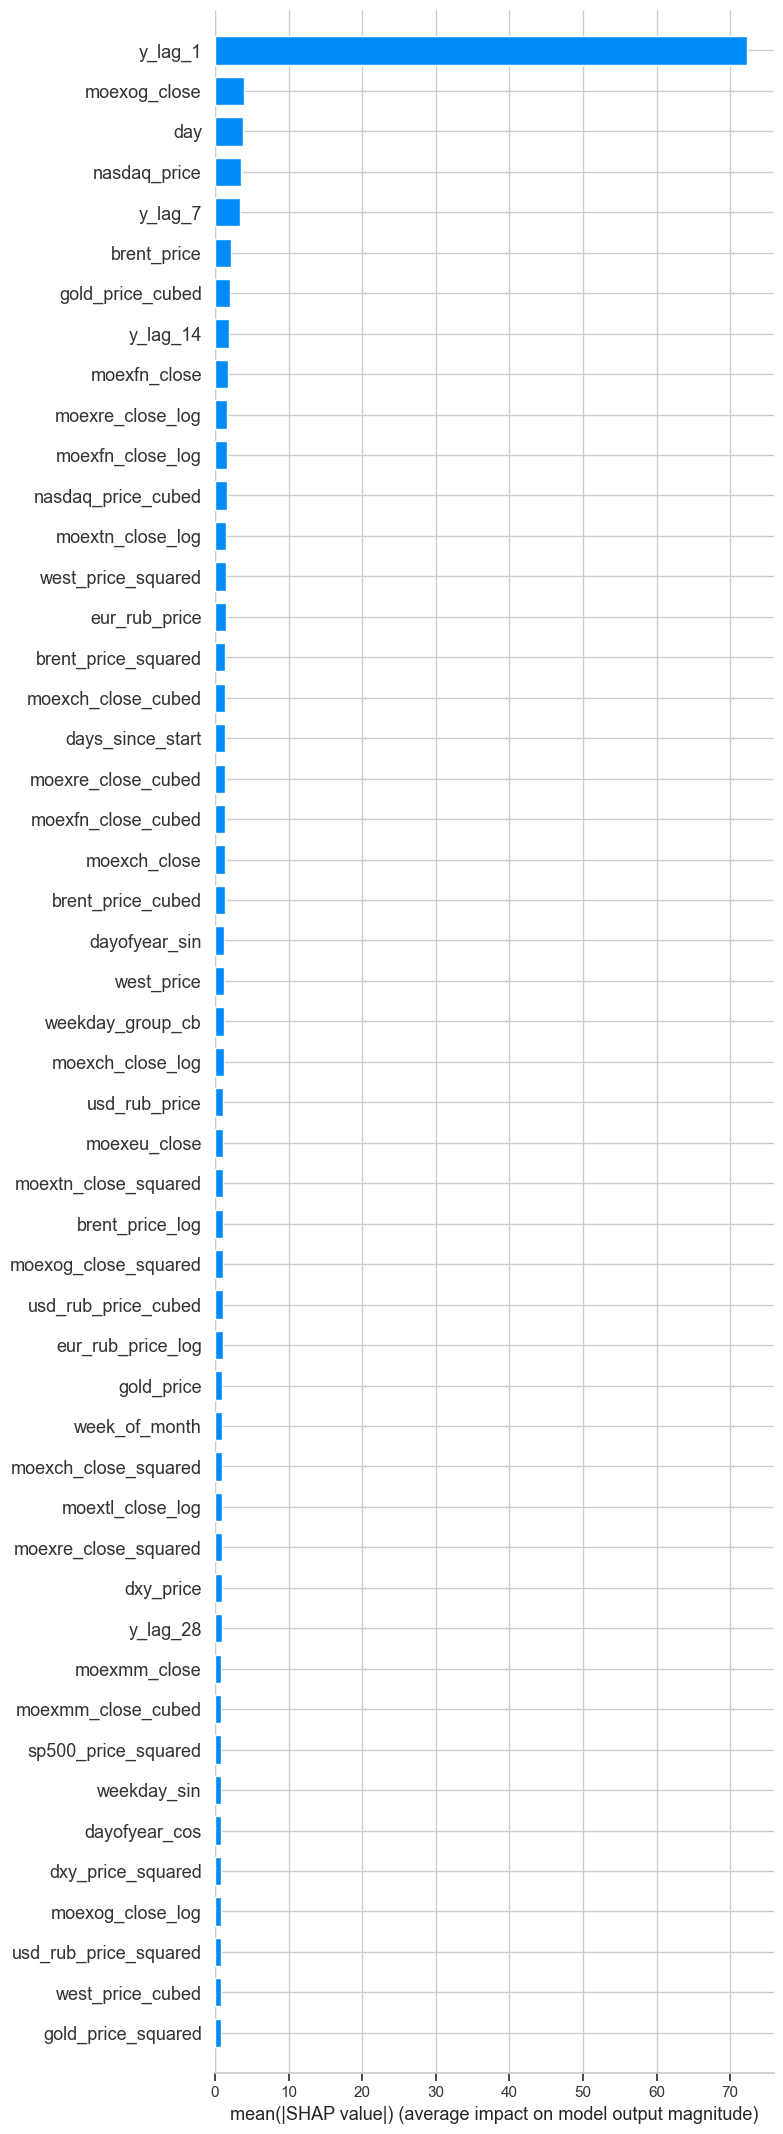

In [425]:
shap_df, shap_values = calculate_shap_feature_importance(
    X_train=X_train_gbdt[model_features_gbdt],
    y_train=y_train_gbdt,
    X_shap=X_test_gbdt[model_features_gbdt],
    y_shap=y_test_gbdt,
    max_display=50,
    target_name='IMOEX',
    sampling_strategy='last',
    shap_mode='interventional'
)

In [426]:
model_features_gbdt = [
    # 'y_lag_1',
 'moexfn_close',
 'gold_price_cubed',
 'moexch_close',
 'day',
 'nasdaq_price',
 'moexog_close',
 'usd_rub_price',
 'nasdaq_price_log',
 'days_since_start',
 'nasdaq_price_squared',
 'moexfn_close_squared',
 'west_price',
 'moexfn_close_cubed',
 'moexog_close_log',
 'weekday_sin',
 'brent_price',
 'brent_price_cubed',
 'moexcn_close_cubed',
 'usd_rub_price_cubed',
 'brent_price_squared',
 'weekday_cos',
 # 'y_lag_14',
 'moexog_close_cubed',
 'sp500_price',
 'moextl_close_squared',
 'moexmm_close',
 'eur_rub_price',
 'moexre_close_squared',
 'moextn_close_log',
 # 'y_lag_28',
 'eur_rub_price_squared',
 'cb_rate',
 'moextn_close_cubed',
 'eur_rub_price_log',
 'usd_rub_price_log',
 # 'y_lag_7',
 'sp500_price_squared',
 'moextn_close',
 'dayofyear_sin',
 'usd_rub_price_squared',
 'eur_rub_price_cubed',
 'moexfn_close_log',
 'moexch_close_cubed',
 'sp500_price_cubed',
 'gold_price',
 'weekday_group_cb',
 'moexit_close',
 'moexeu_close',
 'vix_price_log',
 'moexmm_close_squared',
 'moexcn_close',
 'gold_price_log',
 'gold_price_squared',
 'west_price_cubed',
 'moexre_close',
 'west_price_squared',
 'moextn_close_squared',
 'moextl_close',
 'moexre_close_cubed',
 'moextl_close_log',
 'moexit_close_squared',
 'moexre_close_log',
 'dxy_price_log',
 'brent_price_log',
 'weekday',
 'dxy_price',
 'days_since_holiday',
 'dayofyear',
 'rvi_price',
 'moexch_close_squared',
 'west_price_log',
 'dxy_price_cubed',
 'days_until_holiday',
 'moexeu_close_cubed',
 'moextl_close_cubed',
 'rvi_price_cubed',
 'moexog_close_squared',
 'djia_price',
 'djia_price_log',
 'moexmm_close_log',
 'djia_price_squared',
 'moexmm_close_cubed',
 'nasdaq_price_cubed',
 'rvi_price_squared',
 'sp500_price_log',
 'month_sin',
 'rvi_price_log',
 'vix_price',
 'vix_price_cubed',
 'season_cb',
 'dayofyear_cos',
 'moexch_close_log',
 'moexeu_close_log',
 'moexcn_close_log',
 'is_monday',
 'is_quarter_end',
 'moexit_close_log',
 'djia_price_cubed',
 'week_of_month',
 'moexit_close_cubed',
 'week',
 'moexeu_close_squared',
 'dxy_price_squared',
 'before_holiday_7d',
 'is_quarter_start',
 'moexcn_close_squared',
 'vix_price_squared']

In [427]:
def filter_features_by_shap_and_correlation(
    shap_df: pd.DataFrame,
    X: pd.DataFrame,
    shap_values: np.ndarray,
    threshold: float = 0.9,
    corr_threshold: float = 0.9
) -> list:
    """
    Отбирает признаки по SHAP важности и устраняет коррелированные (через кластеризацию).

    Преобразования:
    - SHAP отбор по кумулятивной важности
    - корреляционная матрица очищается от NaN (заполняется 0)
    - кластеризация по 1 - |corr|

    Возвращает:
    - List[str]: финальный список отобранных признаков
    """

    # Step 1: Top SHAP features
    shap_df_sorted = shap_df.sort_values(by='mean_abs_shap', ascending=False).reset_index(drop=True)
    total = shap_df_sorted['mean_abs_shap'].sum()
    shap_df_sorted['cumulative'] = shap_df_sorted['mean_abs_shap'].cumsum() / total

    selected = shap_df_sorted[shap_df_sorted['cumulative'] <= threshold]
    if not selected.empty and selected.shape[0] < shap_df_sorted.shape[0]:
        selected = shap_df_sorted.iloc[:selected.shape[0] + 1]

    selected_features = selected['feature'].tolist()
    X_selected = X[selected_features]

    # Step 2: Correlation clustering with safe handling
    corr_matrix = X_selected.corr().abs().fillna(0)          
    distance_matrix = 1 - corr_matrix
    distance_matrix = (distance_matrix + distance_matrix.T) / 2
    np.fill_diagonal(distance_matrix.values, 0)

    # Step 3: Convert to condensed distance matrix
    condensed = squareform(distance_matrix.values, checks=False)
    linkage_matrix = linkage(condensed, method='average')
    clusters = fcluster(linkage_matrix, t=1 - corr_threshold, criterion='distance')

    # Step 4: Retain top SHAP feature per cluster
    cluster_df = pd.DataFrame({'feature': selected_features, 'cluster': clusters})
    retained = []
    for cluster_id in cluster_df['cluster'].unique():
        cluster_features = cluster_df[cluster_df['cluster'] == cluster_id]['feature']
        top = shap_df_sorted[shap_df_sorted['feature'].isin(cluster_features)].iloc[0]['feature']
        retained.append(top)

    return retained

In [428]:
model_features_gbdt = ['moexfn_close', #
                       'gold_price_cubed', #
                       'moexch_close', 
                       'day', 
                       'nasdaq_price', #
                       'moexog_close', 
                       'usd_rub_price', 
                       'days_since_start', #
                       'west_price', 
                       'weekday_sin', 
                       'brent_price', 
                       'moexcn_close_cubed', 
                       'weekday_cos', 
                       'sp500_price', #
                       'moextl_close_squared', 
                       'moexmm_close', 
                       'eur_rub_price', 
                       'moexre_close_squared', 
                       'moextn_close_log', 
                       'cb_rate', 
                       'dayofyear_sin', 
                       'weekday_group_cb', 
                       'moexit_close',#
                       'moexeu_close', #
                       'vix_price_log', #
                       'dxy_price_log',  #
                       'weekday', 
                       'days_since_holiday', #
                       'dayofyear', 
                       'rvi_price', 
                       'days_until_holiday', 
                       'rvi_price_cubed', 
                       'djia_price', 
                       'djia_price_squared', 
                       'month_sin', 
                       'vix_price_cubed']

In [429]:
def filter_features_by_shap_and_correlation(
    shap_df: pd.DataFrame,
    X: pd.DataFrame,
    shap_values: np.ndarray,
    threshold: float = 0.9,
    corr_threshold: float = 0.9
) -> list:
    """
    Отбирает признаки по SHAP важности и устраняет коррелированные (через кластеризацию).

    Преобразования:
    - SHAP отбор по кумулятивной важности
    - корреляционная матрица очищается от NaN (заполняется 0)
    - кластеризация по 1 - |corr|

    Возвращает:
    - List[str]: финальный список отобранных признаков
    """

    # Step 1: Top SHAP features
    shap_df_sorted = shap_df.sort_values(by='mean_abs_shap', ascending=False).reset_index(drop=True)
    total = shap_df_sorted['mean_abs_shap'].sum()
    shap_df_sorted['cumulative'] = shap_df_sorted['mean_abs_shap'].cumsum() / total

    selected = shap_df_sorted[shap_df_sorted['cumulative'] <= threshold]
    if not selected.empty and selected.shape[0] < shap_df_sorted.shape[0]:
        selected = shap_df_sorted.iloc[:selected.shape[0] + 1]

    selected_features = selected['feature'].tolist()
    X_selected = X[selected_features]

    # Step 2: Correlation clustering with safe handling
    corr_matrix = X_selected.corr().abs().fillna(0)          
    distance_matrix = 1 - corr_matrix
    distance_matrix = (distance_matrix + distance_matrix.T) / 2
    np.fill_diagonal(distance_matrix.values, 0)

    # Step 3: Convert to condensed distance matrix
    condensed = squareform(distance_matrix.values, checks=False)
    linkage_matrix = linkage(condensed, method='average')
    clusters = fcluster(linkage_matrix, t=1 - corr_threshold, criterion='distance')

    # Step 4: Retain top SHAP feature per cluster
    cluster_df = pd.DataFrame({'feature': selected_features, 'cluster': clusters})
    retained = []
    for cluster_id in cluster_df['cluster'].unique():
        cluster_features = cluster_df[cluster_df['cluster'] == cluster_id]['feature']
        top = shap_df_sorted[shap_df_sorted['feature'].isin(cluster_features)].iloc[0]['feature']
        retained.append(top)

    return retained

In [430]:
selected_features_gbdt = ['moexfn_close',
 'gold_price_cubed',
 'moexch_close',
 'day',
 'nasdaq_price',
 'moexog_close',
 'usd_rub_price',
 'nasdaq_price_log',
 'days_since_start',
 'nasdaq_price_squared',
 'moexfn_close_squared',
 'west_price',
 'moexfn_close_cubed',
 'moexog_close_log',
 'weekday_sin',
 'brent_price',
 'brent_price_cubed',
 'moexcn_close_cubed',
 'usd_rub_price_cubed',
 'brent_price_squared',
 'weekday_cos',
 'moexog_close_cubed',
 'sp500_price',
 'moextl_close_squared',
 'moexmm_close',
 'eur_rub_price',
 'moexre_close_squared',
 'moextn_close_log',
 'eur_rub_price_squared',
 'cb_rate',
 'moextn_close_cubed',
 'eur_rub_price_log',
 'usd_rub_price_log',
 'sp500_price_squared',
 'moextn_close',
 'dayofyear_sin',
 'usd_rub_price_squared',
 'eur_rub_price_cubed',
 'moexfn_close_log',
 'moexch_close_cubed',
 'sp500_price_cubed',
 'gold_price',
 'weekday_group_cb',
 'moexit_close',
 'moexeu_close',
 'vix_price_log',
 'moexmm_close_squared',
 'moexcn_close',
 'gold_price_log',
 'gold_price_squared',
 'west_price_cubed',
 'moexre_close',
 'west_price_squared',
 'moextn_close_squared',
 'moextl_close',
 'moexre_close_cubed',
 'moextl_close_log',
 'moexit_close_squared',
 'moexre_close_log',
 'dxy_price_log',
 'brent_price_log',
 'weekday',
 'dxy_price',
 'days_since_holiday',
 'dayofyear',
 'rvi_price',
 'moexch_close_squared',
 'west_price_log',
 'dxy_price_cubed',
 'days_until_holiday',
 'moexeu_close_cubed',
 'moextl_close_cubed',
 'rvi_price_cubed',
 'moexog_close_squared',
 'djia_price',
 'djia_price_log',
 'moexmm_close_log',
 'djia_price_squared',
 'moexmm_close_cubed',
 'nasdaq_price_cubed',
 'rvi_price_squared',
 'sp500_price_log',
 'month_sin',
 'rvi_price_log',
 'vix_price',
 'vix_price_cubed',
 'season_cb',
 'dayofyear_cos',
 'moexch_close_log',
 'moexeu_close_log',
 'moexcn_close_log',
 'is_monday',
 'is_quarter_end',
 'moexit_close_log',
 'djia_price_cubed',
 'week_of_month',
 'moexit_close_cubed',
 'week',
 'moexeu_close_squared',
 'dxy_price_squared',
 'before_holiday_7d',
 'is_quarter_start',
 'moexcn_close_squared',
 'vix_price_squared',
 'before_holiday_2d',
 'before_holiday_1d',
 'is_month_start',
 'month_cos',
 'is_friday',
 'before_holiday_14d',
 'is_day_after_long_weekend',
 'quarter',
 'after_holiday_3d',
 'after_holiday_1d',
 'after_holiday_2d',
 'after_holiday_14d',
 'is_month_end',
 'before_holiday_3d',
 'month',
 'is_long_weekend',
 'holiday_name_cb',
 'is_day_before_long_weekend',
 'after_holiday_7d',
 'is_holiday',
 'is_holiday_int']


In [431]:
shap_df_not_lags = shap_df[~shap_df['feature'].str.contains('lag', case=False, regex=False)]
list(shap_df_not_lags['feature'])

['moexog_close',
 'day',
 'nasdaq_price',
 'brent_price',
 'gold_price_cubed',
 'moexfn_close',
 'moexre_close_log',
 'moexfn_close_log',
 'nasdaq_price_cubed',
 'moextn_close_log',
 'west_price_squared',
 'eur_rub_price',
 'brent_price_squared',
 'moexch_close_cubed',
 'days_since_start',
 'moexre_close_cubed',
 'moexfn_close_cubed',
 'moexch_close',
 'brent_price_cubed',
 'dayofyear_sin',
 'west_price',
 'weekday_group_cb',
 'moexch_close_log',
 'usd_rub_price',
 'moexeu_close',
 'moextn_close_squared',
 'brent_price_log',
 'moexog_close_squared',
 'usd_rub_price_cubed',
 'eur_rub_price_log',
 'gold_price',
 'week_of_month',
 'moexch_close_squared',
 'moextl_close_log',
 'moexre_close_squared',
 'dxy_price',
 'moexmm_close',
 'moexmm_close_cubed',
 'sp500_price_squared',
 'weekday_sin',
 'dayofyear_cos',
 'dxy_price_squared',
 'moexog_close_log',
 'usd_rub_price_squared',
 'west_price_cubed',
 'gold_price_squared',
 'gold_price_log',
 'moextl_close_squared',
 'days_until_holiday',
 '

In [432]:
model_features_gbdt = ['moexfn_close',
 'gold_price_cubed',
 'moexch_close',
 'day',
 'nasdaq_price',
 'moexog_close',
 'usd_rub_price',
 'nasdaq_price_log',
 'days_since_start',
 'nasdaq_price_squared',
 'moexfn_close_squared',
 'west_price',
 'moexfn_close_cubed',
 'moexog_close_log',
 'weekday_sin',
 'brent_price',
 'brent_price_cubed',
 'moexcn_close_cubed',
 'usd_rub_price_cubed',
 'brent_price_squared',
 'weekday_cos',
 'moexog_close_cubed',
 'sp500_price',
 'moextl_close_squared',
 'moexmm_close',
 'eur_rub_price',
 'moexre_close_squared',
 'moextn_close_log',
 'eur_rub_price_squared',
 'cb_rate',
 'moextn_close_cubed',
 'eur_rub_price_log',
 'usd_rub_price_log',
 'sp500_price_squared',
 'moextn_close',
 'dayofyear_sin',
 'usd_rub_price_squared',
 'eur_rub_price_cubed',
 'moexfn_close_log',
 'moexch_close_cubed',
 'sp500_price_cubed',
 'gold_price',
 'weekday_group_cb',
 'moexit_close',
 'moexeu_close',
 'vix_price_log',
 'moexmm_close_squared',
 'moexcn_close',
 'gold_price_log',
 'gold_price_squared',
 'west_price_cubed',
 'moexre_close',
 'west_price_squared',
 'moextn_close_squared',
 'moextl_close',
 'moexre_close_cubed',
 'moextl_close_log',
 'moexit_close_squared',
 'moexre_close_log',
 'dxy_price_log',
 'brent_price_log',
 'weekday',
 'dxy_price',
 'days_since_holiday',
 'dayofyear',
 'rvi_price',
 'moexch_close_squared',
 'west_price_log',
 'dxy_price_cubed',
 'days_until_holiday',
 'moexeu_close_cubed',
 'moextl_close_cubed',
 'rvi_price_cubed',
 'moexog_close_squared',
 'djia_price',
 'djia_price_log',
 'moexmm_close_log',
 'djia_price_squared',
 'moexmm_close_cubed',
 'nasdaq_price_cubed',
 'rvi_price_squared',
 'sp500_price_log',
 'month_sin',
 'rvi_price_log',
 'vix_price',
 'vix_price_cubed',
 'season_cb',
 'dayofyear_cos',
 'moexch_close_log',
 'moexeu_close_log',
 'moexcn_close_log',
 'is_monday',
 'is_quarter_end',
 'moexit_close_log',
 'djia_price_cubed',
 'week_of_month',
 'moexit_close_cubed',
 'week',
 'moexeu_close_squared',
 'dxy_price_squared',
 'before_holiday_7d',
 'is_quarter_start',
 'moexcn_close_squared',
 'vix_price_squared',
 'before_holiday_2d',
 'before_holiday_1d',
 'is_month_start',
 'month_cos',
 'is_friday',
 'before_holiday_14d',
 'is_day_after_long_weekend',
 'quarter',
 'after_holiday_3d',
 'after_holiday_1d',
 'after_holiday_2d',
 'after_holiday_14d',
 'is_month_end',
 'before_holiday_3d',
 'month',
 'is_long_weekend',
 'holiday_name_cb',
 'is_day_before_long_weekend',
 'after_holiday_7d',
 'is_holiday',
 'is_holiday_int']

In [433]:
selected_features_gbdt = filter_features_by_shap_and_correlation(
    shap_df=shap_df_not_lags,
    X=X_test_gbdt[model_features_gbdt],
    shap_values=shap_values,
    threshold=0.5,
    corr_threshold=0.9999
)
print(selected_features_gbdt)

['moexog_close', 'day', 'nasdaq_price', 'brent_price', 'gold_price_cubed', 'moexfn_close', 'moexre_close_log', 'moexfn_close_log', 'nasdaq_price_cubed', 'moextn_close_log', 'west_price_squared', 'eur_rub_price', 'brent_price_squared', 'moexch_close_cubed', 'days_since_start', 'moexre_close_cubed', 'moexfn_close_cubed', 'moexch_close', 'brent_price_cubed', 'dayofyear_sin', 'west_price', 'weekday_group_cb', 'moexch_close_log', 'usd_rub_price']


In [434]:
selected_features_gbdt = ['moexog_close', 
                          'day', #
                          'nasdaq_price', 
                          'brent_price', 
                          'gold_price_cubed', 
                          'moexfn_close', #
                          'moexre_close_log', 
                          'moexfn_close_log', 
                          'nasdaq_price_cubed', 
                          'moextn_close_log', 
                          'west_price_squared', 
                          'eur_rub_price', #
                          'brent_price_squared', 
                          'moexch_close_cubed', #
                          'days_since_start', 
                          'moexre_close_cubed', #
                          'moexfn_close_cubed', #
                          'moexch_close', #
                          'brent_price_cubed', 
                          'dayofyear_sin', #
                          'west_price', 
                          'weekday_group_cb', #
                          'moexch_close_log', #
                          # 'usd_rub_price' - УБРАЛ
                         ]

### Лучшая модель

Hyperopt:   0%|                                                                                  | 0/1 [00:00<?, ?it/s]


===> Запуск objective, итерация 1 <===
  [Objective] Параметры: {'iterations': 4900, 'depth': 2, 'learning_rate': 0.04241993497221932, 'l2_leaf_reg': 14, 'random_strength': 0.14257063311625118, 'bagging_temperature': 0.40727936635483564, 'random_seed': 42, 'verbose': 0, 'bootstrap_type': 'Bayesian'}
  [CV] fold 1: train=103, val=101
    fit OK за 0.28 сек
  [CV] fold 2: train=204, val=101
    fit OK за 0.20 сек
  [CV] fold 3: train=305, val=101
    fit OK за 0.22 сек
  [CV] fold 4: train=406, val=101
    fit OK за 0.19 сек
  [CV] fold 5: train=507, val=101
    fit OK за 0.14 сек
  [Objective] mean_cv_rmse: 149.9662
  [Objective] Финальное обучение на всём трейне...
[1] Params: {'iterations': 4900, 'depth': 2, 'learning_rate': 0.04241993497221932, 'l2_leaf_reg': 14, 'random_strength': 0.14257063311625118, 'bagging_temperature': 0.40727936635483564, 'random_seed': 42, 'verbose': 0, 'bootstrap_type': 'Bayesian'} | CV RMSE: 149.9662 | Test RMSE: 50.9195


Hyperopt: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.86s/it]



Лучшие параметры по test_rmse: {'iteration': 1, 'iterations': 4900, 'depth': 2, 'learning_rate': 0.04241993497221932, 'l2_leaf_reg': 14, 'random_strength': 0.14257063311625118, 'bagging_temperature': 0.40727936635483564, 'random_seed': 42, 'verbose': 0, 'bootstrap_type': 'Bayesian', 'cv_rmse': 149.9661826349636, 'test_rmse': 50.919511137523635}
Hyperopt завершен за 2.86 секунд


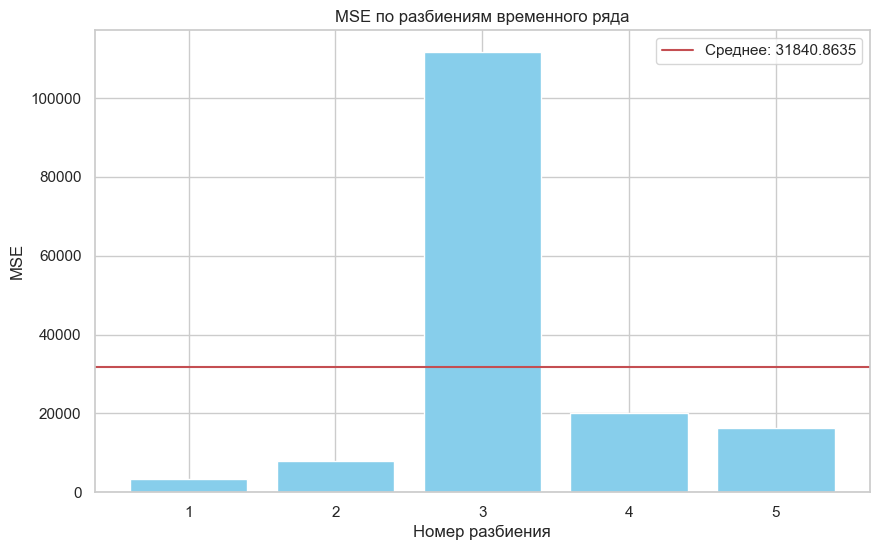

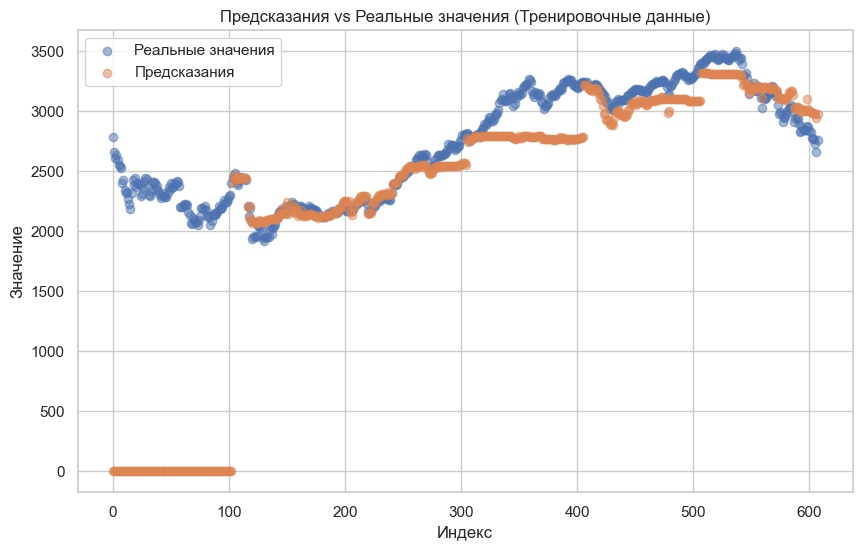

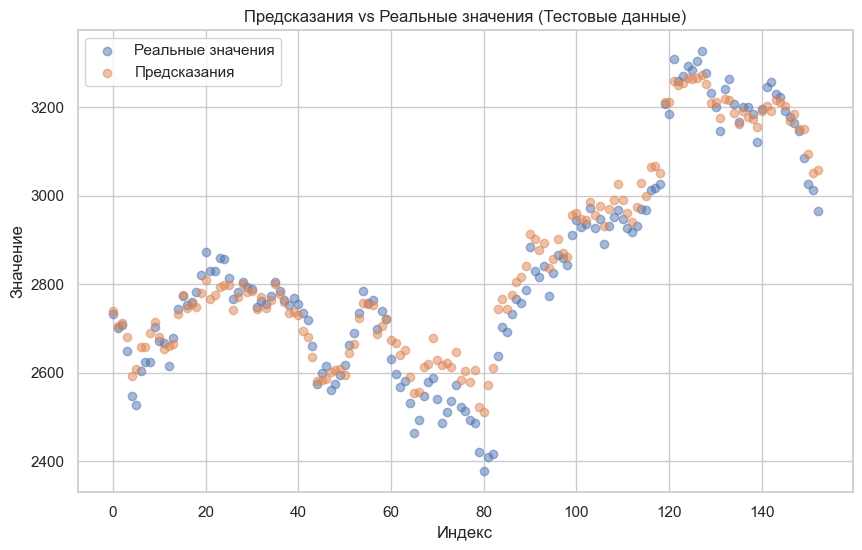

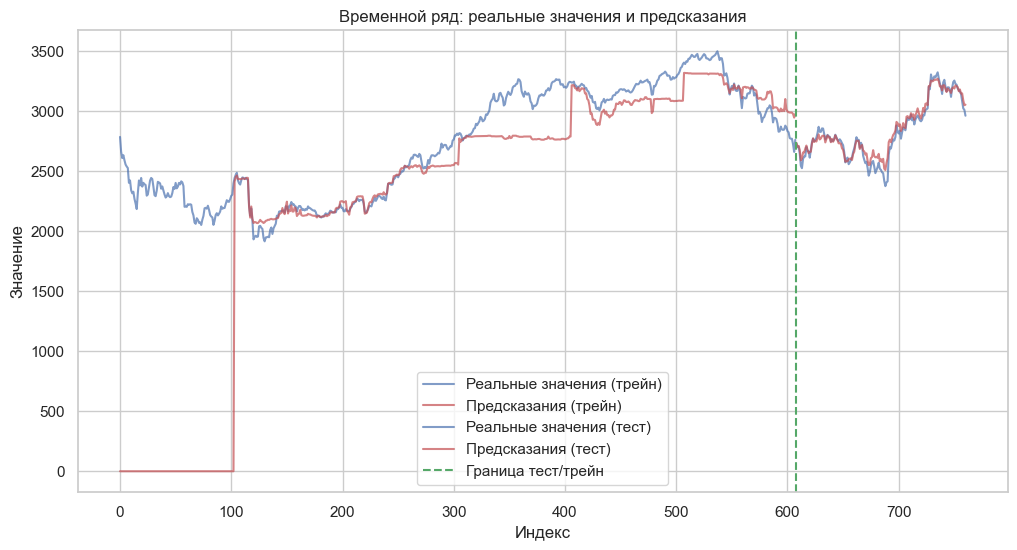

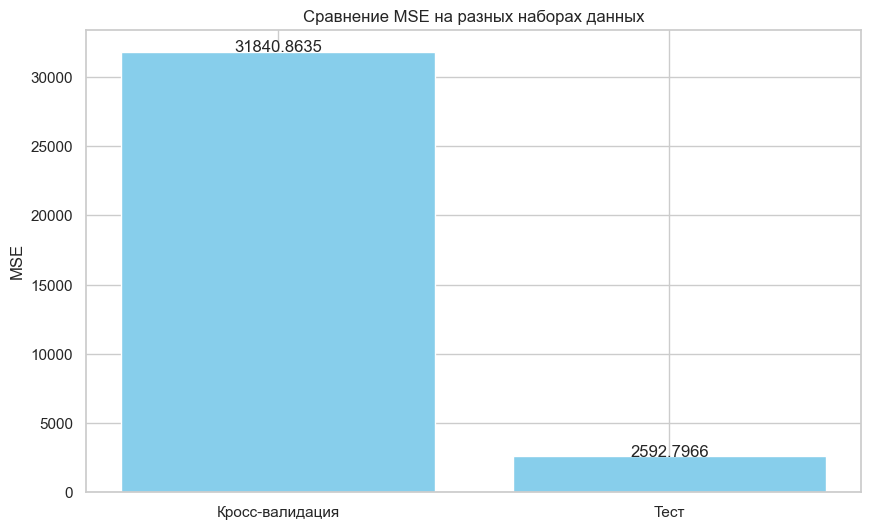

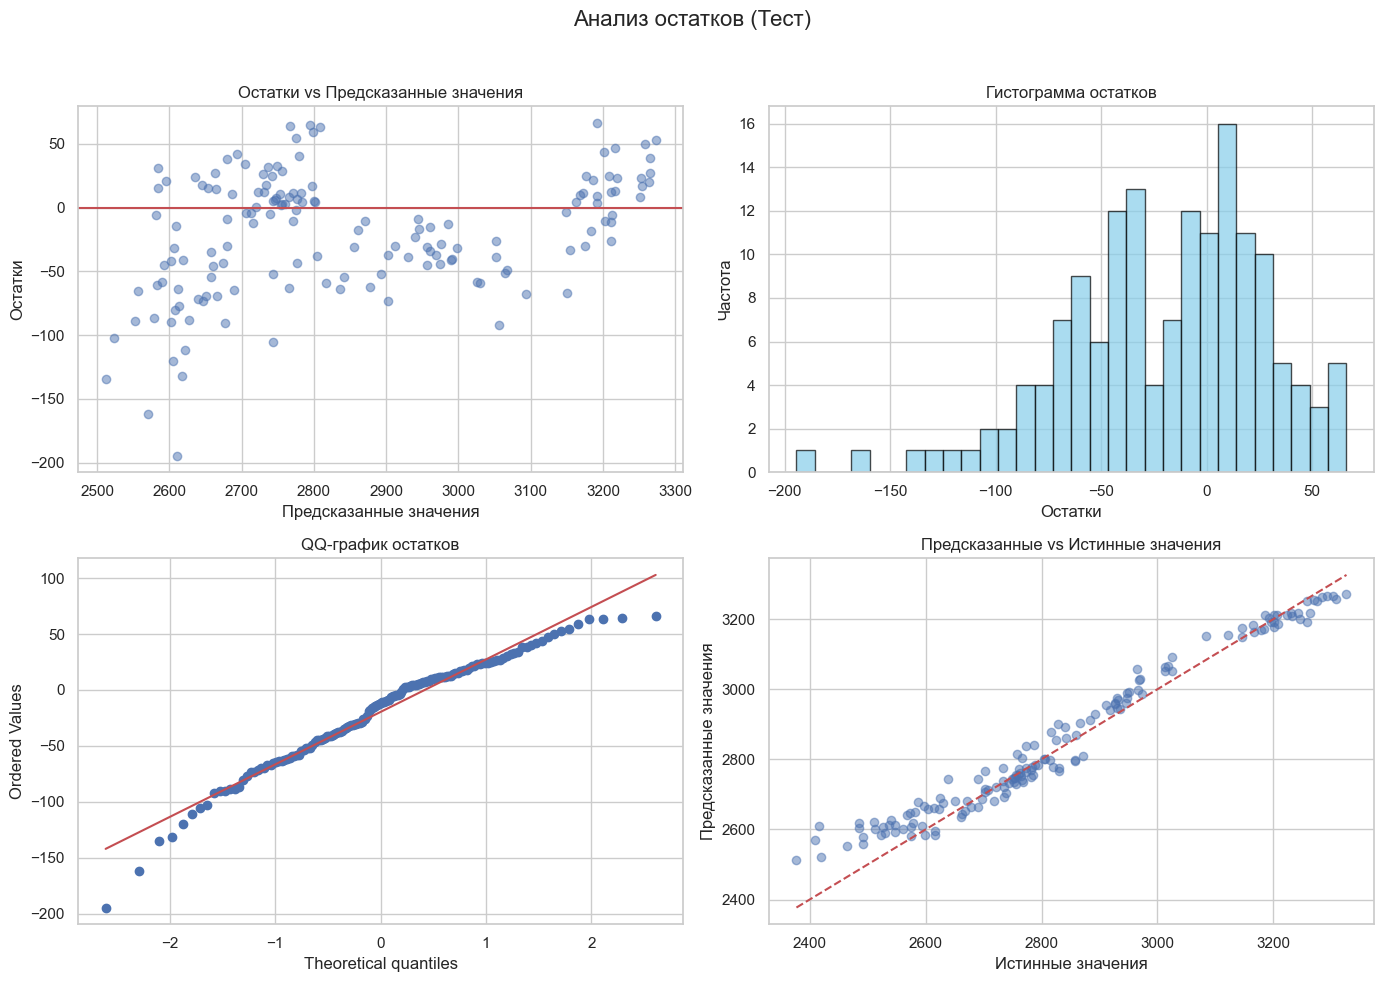

In [436]:
# Лучшие параметры по test_rmse: {'iteration': 430, 'iterations': 4900, 'depth': 2, 
# 'learning_rate': 0.04241993497221932, 'l2_leaf_reg': 14, 'random_strength': 0.14257063311625118, 
# 'bagging_temperature': 0.40727936635483564, 'random_seed': 42, 'verbose': 0, 
# 'bootstrap_type': 'Bayesian', 'cv_rmse': 150.06111445941227, 'test_rmse': 58.734258040663754}
# Hyperopt завершен за 2004.86 секунд


# Параметры из space_catboost
params = {
    'iterations': 4900,
    'depth': 2,
    'learning_rate': 0.04241993497221932,
    'l2_leaf_reg': 14,
    'random_strength': 0.14257063311625118,
    'bagging_temperature': 0.40727936635483564,
    'bootstrap_type': 'Bayesian',
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'random_seed': 42,
    'verbose': 100
}

results = run_hyperopt_on_original(
    X_train=X_train_gbdt[selected_features_gbdt],
    y_train=y_original_train_gbdt,
    X_test=X_test_gbdt[selected_features_gbdt],
    y_test=y_original_test_gbdt,
    model_class=cb.CatBoostRegressor,
    space=params,
    n_iter=1,
    early_stopping_rounds=10,
    random_state=42
)

In [437]:
cv_results = results['cv_results']
y_pred_gbdt = cv_results['test_predictions']

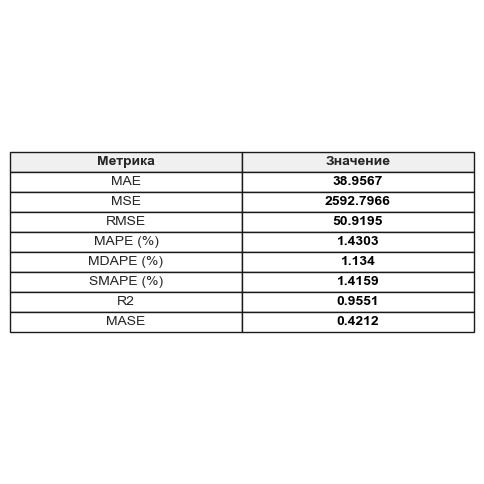

Метрика  Значение
0        MAE    38.957
1        MSE  2592.797
2       RMSE    50.919
3   MAPE (%)     1.430
4  MDAPE (%)     1.134
5  SMAPE (%)     1.416
6         R2     0.955
7       MASE     0.421

In [438]:
metrics_report(y_true=y_original_test_gbdt, y_pred=y_pred_gbdt, seasonality=6, model_name='CatBoostRegressor')

### Валидации

ROC AUC: 0.8142


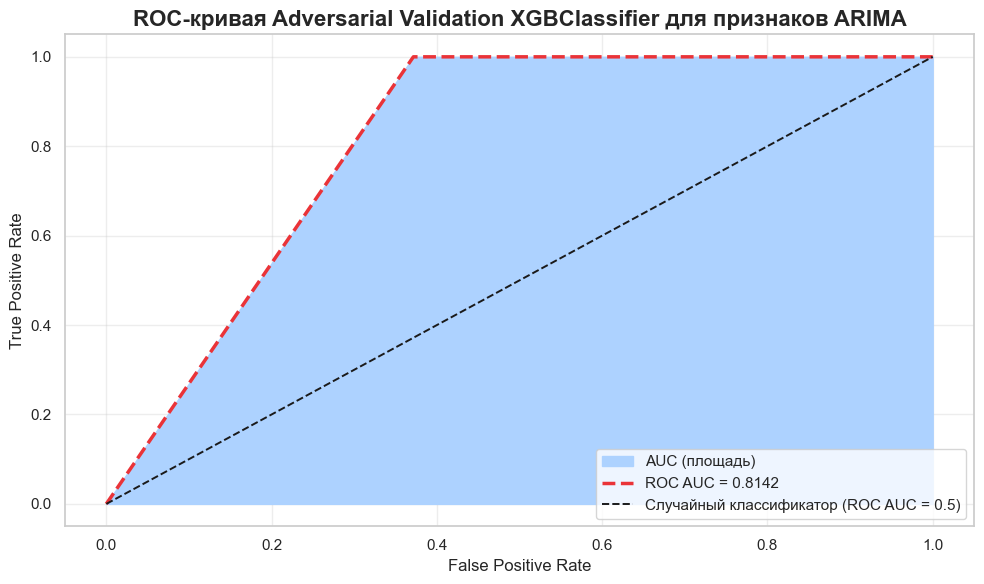

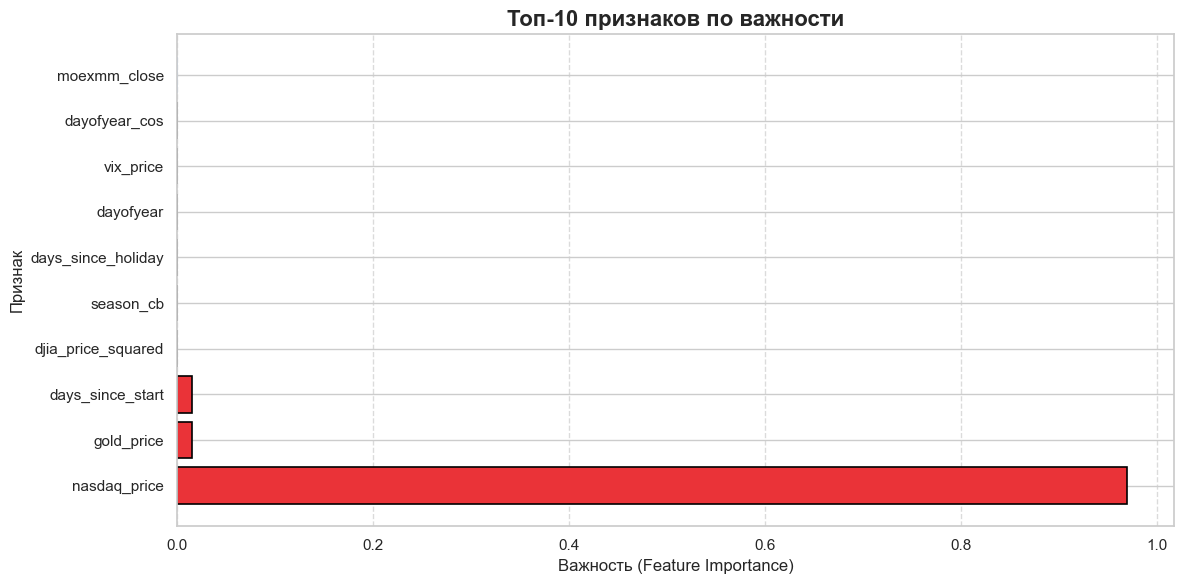

In [440]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve

def adversarial_validation(X_train, X_test, test_size=0.3, random_state=42):
    """
    Adversarial validation между X_train и X_test с визуализацией ROC-кривой и важности признаков.
    """

    # Преобразования
    X_train = X_train.to_frame() if isinstance(X_train, pd.Series) else X_train
    X_test = X_test.to_frame() if isinstance(X_test, pd.Series) else X_test

    # Проверки
    if set(X_train.columns) != set(X_test.columns):
        raise ValueError("Колонки X_train и X_test должны совпадать")
    if any(not np.issubdtype(X_train[col].dtype, np.number) for col in X_train.columns):
        raise ValueError("Все признаки должны быть числовыми")

    # Собираем общий датафрейм и метки
    X_combined = pd.concat([X_train, X_test], axis=0)
    y_combined = np.array([0] * len(X_train) + [1] * len(X_test))

    # Индексы для разбиения (temporal split)
    train_idx = np.where(y_combined == 0)[0]
    test_idx = np.where(y_combined == 1)[0]

    split_train = int(len(train_idx) * 0.7)
    split_test = int(len(test_idx) * 0.7)

    train_part_idx = np.concatenate([train_idx[:split_train], test_idx[:split_test]])
    val_part_idx = np.concatenate([train_idx[split_train:], test_idx[split_test:]])

    X_dev, y_dev = X_combined.iloc[train_part_idx], y_combined[train_part_idx]
    X_val, y_val = X_combined.iloc[val_part_idx], y_combined[val_part_idx]

    # Модель
    model = XGBClassifier(
        max_depth=3,
        learning_rate=0.1,
        n_estimators=100,
        objective='binary:logistic',
        random_state=random_state,
        base_score=0.5
    )

    model.fit(X_dev, y_dev)
    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    print(f"ROC AUC: {auc:.4f}")

    # ROC-кривая с заливкой площади
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    plt.figure(figsize=(10, 6))
    plt.fill_between(fpr, tpr, 0, color='#ADD2FF', label='AUC (площадь)')
    plt.plot(fpr, tpr, color='#EA3338', linewidth=2.5, linestyle='--', label=f'ROC AUC = {auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1.4, label='Случайный классификатор (ROC AUC = 0.5)')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC-кривая Adversarial Validation XGBClassifier для признаков ARIMA', fontsize=16, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.35)
    plt.tight_layout()
    plt.show()

    # Важность признаков - сплошная заливка, черный контур
    feature_importance = pd.DataFrame({
        'Признак': X_combined.columns,
        'Важность': model.feature_importances_
    }).sort_values('Важность', ascending=False)

    plt.figure(figsize=(12, 6))
    bars = plt.barh(
        feature_importance['Признак'].head(10)[::-1], 
        feature_importance['Важность'].head(10)[::-1], 
        color='#EA3338',
        edgecolor='black',
        linewidth=1.2
    )
    # Топ-1 выделяем голубым (в конце, т.к. plot обратный)
    if len(bars) > 0:
        bars[0].set_color('#ADD2FF')
    plt.title('Топ-10 признаков по важности', fontsize=16, fontweight='bold')
    plt.xlabel('Важность (Feature Importance)', fontsize=12)
    plt.ylabel('Признак', fontsize=12)
    plt.gca().invert_yaxis()
    plt.grid(True, linestyle='--', alpha=0.7, axis='x')
    plt.tight_layout()
    plt.show()

    return auc, feature_importance

auc, feature_importance = adversarial_validation(
    X_train=X_train[model_features_arima],
    X_test=X_test[model_features_arima]
)

In [441]:
def kolmogorov_smirnov_target_analysis(
    train_y, test_y, bins=30, 
    target_name='IMOEX',
    plot_type='kde',
    xlabel='Значения',
    ylabel='Плотность'
):
    """
    KS-анализ с поддержкой кастомных названий и подписей осей.
    """

    arr_train = train_y.dropna().values
    arr_test = test_y.dropna().values

    if len(arr_train) == 0 or len(arr_test) == 0:
        print("Ошибка: train или test содержит пустой массив.")
        return

    train_sorted = np.sort(arr_train)
    test_sorted = np.sort(arr_test)

    # 1. Плотность или гистограмма
    plt.figure(figsize=(12, 5))
    if plot_type == 'kde':
        sns.kdeplot(arr_train, label='Train: распределение таргета', fill=True, color='#EA3338', alpha=0.4)
        sns.kdeplot(arr_test, label='Test: распределение таргета', fill=True, color='#ADD2FF', alpha=0.4)
        plt.title(f'Диаграмма плотности (KDE) таргета ({target_name})', fontsize=14, fontweight='bold')
    else:
        bins_range = np.linspace(min(arr_train.min(), arr_test.min()), max(arr_train.max(), arr_test.max()), bins + 1)
        plt.hist(arr_train, bins=bins_range, alpha=0.5, label='Train: распределение таргета', density=True, color='#EA3338')
        plt.hist(arr_test, bins=bins_range, alpha=0.5, label='Test: распределение таргета', density=True, color='#ADD2FF')
        plt.title(f'Гистограмма распределения таргета ({target_name})', fontsize=14, fontweight='bold')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 2. ECDF
    plt.figure(figsize=(12, 5))
    plt.plot(train_sorted, np.arange(1, len(train_sorted) + 1) / len(train_sorted), label='Train: ECDF', color='#EA3338')
    plt.plot(test_sorted, np.arange(1, len(test_sorted) + 1) / len(test_sorted), label='Test: ECDF', color='#ADD2FF')
    plt.title(f'Эмпирические функции распределения (ECDF) таргета ({target_name})', fontsize=14, fontweight='bold')
    plt.xlabel(xlabel)
    plt.ylabel('Доля наблюдений')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 3. Приведённые распределения
    train_to_test = np.searchsorted(train_sorted, test_sorted) / len(train_sorted)
    test_ecdf = np.arange(1, len(test_sorted) + 1) / len(test_sorted)
    ks_diff = np.abs(train_to_test - test_ecdf)
    ks_stat_idx = np.argmax(ks_diff)
    ks_stat = ks_diff[ks_stat_idx]
    x_ks = test_sorted[ks_stat_idx]

    ks_result = ks_2samp(arr_train, arr_test)

    legend_lines = [
        'Train: ECDF в точках Test',
        'Test: ECDF',
        f'KS-статистика = {ks_stat:.4f}',
        f'p-value: {ks_result.pvalue:.4f}'
    ]

    plt.figure(figsize=(12, 5))
    plt.plot(test_sorted, train_to_test, color='#EA3338')
    plt.plot(test_sorted, test_ecdf, color='#ADD2FF')
    plt.vlines(
        x_ks,
        ymin=test_ecdf[ks_stat_idx],
        ymax=train_to_test[ks_stat_idx],
        color='black', linestyle='--', linewidth=2
    )
    y_text = (train_to_test[ks_stat_idx] + test_ecdf[ks_stat_idx]) / 2
    plt.text(x_ks, y_text, f"{ks_stat:.4f}", fontsize=10, color='black')
    plt.title(f'KS-тест и приведённые ECDF для таргета ({target_name})', fontsize=14, fontweight='bold')
    plt.xlabel(xlabel)
    plt.ylabel('ECDF / Доля наблюдений')

    from matplotlib.lines import Line2D
    custom_lines = [
        Line2D([0], [0], color='#EA3338', lw=2),
        Line2D([0], [0], color='#ADD2FF', lw=2),
        Line2D([0], [0], color='black', lw=2, linestyle='--'),
        Line2D([0], [0], color='white', lw=0)
    ]
    plt.legend(custom_lines, legend_lines, loc='upper left', frameon=True)

    plt.grid(True)
    plt.tight_layout()
    plt.show()

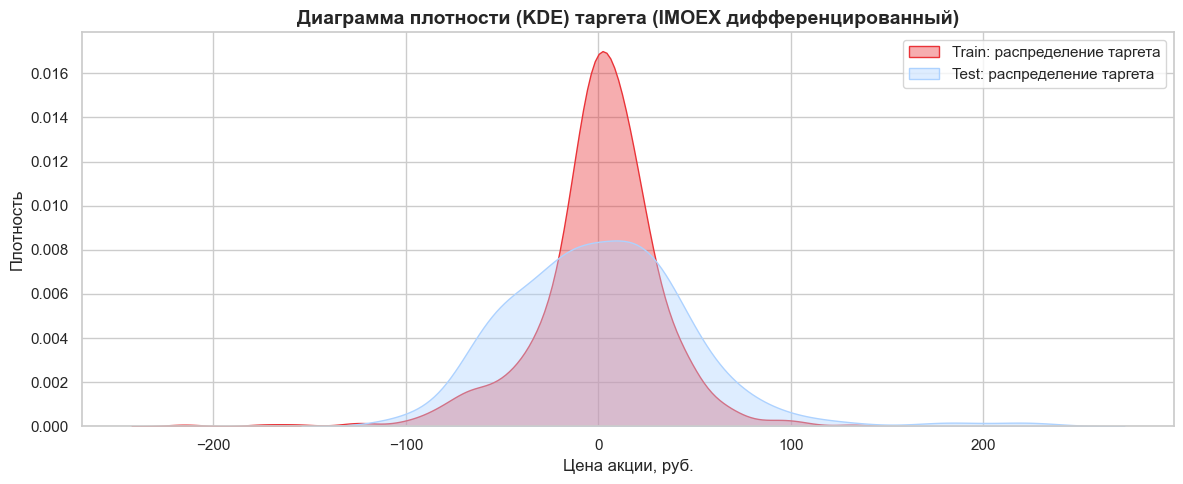

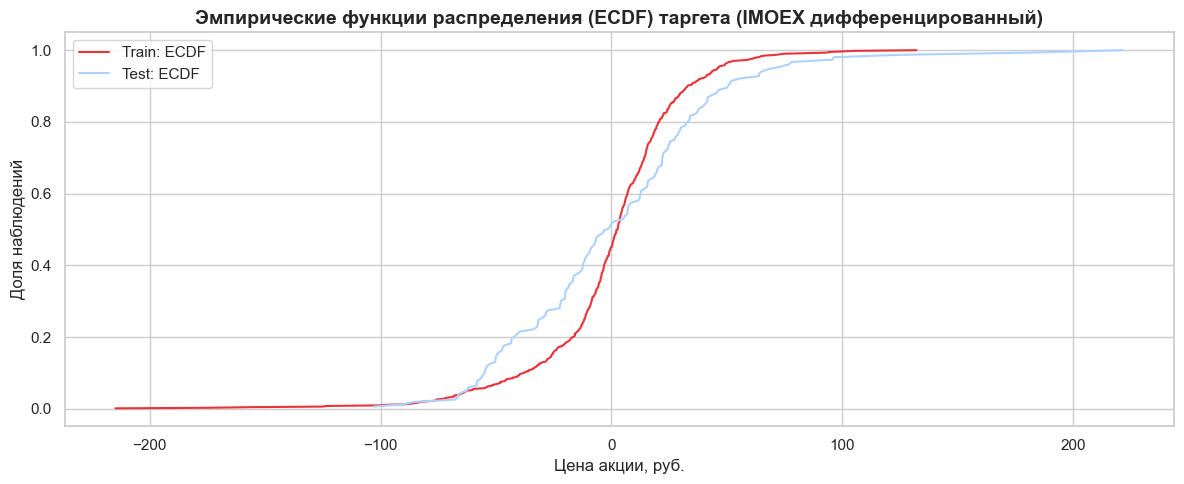

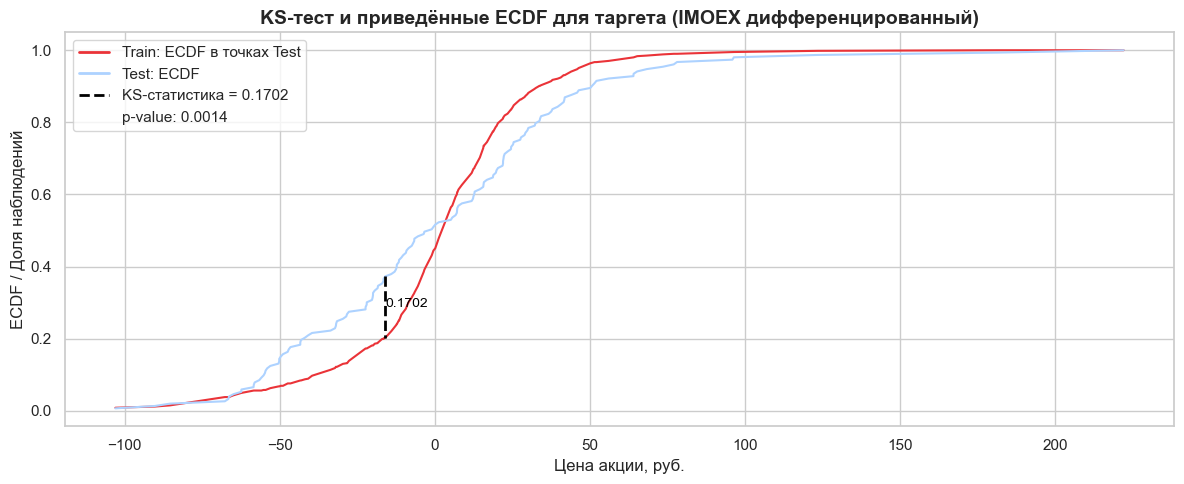

In [442]:
kolmogorov_smirnov_target_analysis(
    y_train, y_test,
    bins=40,
    target_name='IMOEX дифференцированный',
    xlabel='Цена акции, руб.',
    ylabel='Плотность'
)

In [443]:
def format_ks_test_results(sample1, sample2, name='таргета (IMOEX)'):
    """
    Выполняет тест Колмогорова–Смирнова (двусторонний, less, greater),
    формирует и выводит таблицу с результатами в нужном стиле.

    Аргументы:
        sample1: первая выборка
        sample2: вторая выборка
        name: имя переменной для отображения

    Возвращает:
        DataFrame с округлёнными результатами.
    """
    ks_result = ks_2samp(sample1, sample2, alternative='two-sided')
    ks_less = ks_2samp(sample1, sample2, alternative='less')
    ks_greater = ks_2samp(sample1, sample2, alternative='greater')

    df = pd.DataFrame({
        'Метрика': [
            'KS-статистика (двусторонний тест)',
            'KS-статистика (альтернатива: less)',
            'KS-статистика (альтернатива: greater)',
            'p-value (двусторонний тест)'
        ],
        'Значение': [
            f"{ks_result.statistic:.4f}",
            f"{ks_less.statistic:.4f}",
            f"{ks_greater.statistic:.4f}",
            f"{ks_result.pvalue:.4f}"
        ]
    })

    print(f"\nРезультаты KS-теста для {name}:\n")
    print(df.to_markdown(index=False, tablefmt="grid", colalign=("left", "right")))

    return df

format_ks_test_results(y_train, y_test, name='таргета (IMOEX дифференцированный)')


Результаты KS-теста для таргета (IMOEX дифференцированный):

+---------------------------------------+------------+
| Метрика                               |   Значение |
+=======================================+============+
| KS-статистика (двусторонний тест)     |     0.1702 |
+---------------------------------------+------------+
| KS-статистика (альтернатива: less)    |     0.1702 |
+---------------------------------------+------------+
| KS-статистика (альтернатива: greater) |      0.136 |
+---------------------------------------+------------+
| p-value (двусторонний тест)           |     0.0014 |
+---------------------------------------+------------+


Метрика Значение
0      KS-статистика (двусторонний тест)   0.1702
1     KS-статистика (альтернатива: less)   0.1702
2  KS-статистика (альтернатива: greater)   0.1360
3            p-value (двусторонний тест)   0.0014

## Теперь будем анализировать прогнозы!

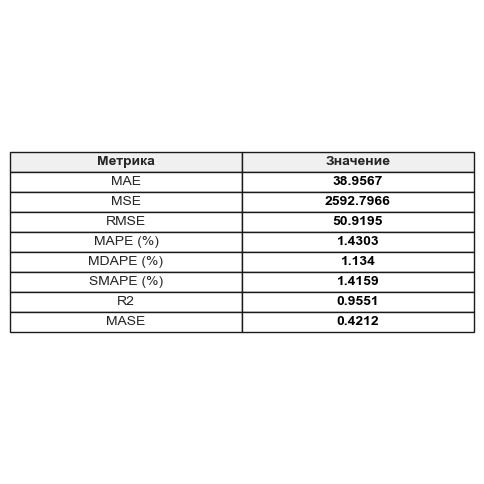

Метрика  Значение
0        MAE    38.957
1        MSE  2592.797
2       RMSE    50.919
3   MAPE (%)     1.430
4  MDAPE (%)     1.134
5  SMAPE (%)     1.416
6         R2     0.955
7       MASE     0.421

In [445]:
metrics_report(y_true=y_original_test_gbdt, y_pred=y_pred_gbdt, seasonality=6, model_name='CatBoostRegressor')

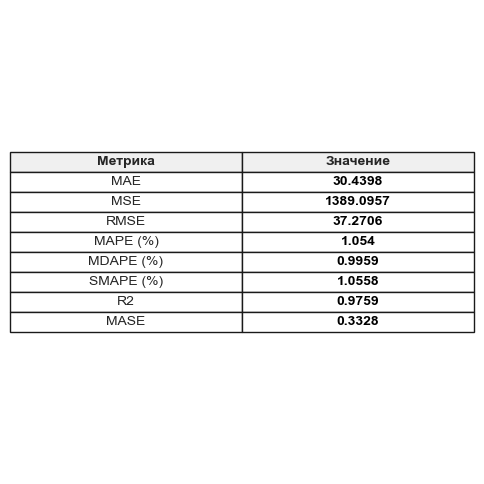

Метрика  Значение
0        MAE    30.440
1        MSE  1389.096
2       RMSE    37.271
3   MAPE (%)     1.054
4  MDAPE (%)     0.996
5  SMAPE (%)     1.056
6         R2     0.976
7       MASE     0.333

In [446]:
metrics_report(y_true=y_original_test, y_pred=arima_forecast, seasonality=6, model_name='ARIMA')

### Бутстрап-интервал + гистограмма

### ARIMA

In [449]:
def bootstrap_rmse_hist_ci(
    y_true, y_pred, n_iterations=10000, alpha=0.05, bins=30, title="Бутстрэп RMSE: 95% доверительный интервал"
):
    """
    Бутстрэп-распределение RMSE с гистограммой и плотностью в фирменных цветах.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    assert len(y_true) == len(y_pred), "Длины массивов должны совпадать"
    n = len(y_true)
    rmses = []
    for _ in range(n_iterations):
        idx = np.random.choice(n, size=n, replace=True)
        rmse = np.sqrt(np.mean((y_true[idx] - y_pred[idx])**2))
        rmses.append(rmse)
    rmses = np.array(rmses)
    
    # Границы бутстрэп-интервала
    left = np.percentile(rmses, 100 * alpha / 2)
    right = np.percentile(rmses, 100 * (1 - alpha / 2))
    median = np.median(rmses)
    mean = np.mean(rmses)
    
    # Гистограмма
    plt.figure(figsize=(10, 5))
    counts, bin_edges, patches = plt.hist(
        rmses, bins=bins, density=True, color="#ADD2FF", alpha=0.4, edgecolor="#ADD2FF", label=None
    )
    # Окрашивание вне интервала
    for patch, left_edge, right_edge in zip(patches, bin_edges[:-1], bin_edges[1:]):
        if right_edge < left or left_edge > right:
            patch.set_facecolor('#EA3338')
            patch.set_alpha(0.4)
        else:
            patch.set_facecolor('#ADD2FF')
            patch.set_alpha(0.4)

    # Плотность KDE
    sns.kdeplot(rmses, color="#ADD2FF", fill=True, alpha=0.4, linewidth=2, label="Плотность (KDE)")
    # Нарисуем ещё контур (тонкий) для чёткости
    sns.kdeplot(rmses, color="#005CBF", fill=False, linewidth=1.3, label=None)

    # Линии: медиана, среднее, CI
    plt.axvline(median, color="#EA3338", linestyle="-", lw=2, label=f"Медиана: {median:.3f}")
    plt.axvline(mean, color="#005CBF", linestyle="--", lw=2, label=f"Среднее: {mean:.3f}")
    plt.axvline(left, color="#EA3338", linestyle="--", lw=2, label=f"Левая граница CI: {left:.3f}")
    plt.axvline(right, color="#EA3338", linestyle="--", lw=2, label=f"Правая граница CI: {right:.3f}")

    # Титул и оси
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('RMSE')
    plt.ylabel('Плотность')
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()
    
    print(f"Bootstrap CI: [{left:.4f}, {right:.4f}]")
    print(f"Медиана: {median:.4f}")
    print(f"Среднее: {mean:.4f}")
    return left, right, median, mean, rmses

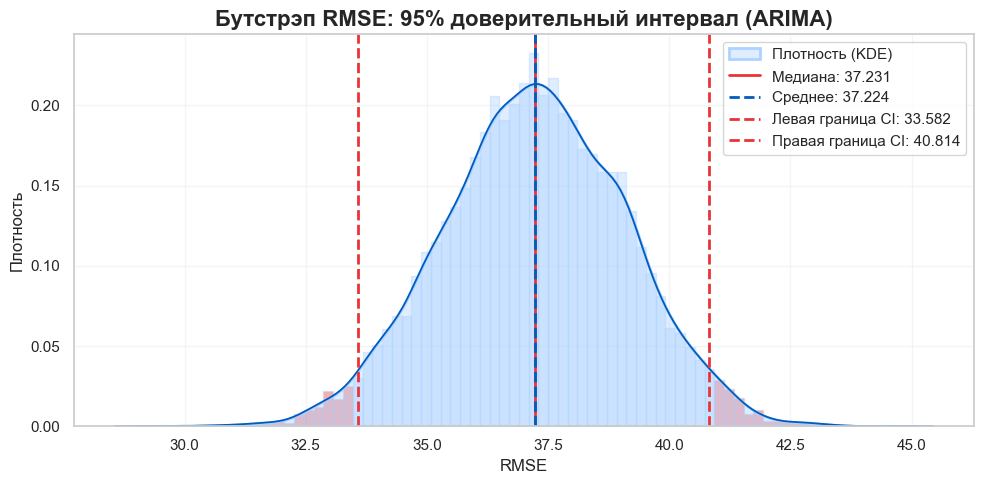

Bootstrap CI: [33.5825, 40.8142]
Медиана: 37.2308
Среднее: 37.2239


(33.58248498408241,
 40.814214497322695,
 37.23082632676861,
 37.22393191074135,
 array([38.36662696, 39.76935816, 37.77034659, ..., 35.89285338,
        35.58664529, 37.38746606]))

In [450]:
bootstrap_rmse_hist_ci(y_true=y_original_test,  
                       y_pred=arima_forecast, 
                       n_iterations=10000,
                       alpha=0.05,
                       bins=75,
                       title="Бутстрэп RMSE: 95% доверительный интервал (ARIMA)"
                      )

### CatBoost

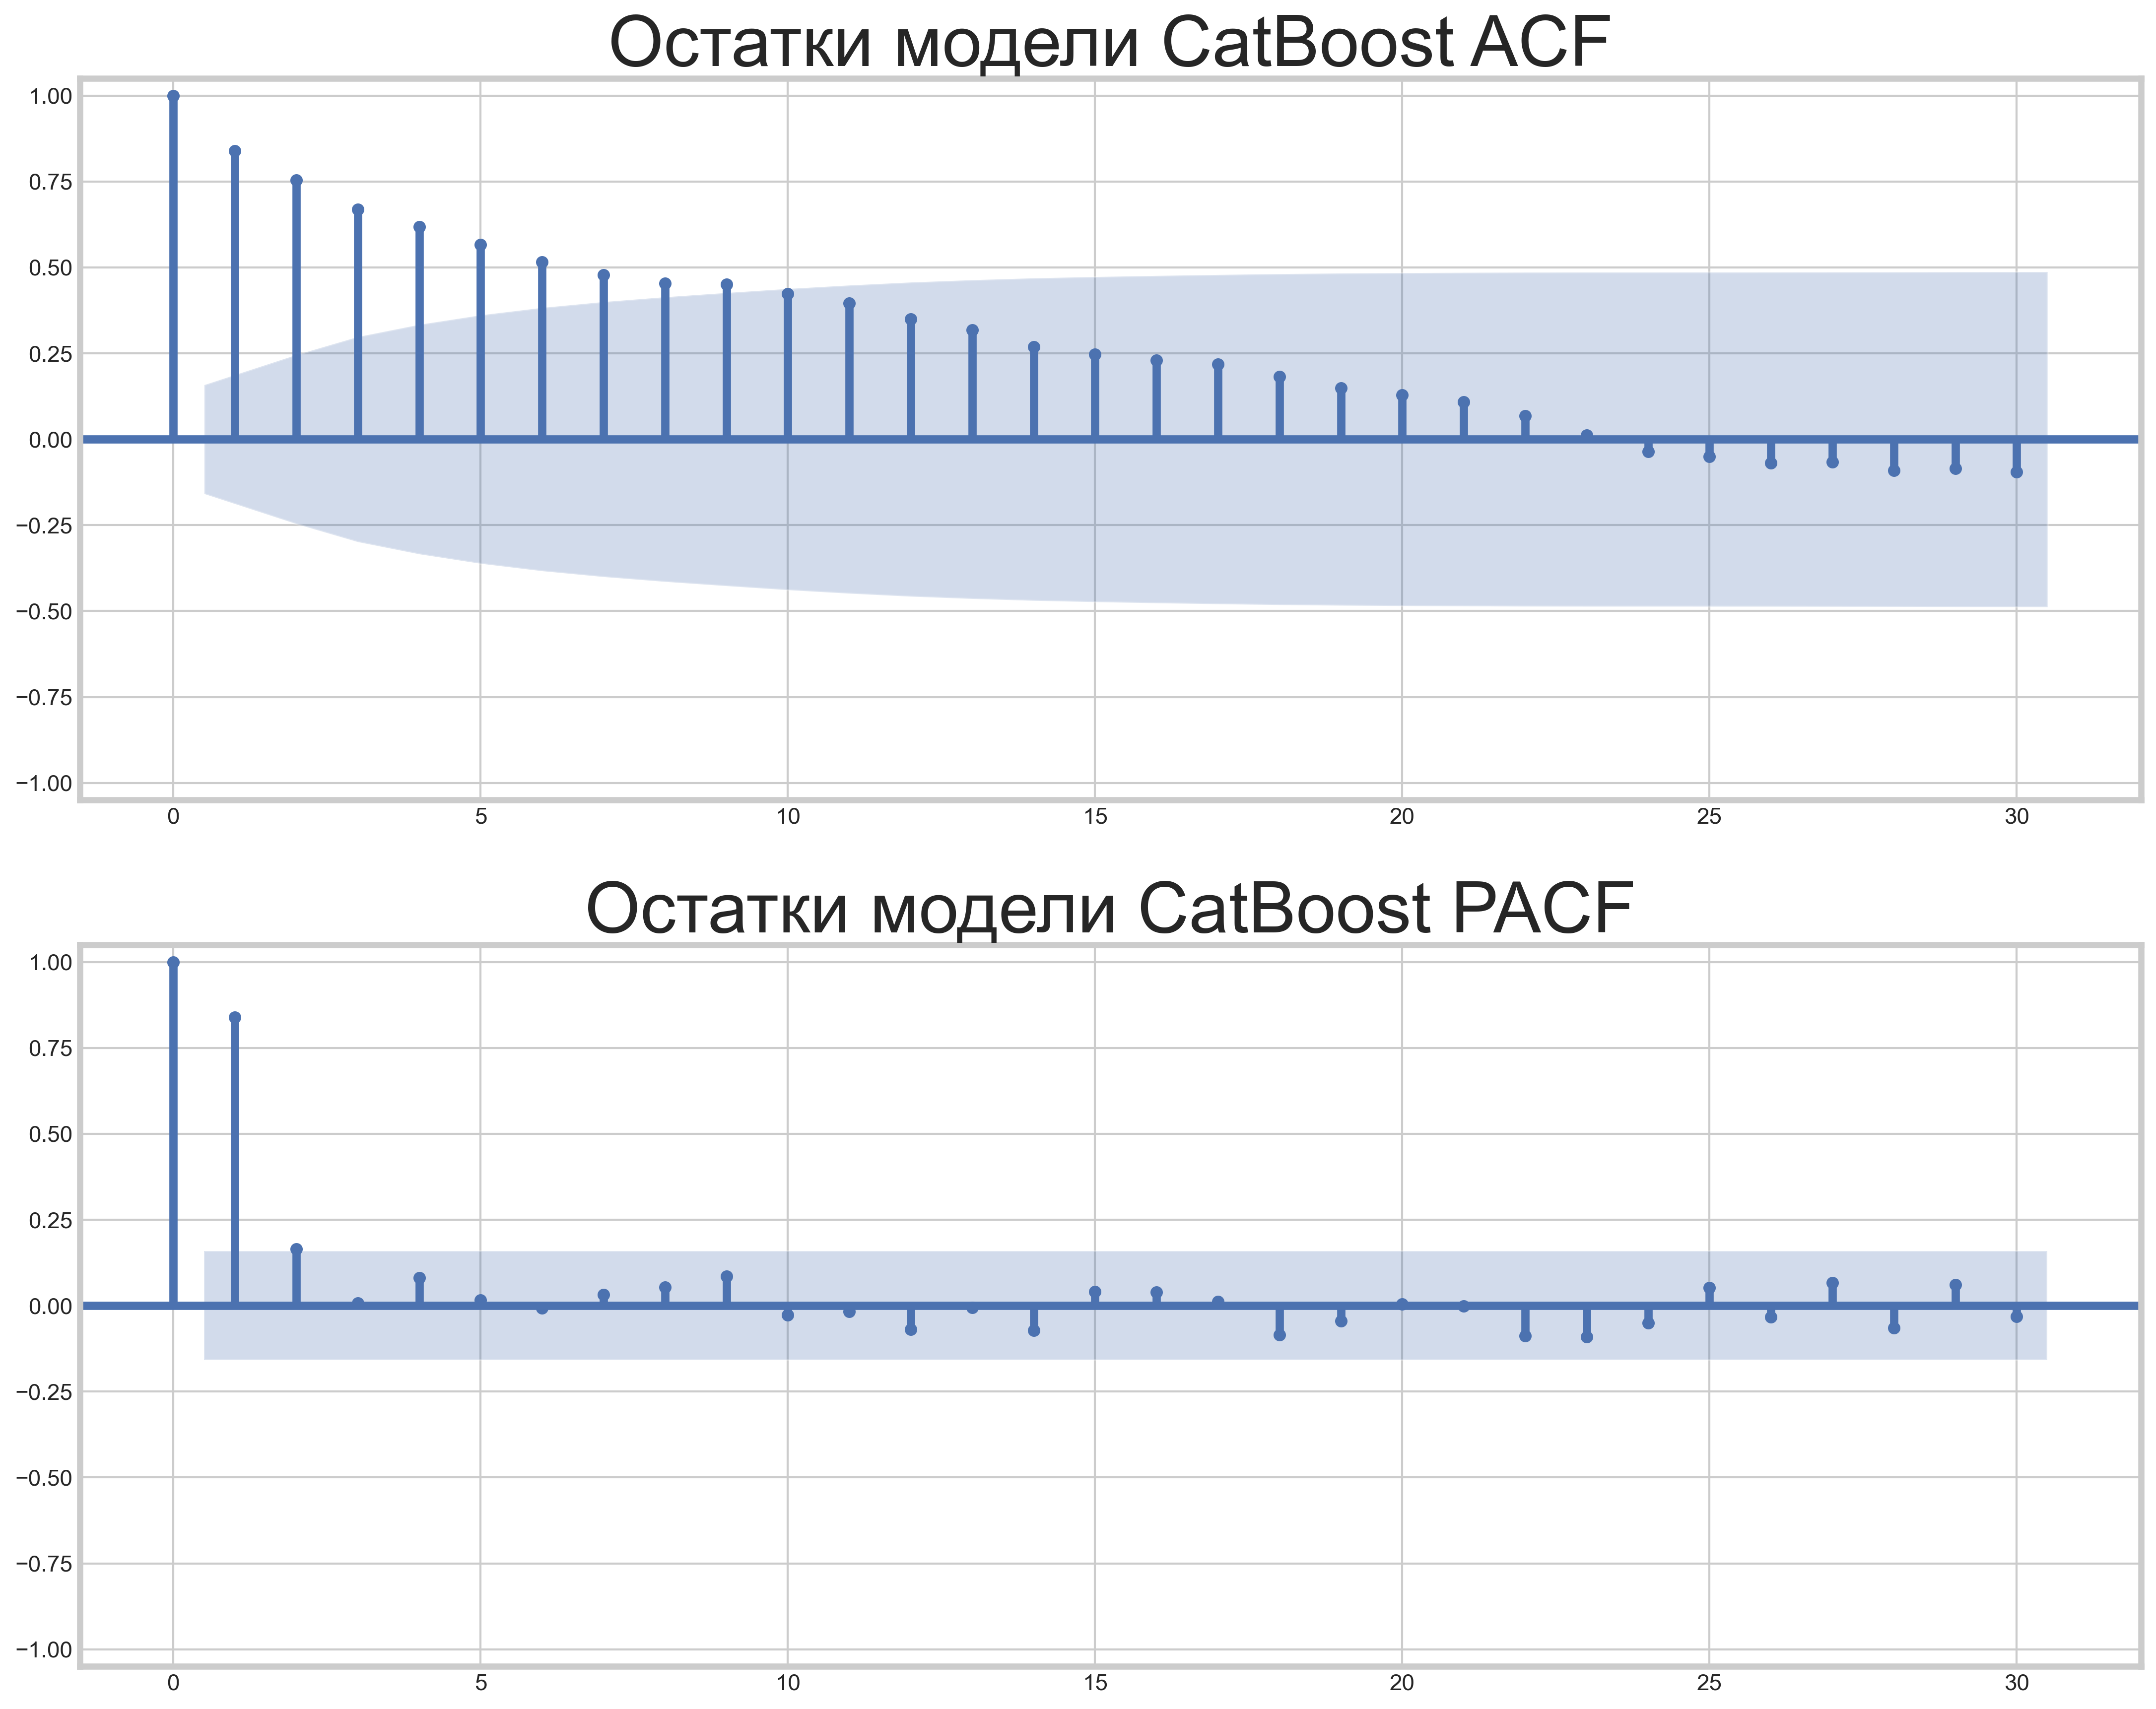

ADF Test (Augmented Dickey-Fuller)
H0: Временной ряд нестационарен (есть единичный корень)
H1: Временной ряд стационарен

Test Statistic                 -3.355
p-value                         0.013
# Lags Used                     0.000
Number of Observations Used   152.000
Critical Value (1%)            -3.474
Critical Value (5%)            -2.881
Critical Value (10%)           -2.577
dtype: float64

Интерпретация:
p-value = 0.0126 < 0.05 => Отклоняем H0: ряд считается стационарным.

-------------------------------------------------------------------------

KPSS Test (regression='c')
H0: Временной ряд тренд-стационарен
H1: Временной ряд тренд-нестационарен

Test Statistic          0.258
p-value                 0.100
Lags Used               8.000
Critical Value (10%)    0.347
Critical Value (5%)     0.463
Critical Value (2.5%)   0.574
Critical Value (1%)     0.739
dtype: float64

Интерпретация:
p-value = 0.1000 ≥ 0.05 => Не отклоняем H0: ряд считается тренд-стационарным.


C:\Users\smirn\AppData\Local\Temp\ipykernel_10476\2598901476.py:34: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




In [452]:
plot_acf_pacf(series=(y_original_test_gbdt - y_pred_gbdt), lags=30, title_prefix='Остатки модели CatBoost')
adf_test((y_original_test_gbdt - y_pred_gbdt)) # Дики-Фуллера, тестирует наличие единичного корня
print()
print('-------------------------------------------------------------------------')
print()
kpss_test((y_original_test_gbdt - y_pred_gbdt), regression='c') # проверяет тренд - тренд-стационарность, то есть, наличие или отсутствие тренда

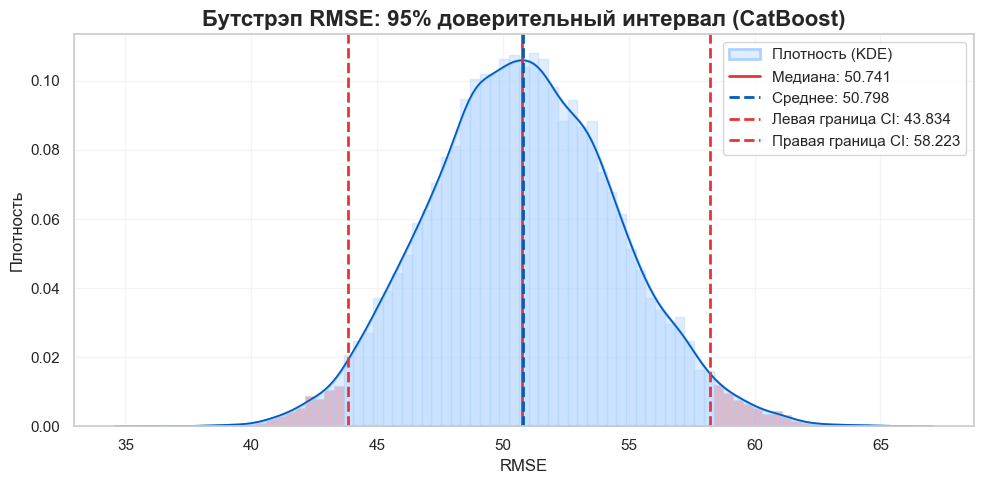

Bootstrap CI: [43.8344, 58.2232]
Медиана: 50.7407
Среднее: 50.7981


(43.83437964050566,
 58.2231832212904,
 50.740747395650665,
 50.79811900533097,
 array([46.23809845, 50.07585669, 51.99681204, ..., 56.40930476,
        48.8549904 , 44.72391436]))

In [453]:
bootstrap_rmse_hist_ci(y_true=y_original_test_gbdt,  
                       y_pred=y_pred_gbdt, 
                       n_iterations=10000,
                       alpha=0.05,
                       bins=75,
                       title="Бутстрэп RMSE: 95% доверительный интервал (CatBoost)"
                      )

### Оценка неопределенности - не сделал ансамбль, не рассчитываю

In [455]:
# import numpy as np

# def calculate_aleatoric_uncertainty(y_true, y_pred):
#     """
#     Оценивает алеторную (случайную) неопределённость для одной модели.
#     """
#     n = len(y_true)
#     residuals = y_true - y_pred
#     aleatoric_uncertainty = np.sum(residuals**2) / n
#     return aleatoric_uncertainty

# def calculate_epistemic_uncertainty(y_pred_ensemble):
#     """
#     Оценивает эпистемическую неопределённость для ансамбля предсказаний (n_models, n_samples).
#     Возвращает вектор для каждой точки.
#     """
#     mean_prediction = np.mean(y_pred_ensemble, axis=0)
#     m = y_pred_ensemble.shape[0]  # Число моделей
#     squared_diffs = np.sum((y_pred_ensemble - mean_prediction)**2, axis=0)
#     epistemic_uncertainty = squared_diffs / m
#     return epistemic_uncertainty

# def calculate_total_uncertainties(y_true, y_pred_ensemble):
#     """
#     Универсальная функция, которая рассчитывает алеторную, эпистемическую и их сумму для ансамбля.
#     Если у тебя одна модель, делай y_pred_ensemble = y_pred[None, :].
#     """
#     # Для алеторной - среднее по всем моделям
#     aleatoric_uncertainty = np.mean([
#         calculate_aleatoric_uncertainty(y_true, y_pred_ensemble[i])
#         for i in range(y_pred_ensemble.shape[0])
#     ])
#     # Для эпистемической - усредняем по всем точкам
#     epistemic_uncertainty = np.mean(calculate_epistemic_uncertainty(y_pred_ensemble))
#     total_uncertainty = aleatoric_uncertainty + epistemic_uncertainty
#     return aleatoric_uncertainty, epistemic_uncertainty, total_uncertainty

In [456]:
# aleatoric, epistemic, total = calculate_total_uncertainties(
#     y_true=np.array(y_original_test_gbdt),
#     y_pred_ensemble=np.expand_dims(np.array(arima_forecast), axis=0)  # shape (1, n_samples)
# )

# print(f"Алеторная неопределённость: {aleatoric:.4f}")
# print(f"Эпистемическая неопределённость: {epistemic:.4f}")
# print(f"Суммарная неопределённость: {total:.4f}")

In [457]:
# aleatoric, epistemic, total = calculate_total_uncertainties(
#     y_true=np.array(y_original_test_gbdt),
#     y_pred_ensemble=np.expand_dims(np.array(y_pred_gbdt), axis=0)  # shape (1, n_samples)
# )

# print(f"Алеторная неопределённость: {aleatoric:.4f}")
# print(f"Эпистемическая неопределённость: {epistemic:.4f}")
# print(f"Суммарная неопределённость: {total:.4f}")

### Diebold-Mariano test

In [459]:
!pip install dieboldmariano

In [460]:
def run_dm_test(y_true, y_pred_1, y_pred_2, 
                loss=None, 
                h=1, 
                one_sided=False,
                harvey_correction=True,
                variance_estimator="acf"):
    """
    Diebold-Mariano test для двух моделей.

    Аргументы:
        y_true: истинные значения (1D array-like)
        y_pred_1: предсказания первой модели (1D array-like)
        y_pred_2: предсказания второй модели (1D array-like)
        loss: функция потерь, если нужна кастомная (по умолчанию квадрат ошибки)
        h: горизонт прогноза (обычно 1)
        one_sided: если True, проверяет одностороннюю гипотезу (P2 не хуже P1)
        harvey_correction: использовать поправку Харви-Лейборн-Ньюболд
        variance_estimator: 'acf' или 'bartlett'
    """
    # Переводим в numpy для надёжности
    y_true = np.array(y_true)
    y_pred_1 = np.array(y_pred_1)
    y_pred_2 = np.array(y_pred_2)
    
    dm_stat, p_value = dm_test(
        y_true, y_pred_1, y_pred_2,
        loss=loss,
        h=h,
        one_sided=one_sided,
        harvey_correction=harvey_correction,
        variance_estimator=variance_estimator
    )
    print(f"DM-statistic: {dm_stat:.4f}, p-value: {p_value:.4f}")
    return dm_stat, p_value

run_dm_test(
    y_true=y_original_test,
    y_pred_1=arima_forecast,
    y_pred_2=y_pred_gbdt,
    loss=lambda u, v: (u - v) ** 2,   # обязательно указываем loss
    h=1,
    one_sided=False,  # двухсторонний тест
    variance_estimator="acf"
)

DM-statistic: -2.9101, p-value: 0.0042


(-2.910055332885341, 0.004156863590232883)

## Выводы по результатам DM-теста

- **Значение DM-статистики:** -2.91
- **p-value:** 0.0042

### Интерпретация:
- Полученное значение p-value < 0.05 свидетельствует о том, что различие между ошибками двух моделей статистически значимо.
- Отрицательное значение статистики указывает, что первая модель (указанная первой при расчёте разности ошибок) даёт прогнозы существенно более высокого качества, чем вторая.
- Таким образом, первая модель превосходит вторую по точности на выбранной тестовой выборке и заданной метрике ошибки.

### Практическое значение:
- Первая модель может быть рекомендована для дальнейшего использования и внедрения как более надёжный инструмент прогнозирования.
- Результаты DM-теста обоснованно подтверждают преимущество выбранной модели на рассматривамых данных.
мых данных.


## БУТСТРАП ДЛЯ РАЗНИЦЫ

In [463]:
# bootstrap_rmse_hist_ci(y_true=y_original_test,  
#                        y_pred=arima_forecast, 
#                        n_iterations=10000,
#                        alpha=0.05,
#                        bins=75,
#                        title="Бутстрэп RMSE: 95% доверительный интервал (ARIMA)"
#                       )

In [618]:
def bootstrap_rmse_diff_hist_ci(
    y_true, arima_forecast, y_pred_gbdt,
    n_iterations=10000, alpha=0.05, bins=30,
    title="Бутстрэп для разности RMSE моделей: 95% доверительный интервал (CatBoost - ARIMA)"
):
    """
    Строит бутстрэп-доверительный интервал для разности RMSE: CatBoost - ARIMA.
    """
    y_true = np.array(y_true)
    arima_forecast = np.array(arima_forecast)
    y_pred_gbdt = np.array(y_pred_gbdt)
    assert len(y_true) == len(arima_forecast) == len(y_pred_gbdt), "Массивы должны иметь одинаковую длину"

    n = len(y_true)
    rmse_diffs = []

    for _ in range(n_iterations):
        idx = np.random.choice(n, size=n, replace=True)
        rmse_catboost = np.sqrt(np.mean((y_true[idx] - y_pred_gbdt[idx]) ** 2))
        rmse_arima = np.sqrt(np.mean((y_true[idx] - arima_forecast[idx]) ** 2))
        rmse_diff = rmse_catboost - rmse_arima
        rmse_diffs.append(rmse_diff)

    rmse_diffs = np.array(rmse_diffs)

    left = np.percentile(rmse_diffs, 100 * alpha / 2)
    right = np.percentile(rmse_diffs, 100 * (1 - alpha / 2))
    median = np.median(rmse_diffs)
    mean = np.mean(rmse_diffs)

    plt.figure(figsize=(10, 5))
    counts, bin_edges, patches = plt.hist(
        rmse_diffs, bins=bins, density=True, color="#ADD2FF", alpha=0.4, edgecolor="#ADD2FF"
    )
    for patch, left_edge, right_edge in zip(patches, bin_edges[:-1], bin_edges[1:]):
        if right_edge < left or left_edge > right:
            patch.set_facecolor('#EA3338')
            patch.set_alpha(0.4)
        else:
            patch.set_facecolor('#ADD2FF')
            patch.set_alpha(0.4)

    sns.kdeplot(rmse_diffs, color="#ADD2FF", fill=True, alpha=0.4, linewidth=2, label="Плотность (KDE)")
    sns.kdeplot(rmse_diffs, color="#005CBF", fill=False, linewidth=1.3, label=None)

    plt.axvline(median, color="#EA3338", linestyle="-", lw=2, label=f"Медиана: {median:.3f}")
    plt.axvline(mean, color="#005CBF", linestyle="--", lw=2, label=f"Среднее: {mean:.3f}")
    plt.axvline(left, color="#EA3338", linestyle="--", lw=2, label=f"Левая граница CI: {left:.3f}")
    plt.axvline(right, color="#EA3338", linestyle="--", lw=2, label=f"Правая граница CI: {right:.3f}")

    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Разность RMSE (CatBoost - ARIMA)')
    plt.ylabel('Плотность')
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

    print(f"Bootstrap CI: [{left:.4f}, {right:.4f}]")
    print(f"Медиана разности RMSE: {median:.4f}")
    print(f"Средняя разность RMSE: {mean:.4f}")
    return left, right, median, mean, rmse_diffs

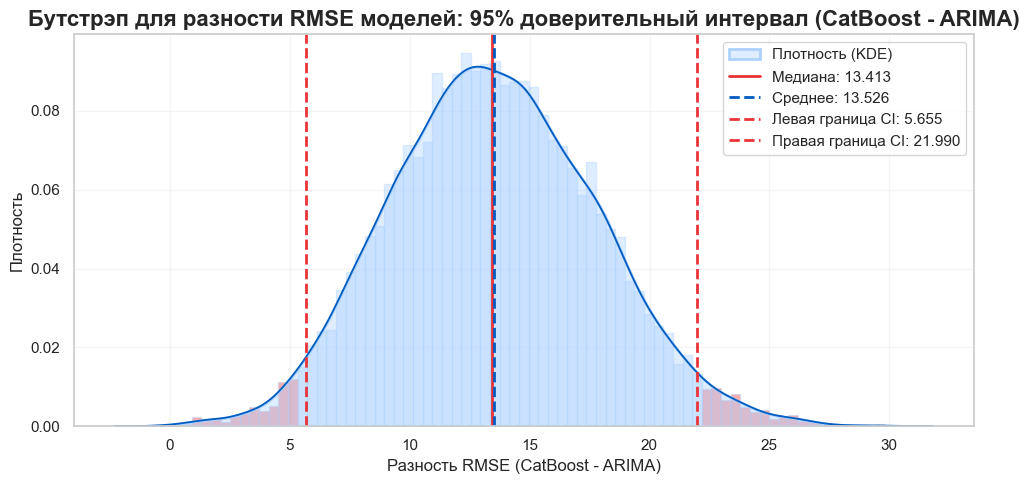

Bootstrap CI: [5.6549, 21.9902]
Медиана разности RMSE: 13.4131
Средняя разность RMSE: 13.5262


(5.654915685869469,
 21.990222635019602,
 13.413054093252182,
 13.526208667886388,
 array([ 5.98164849, 14.49333236, 15.18237144, ..., 16.55999346,
        17.00011548,  4.68487676]))

In [620]:
bootstrap_rmse_diff_hist_ci(y_true=y_original_test_gbdt,
                            arima_forecast=arima_forecast,
                            y_pred_gbdt=y_pred_gbdt,
                            n_iterations=10000,
                            alpha=0.05,
                            bins=75)